# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


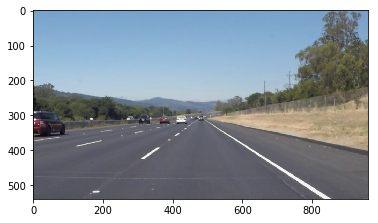

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    lane_thickness = 1#2#8
    lane_color = [255, 0, 0]
    lane_color_alt = [0, 255, 0]
    # when suspect tolerance coordinates might be bad, change the lane_color_alt to warn_color (red)
    warn_color1 = [255, 0, 255]
    warn_color2 = [255, 0, 0]
    canney_color = [0, 0, 255]
    canney_thickness = 2
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
          
    """ """
    # Draws Canny Lines.. (orig draw_lines code)
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            cv2.line(img, (x1, y1), (x2, y2), canney_color, canney_thickness)
    """ """ 
 

    ## Plan:
    # segregate parallel lines from same line
    
    # left-hand lanes:
    # find smallest x-coordinate,y-coordinate that would fit on this line
    # and largest x-coord, y-coord that would fit in our mask..
    
    # right-hand lanes: 
    # largest x-coord, y-coord is bottom right
    # smalles x-coord, y-coord is "tOp" of lane, near center.
    
    # anything that has a near horizonal slope is not a lane. 
    # ignore/delete them
    
    # any lines with similar slopes to the lane, but different endpoints:
    #   also ignore/delete these. They are not true lane markings
    #   (well for double lanes--they would be.. so maybe look at number/length)
    #   of such segments. 

    # look at our data..
    #print(lines)
    
    # first group all line segments that have same/similar slope together
    #    might want to set a tolerance, see if two slopes are within tolerance..
    slopesL = []
    slopesR = []
    midptsL = []
    midptsR = []
    coordsR = []
    coordsL = []
    # ignore slope of nearly horizontal lines
    slope_minimum = .25
    slopesRejected = []
    coordsRejected = []
    
    i = 0
    yMask = 99999999 #hack (can't use infinity)
    for line in lines:
        for x1,y1,x2,y2 in line:
            # want coordinate pairs stored with bottom coordinate first, top second
            if y1 >= y2:
                xbot, ybot, xtop, ytop = x1, y1, x2, y2
            else:
                xtop, ytop, xbot, ybot = x1, y1, x2, y2
            m = (ytop-ybot) / (xtop-xbot)
            
            # Left lane (negative slope; origin is top left) (x2 > x1, x2 is top point)
            if   (m <= -slope_minimum):
                slopesL.append(m)
                midptsL.append([int(round( xbot + (xtop-xbot)/2 )), int(round( ytop + (ybot-ytop)/2 ))] )
                coordsL.append([xbot, ybot, xtop, ytop])

            # Right Lane(postive slope) (x2 < x1, where x2 is top point)
            elif (m >= slope_minimum):
                slopesR.append(m)
                midptsR.append([int(round( xtop + (xbot-xtop)/2 )), int(round( ytop + (ybot-ytop)/2 ))] )
                coordsR.append([xbot, ybot, xtop, ytop])
            
            # neither (dismiss these segments)
            else:
                # for troubleshooting inspections
                slopesRejected.append(m)
                coordsRejected.append([xbot,ybot,xtop,ytop])
            
        #finding top of "mask" by looking for highest(smallest) y-coordinate in the set of all canney lines
        if (ytop < yMask):
            yMask = ytop
        i += 1
        
    #TODO look at range of slopes; handle or re-classify outliers before averaging
    #print("slopesL\n", slopesL, "\n")
    #print("slopesR\n", slopesR, "\n")
    if slopesRejected != []:
        print("slopes rejected\n", slopesRejected, "\n")
    #print("\n")
    
    # find average slope for left segments and right segments
    #  might want to average slopes that are in a certain tolerance
    #  then average slopes for pieces that are in a different tolerance
    #  as there could be more than one lane line
    #  also, for curves, the slope will be changing.. how to handle that ?
    #  todo: improved slope calculation
    
    ave_slopeL = sum(slopesL)/len(slopesL)
    maxS = max(slopesL)
    minS = min(slopesL)
    diff = maxS-minS
    percentage = diff/ave_slopeL
    
    #if ((diff > .4) or (percentage>.2)):
    if ((diff > .5) or (percentage>.3)):
        print("-- is this LEFT  slope tolerance ok?")#diff, percent diff, min, max, ave")
        #print(diff, percentage, minS, maxS, ave_slopeL, "\n")
        print("diff {0:.2f}".format(diff), ", % {0:.2f}".format(percentage), ", min {0:.2f}".format(minS), ", max {0:.2f}".format(maxS), ", ave {0:.2f}".format(ave_slopeL), ", slopesL: \n")
        print(*slopesL, sep=", ")
        print("\n")
        # draw lane_alt in red instead of green, as suspect tolerance or coordinates might be bad
        lane_color_alt = warn_color1
    #print("ave_slopeL: ", ave_slopeL)
    
    ave_slopeR = sum(slopesR)/len(slopesR)
    maxS = max(slopesR)
    minS = min(slopesR)
    diff = maxS-minS
    percentage = diff/ave_slopeR
    
    #if ((diff > .4) or (percentage>.2)):
    if ((diff > .5) or (percentage>.3)):
        print("-- is this RIGHT slope tolerance ok?")
        #print(diff, percentage, minS, maxS, ave_slopeL, "\n")
        #print(" slopesR: ",slopesR, "\n")
        print("diff {0:.2f}".format(diff), ", % {0:.2f}".format(percentage), ", min {0:.2f}".format(minS), ", max {0:.2f}".format(maxS), ", ave {0:.2f}".format(ave_slopeR), ", slopesR: \n")
        print(*slopesR, sep=", ", end="\n")
        print("\n")
        # draw lane_alt in red instead of green, as suspect tolerance or coordinates might be bad
        lane_color_alt = warn_color1
    #print("ave_slopeR: ", ave_slopeR)

    ## Now: how do I determine coordinates to use for each lane/slope ?
    #  also: will need to do something better for curved lines, and parallel lines

    # Find minimum y-coordinate from canny lines
    # Since I no longer have access to mask, I will use minimum y-coordinate 
    #   and extrapolate the line segments, from their midpoints,  
    #   to max x and y coordinates found in the canney line coordinates
    
    # let's presume that our mask has a parallel top: ie yminL == yminR 
    # yMask is the smallest/topmost y-value coordinate that should be printed
    yTop = yMask
    # yMax is the largest/bottomost y-value ..
    # let's presume that y-max = bottom of image
    yBot = image.shape[0]
    print("yTop:", yTop, "yBot", yBot) 
  
    ## for each slope in slopesL, slopesR. Find the x-coordinates that would
        #pass through yTop, and yBot    
    
    # LEFT LANE ########################################################################################
    #print("coordsL:\n", coordsL)
    
    # warn: this routine presumes that the largest y-value in canney lines should NOT be masked out
    #Left: anchor point that our extrapolated line shall pass through
    #    Nieve: find bottom-most y-coordinate from our canny lines
    #    rem coordsL: (xbot,ybot,xtop,ytop)
    ymaxL  = 0
    iymaxL = 0
    xmaxL = 0
    ixmaxL = 0
    for i in range(len(coordsL)):
        if (coordsL[i][1]) > ymaxL:
            iymaxL = i
            ymaxL = coordsL[iymaxL][1]
        # warn: presumes there is not, for example, a deep L-had curve ..assumes:
        # largest x-coordinate in canneyL line is at TOP, ie 2nd set of coords
        if (coordsL[i][2]) > xmaxL:
            ixmaxL = i
            xmaxL = coordsL[ixmaxL][2]
    # top-most left-lane canney coordinates
    xcL = coordsL[iymaxL][0]
    ycL = coordsL[iymaxL][1]
    print("topmost-y canney coordinate", xcL, ycL)
    
    # canney coords with  largest x-value, presumably top of left lane (depending on curves). Coordinates may be outside the mask
    xtL = coordsL[ixmaxL][2]
    ytL = coordsL[ixmaxL][3]
    print("largest-x canney coordinate", xtL, ytL)

    
    #Left
    m = ave_slopeL
    
    #lane line based on min y coord in canney set of coords, average slope of canney segments, and overall ytop/ybot allowed from mask
    xtopL = int(round( (yTop - ycL)/m + xcL ))
    xbotL = int(round( (yBot - ycL)/m + xcL ))
    laneL_ymin = [xbotL, yBot, xtopL, yTop]
    #print("L: lane:", laneL_ymin, "\nslope:{0:+.2f}".format(m), "anchor:", xcL, ycL, "\n")

    # extrapolate to find x-coordinate at yTop, based on slope for current coordinate set
    if ytL > yTop:
        print("\nytL > yTop:", ytL, yTop)
        m = (ytL-yBot)/(xtL-xbotL)
        xtL = int(round( xtL + (yTop - ytL)/m ))
        ytL = yTop
        print("xtL , ytL :", xtL, ytL)
         
    
    # lane line based on largest x-value and largest y-value of canney coordinates,
    # min y, and max x
    # uses xtopL, xbotL from section above (based on min canney y-coord), xt,yt from largest canney x-coordinate    
    # if ya < ymin, this point falls outside our mask, calculate the xa coordinate on this line that lies at the top of the mask
    #if ytL < yTop:
    if ytL < yTop:
        print("\nytL < yTop:", ytL, yTop)
        m = (ytL-yBot)/(xtL-xbotL)
        xtL = int(round( xtL + (yTop - ytL)/m ))
        ytL = yTop
        print("xtL , ytL  :", xtL, ytL)
        
    # now, if newly calculated xt > largest x-canney coordinate found, let's limit this value also
    # won't work if top of lane marking is missing - assumes top of lane markings always converge to visibility
    # this also changes the slope, as we are simply replacing the x-coordinate, without re-caclulating the equivalent y-coordinate
    #   figure this altered slope will be just fine
    if xtL > xmaxL:
        print("xtL > xmaxL:", xtL, xmaxL, ", m:", m)
        #xtL = xmaxL

    laneL_alt = [xbotL, yBot, xtL, ytL]
    m = (ytL-yBot) / (xtL-xbotL)
    #if m > 0:
    #if (m > 0.8 * ave_slopeL) or (m < 1.2 * ave_slopeL):
    if (m > 0.75 * ave_slopeL) or (m < 1.3 * ave_slopeL):
        print("!!!! WARN: slope Left Lane =  {0:+.2f}".format(m/ave_slopeL), " * ave_slopeL: ", ave_slopeL, m)
        lane_color_alt = warn_color2
        #print("!!!! WARN: slope > 0 Left Lane: ", m)
    #laneL_alt = [xbotL, yBot, xtL, ytL]
    #laneR_alt = [xbotR, yBot, xtR, ytR]
    #laneR     = [xbotR, yBot, xtopR, yTop]
    print("\nL: alt:", laneL_alt, ", slope:{0:+.3f}".format(m), ", ave_slopeL: {0:+.3f}".format(ave_slopeL), ", diff: {0:+.2f}".format(ave_slopeL-m), ", %: {0:+.2f}".format((ave_slopeL-m)/ave_slopeL), "\n")
 
    
    # RIGHT LANE ####################################################################################
    #print("\ncoordsR:\n", coordsR)

    
    #   warn: could return coordinates that are higher than ymin for the mask
    #   warn: this routine presumes that the largest y-value in canney lines should NOT be masked out
    # Right: find ancor point coordinates. rem coordsR: (xbot,ybot,xtop,ytop) 
    #   nieve: use bottom-most y-coord from canney lines
    ymaxR  = 0
    iymaxR = 0
    xminR  = image.shape[1]
    ixminR = 0
    for i in range(len(coordsR)):
        if coordsR[i][1] > ymaxR:
            iymaxR = i
            ymaxR = coordsR[iymaxR][1]
            
        # warn: could return coordinates that are higher than ymin for the mask
        # warn: presumes there is not a deep R-had curve (for example)..assumes:
        # smallest x-coordinate in canney line is at TOP, ie 2nd set of coords
        if coordsR[i][2] < xminR:
            ixminR = i
            xminR  = coordsR[ixminR][2]
    xcR = coordsR[iymaxR][0]
    ycR = coordsR[iymaxR][1]
    print("Right Lane topmost-y  canney coordinate", xcR, ycR)
    
    # left most coordinates found in the canny coordinate set for right lane
    xtR = coordsR[ixminR][2]
    ytR = coordsR[ixminR][3]
    print("Right Lane smallest-x canney coordinate", xtR, ytR)
    
    #Right
    m = ave_slopeR
    xtopR = int(round( (yTop - ycR)/m + xcR ))
    # extrapolated xtopR might be way smaller than smallest coordinate in our canney set. 
    xbotR = int(round( (yBot - ycR)/m + xcR ))
    laneR = [xbotR, yBot, xtopR, yTop]
    #print("R: ave_slope:", laneR, "\nslope:{0:+.2f}".format(m), "anchor:", xcR, ycR, xtR, ytR, "\n")
    
    # extrapolate to find x-coordinate at yTop, based on slope for current coordinate set
    if ytR > yTop:
        print("\nytR > yTop ", ytR, yTop)
        m = (ytR-yBot)/(xtR-xbotR)
        xtR = int(round( (yTop - ytR)/m + xtR ))
        ytR = yTop
        print("xtR , ytR  ", xtR, ytR)
        
    # if ya < ymin, this point falls outside our mask, calculate the xa coordinate on this line that lies at the top of the mask
    if ytR < yTop:
        print("\nytR < yTop ", ytR, yTop)
        m = (ytR-yBot)/(xtR-xbotR)
        xtR = int(round( (yTop - ytR)/m + xtR ))
        ytR = yTop
        print("xtR , ytR ", xtR, ytR)
        
    # now, if newly calculated xa < smallest x-canney coordinate found, let's limit this value also
    # won't work if top of lane marking is missing - assumes top of lane markings always converge to visibility
    if xtR < xminR:
        print("xtR < xminR", xtR, xminR)
        #xtR = xminR
    laneR_alt = [xbotR, yBot, xtR, ytR]
    m = (ytR-yBot) / (xtR-xbotR)
    #if (m < 0.8 * ave_slopeR) or (m > 1.2 * ave_slopeR):
    if (m < 0.75 * ave_slopeR) or (m > 1.3 * ave_slopeR):
        print("!!!! WARN: slope Right Lane =  {0:+.2f}".format(m/ave_slopeR), " * ave_slopeR: ", ave_slopeR, m)
        lane_color_alt = warn_color2
    print("\nR: alt:", laneR_alt, ", slope:{0:+.3f}".format(m), ", ave_slopeR: {0:+.3f}".format(ave_slopeR), ", diff: {0:+.2f}".format(ave_slopeR-m), ", %: {0:+.2f}".format((ave_slopeR-m)/ave_slopeR), "\n")
     

    # LANE LINES #################################################################################
    #TODO: don't let lines cross. compart xmax_L and xmin_R. adjust endpoint, if necessary
   
    # Lane Lines 
    lanes = [laneL_ymin, laneR]
    #lanes = [laneL_xmin, laneR]
    lanes_alt = [laneL_alt, laneR_alt]
    
    # draw extrapolated lines
    #Red - lanes based on slope alone
    #for lane in lanes:
    #    for x1,y1,x2,y2 in lanes:
    #        cv2.line(img, (x1, y1), (x2, y2), lane_color, lane_thickness)
            
    #Green - lanes from calcualted endpoints, where a coordinate is partially based on slope
    for lane in lanes_alt:
        for x1,y1,x2,y2 in lanes_alt:
            #print(x1,y1,x2,y2, lane, lanes)            
            cv2.line(img, (x1, y1), (x2, y2), lane_color_alt, canney_thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.8, ß=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * a + img * ß + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, ß, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
files = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).


 solidWhiteCurve.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 290 463
largest-x canney coordinate 481 313

L: alt: [186, 540, 481, 313] , slope:-0.769 , ave_slopeL: -0.741 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 899 539
Right Lane smallest-x canney coordinate 506 321

ytR > yTop  321 313
xtR , ytR   492 313
xtR < xminR 492 506

R: alt: [901, 540, 492, 313] , slope:+0.555 , ave_slopeR: +0.561 , diff: +0.01 , %: +0.01 


 solidWhiteRight.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 310 423
largest-x canney coordinate 475 313

L: alt: [148, 540, 475, 313] , slope:-0.694 , ave_slopeL: -0.720 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 488 313

R: alt: [856, 540, 488, 313] , slope:+0.617 , ave_slopeR: +0.652 , diff: +0.04 , %: +0.05 


 solidYellowCurve.jpg 
----------------------

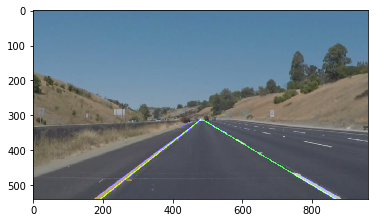

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
for f in files:
    print("\n",f, "\n----------------------------\n")
    #read in an image
    image = mpimg.imread('test_images/'+f)

    #print('This image is:', type(image), 'with dimesions:', image.shape)
    print(image.shape[1], image.shape[0])
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')   
    

    # lane lines will be drawn on this copy of the image
    color_select = np.copy(image)
    
    ## Mask. region of interest.
    
    #   Consider a triangle, apex in center of image. Base is bottom of image
    #   Now turn it into 4sided polygon, by cutting off a small triangle at the apex.
    #   the width at the top-side of the 4sides == base of the cut-off triangle 
    #   set width (dX) to, say around 5%-10% of the image width. try: ~125px on 960width

    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
        
    # convenience variables to scale, based on image resolutionyxratio = imshape[0]/imshape[1]
    # SH width of trapezoid top: keep same slope as if used triangle apex
    yxratio = ysize/xsize  
    dX = ysize//18
    dx = dX/2
    dy = yxratio * dx
    
    # default apex in center of image
    xapex = xsize//2
    yapex = ysize//2
    # x-offset from corners
    xs=0
    
    # calibrate for camera angle relative to car and zoom.
    #   manual adjustment for off square and off center camera position/angle 
    xapex += 0
    yapex += 35  # horizon is lower than center
    # lanes won't actually goto the corners of the image (if camera is rasonably adjusted)
    #dx/2
    
    # Define verticies: 4-sided polygon that lanes must fall within
    vertices = np.array([[(xs,ysize),(-dx+xapex, dy+yapex), (dx+xapex, dy+yapex), (-xs+xsize,ysize)]], dtype=np.int32)
    
    # save masked image for testing purposes
    # todo: delete or comment out when finished
    #masked_image = np.copy(region_of_interest(color_select, vertices))
    
    #mpimg.imsave('test_images/1mask_'+f, masked_image)
    #plt.imshow(masked_image)
    
    ## Edge Detection
    
    # grayscale copy of the image
    # question: am I getting a copy of the image returned, or need I make a copy first
    gray = grayscale(image)
    
    #show image
    #plt.imshow(gray, cmap='gray')
    
    # Define a kernel size for Gaussian smoothing and apply
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #show image
    #plt.imshow(blur_gray, cmap='gray')
    #mpimg.imsave('test_images/2blur_'+f, blur_gray)

    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    
    #plt.imshow(edges, cmap='gray')
    #mpimg.imsave('test_images/3edges_'+f, edges)
    
    # apply mask to canny edges image
    masked_edges = region_of_interest(edges, vertices)
    
    #mpimg.imsave('test_images/4masked_'+f, masked_edges)
    #plt.imshow(masked_edges)
    
       
    ## Houghes
    
    # Define the Hough transform parameters
    rho = 2              # resolution in pixels of the Hough grid
    theta = np.pi/180 *1 # angular resolution in radians of the Hough grid
    threshold    = 14    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30    # minimum number of pixels making up a line
    max_line_gap = 8     # maximum gap in pixels between connectable line segments
    
    # Run Hough on masked_edge (masked-canney) image
    lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #mpimg.imsave('test_images/5lines_'+f, lines_img)
    plt.imshow(lines_img)
    
    
    ## Draw Lines
    # draw_lines is called from INSIDE hough_lines !
    
    # overlay lane lines (houghes_img) onto orig (color_select) image
    result = weighted_img(lines_img, color_select, a=0.8, ß=1., λ=0.)
    plt.imshow(result)
   

    # save final image with line lanes drawn on it
    # todo: change naming of copied file (prefer: base_lanes.ext)
    mpimg.imsave('test_images/9lanes_'+f, result)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    
    # TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#for f in files:
    print("\n",f, "\n----------------------------\n")
    #read in an image
    #image = mpimg.imread('test_images/'+f)

    #print('This image is:', type(image), 'with dimesions:', image.shape)
    print(image.shape[1], image.shape[0])
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')   
    

    # lane lines will be drawn on this copy of the image
    color_select = np.copy(image)
    
    ## Mask. region of interest.
    
    #   Consider a triangle, apex in center of image. Base is bottom of image
    #   Now turn it into 4sided polygon, by cutting off a small triangle at the apex.
    #   the width at the top-side of the 4sides == base of the cut-off triangle 
    #   set width (dX) to, say around 5%-10% of the image width. try: ~125px on 960width

    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
        
    # convenience variables to scale, based on image resolutionyxratio = imshape[0]/imshape[1]
    # SH width of trapezoid top: keep same slope as if used triangle apex
    yxratio = ysize/xsize  
    dX = ysize//18
    dx = dX/2
    dy = yxratio * dx
    
    # default apex in center of image
    xapex = xsize//2
    yapex = ysize//2
    # x-offset from corners
    xs=0
    
    # calibrate for camera angle relative to car and zoom.
    #   manual adjustment for off square and off center camera position/angle 
    xapex += 0
    yapex += 35  # horizon is lower than center
    # lanes won't actually goto the corners of the image (if camera is rasonably adjusted)
    #dx/2
    
    # Define verticies: 4-sided polygon that lanes must fall within
    vertices = np.array([[(xs,ysize),(-dx+xapex, dy+yapex), (dx+xapex, dy+yapex), (-xs+xsize,ysize)]], dtype=np.int32)
    
    # save masked image for testing purposes
    # todo: delete or comment out when finished
    #masked_image = np.copy(region_of_interest(color_select, vertices))
    
    #mpimg.imsave('test_images/1mask_'+f, masked_image)
    #plt.imshow(masked_image)
    
    ## Edge Detection
    
    # grayscale copy of the image
    # question: am I getting a copy of the image returned, or need I make a copy first
    gray = grayscale(image)
    
    #show image
    #plt.imshow(gray, cmap='gray')
    
    # Define a kernel size for Gaussian smoothing and apply
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #show image
    #plt.imshow(blur_gray, cmap='gray')
    #mpimg.imsave('test_images/2blur_'+f, blur_gray)

    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    
    #plt.imshow(edges, cmap='gray')
    #mpimg.imsave('test_images/3edges_'+f, edges)
    
    # apply mask to canny edges image
    masked_edges = region_of_interest(edges, vertices)
    
    #mpimg.imsave('test_images/4masked_'+f, masked_edges)
    #plt.imshow(masked_edges)
    
       
    ## Houghes
    
    # Define the Hough transform parameters
    rho = 2              # resolution in pixels of the Hough grid
    theta = np.pi/180 *1 # angular resolution in radians of the Hough grid
    threshold    = 14    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30    # minimum number of pixels making up a line
    max_line_gap = 8     # maximum gap in pixels between connectable line segments
    
    # Run Hough on masked_edge (masked-canney) image
    lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #mpimg.imsave('test_images/5lines_'+f, lines_img)
    #plt.imshow(lines_img)
    
    
    ## Draw Lines
    # draw_lines is called from INSIDE hough_lines !
    
    # overlay lane lines (houghes_img) onto orig (color_select) image
    result = weighted_img(lines_img, color_select, a=0.8, ß=1., λ=0.)
    #plt.imshow(result)
   

    # save final image with line lanes drawn on it
    # todo: change naming of copied file (prefer: base_lanes.ext)
    #mpimg.imsave('test_images/9lanes_'+f, result)

    
    
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 203 514
largest-x canney coordinate 470 313

L: alt: [168, 540, 470, 313] , slope:-0.752 , ave_slopeL: -0.739 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [851, 540, 495, 313] , slope:+0.638 , ave_slopeR: +0.601 , diff: -0.04 , %: -0.06 

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                          | 0/222 [00:00<?, ?it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 203 514
largest-x canney coordinate 470 313

L: alt: [168, 540, 470, 313] , slope:-0.752 , ave_slopeL: -0.739 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [851, 540, 495, 313] , slope:+0.638 , ave_slopeR: +0.601 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 471 313

L: alt: [167, 540, 471, 313] , slope:-0.747 , ave_slopeL: -0.727 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 846 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [848, 540, 495, 313] , slope:+0.643 , ave_slopeR: +0.642 , diff: -0.00 , %: -0.00 



  1%|▍                                                 | 2/222 [00:00<00:14, 14.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 467 315

ytL > yTop: 315 313
xtL , ytL : 470 313
xtL > xmaxL: 470 467 , m: -0.75

L: alt: [167, 540, 470, 313] , slope:-0.749 , ave_slopeL: -0.708 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 869 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [871, 540, 491, 313] , slope:+0.597 , ave_slopeR: +0.591 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.750830564784

L: alt: [168, 540, 470, 313] , slope:-0.752 , ave_slopeL: -0.739 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [851, 540, 491, 313] , slope:+0.631 , ave_slopeR: +0.6

  2%|▉                                                 | 4/222 [00:00<00:15, 13.87it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 418 349
largest-x canney coordinate 471 313

L: alt: [148, 540, 471, 313] , slope:-0.703 , ave_slopeL: -0.708 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [852, 540, 491, 313] , slope:+0.629 , ave_slopeR: +0.613 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 416 350
largest-x canney coordinate 471 313

L: alt: [154, 540, 471, 313] , slope:-0.716 , ave_slopeL: -0.725 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [873, 540, 492, 313] , slope:+0.596 , ave_slopeR: +0.614 , diff: +0.02 , %: +0.03 



  3%|█▎                                                | 6/222 [00:00<00:15, 14.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 339 403
largest-x canney coordinate 470 313

L: alt: [152, 540, 470, 313] , slope:-0.714 , ave_slopeL: -0.732 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [853, 540, 496, 313] , slope:+0.636 , ave_slopeR: +0.616 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 333 413
largest-x canney coordinate 470 313

L: alt: [157, 540, 470, 313] , slope:-0.725 , ave_slopeL: -0.721 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [854, 540, 492, 313] , slope:+0.627 , ave_slopeR: +0.612 , diff: -0.02 , %: -0.02 



  4%|█▊                                                | 8/222 [00:00<00:15, 14.12it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 315 425
largest-x canney coordinate 466 315

ytL > yTop: 315 313
xtL , ytL : 469 313
xtL > xmaxL: 469 466 , m: -0.716560509554

L: alt: [152, 540, 469, 313] , slope:-0.716 , ave_slopeL: -0.704 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [853, 540, 492, 313] , slope:+0.629 , ave_slopeR: +0.611 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.125] 

yTop: 313 yBot 540
topmost-y canney coordinate 289 439
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.697530864198

L: alt: [148, 540, 473, 313] , slope:-0.698 , ave_slopeL: -0.714 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 488 313

R: alt: [868, 540, 488, 3

  5%|██▏                                              | 10/222 [00:00<00:15, 13.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 263 459
largest-x canney coordinate 477 313

L: alt: [150, 540, 477, 313] , slope:-0.694 , ave_slopeL: -0.716 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 490 315

ytR > yTop  315 313
xtR , ytR   487 313
xtR < xminR 487 490

R: alt: [862, 540, 487, 313] , slope:+0.605 , ave_slopeR: +0.635 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.22857142857142856] 

yTop: 313 yBot 540
topmost-y canney coordinate 241 485
largest-x canney coordinate 478 313

L: alt: [164, 540, 478, 313] , slope:-0.723 , ave_slopeL: -0.715 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 857 539
Right Lane smallest-x canney coordinate 486 313

R: alt: [859, 540, 486, 313] , slope:+0.609 , ave_slopeR: +0.649 , diff: +0.04 , %: +0.06 



  5%|██▋                                              | 12/222 [00:00<00:16, 13.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 199 515
largest-x canney coordinate 476 313

L: alt: [164, 540, 476, 313] , slope:-0.728 , ave_slopeL: -0.721 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 487 313

R: alt: [858, 540, 487, 313] , slope:+0.612 , ave_slopeR: +0.634 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 473 313

L: alt: [160, 540, 473, 313] , slope:-0.725 , ave_slopeL: -0.695 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [836, 540, 490, 313] , slope:+0.656 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 



  6%|███                                              | 14/222 [00:01<00:15, 13.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 470 313

L: alt: [160, 540, 470, 313] , slope:-0.732 , ave_slopeL: -0.708 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 857 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [859, 540, 492, 313] , slope:+0.619 , ave_slopeR: +0.648 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 467 313

L: alt: [136, 540, 467, 313] , slope:-0.686 , ave_slopeL: -0.694 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 497 314

ytR > yTop  314 313
xtR , ytR   495 313
xtR < xminR 495 497

R: alt: [861, 540, 495, 313] , slope:+0.620 , ave_slopeR: +0.664 , diff: +0.04 , %: +0.07 



  7%|███▌                                             | 16/222 [00:01<00:16, 12.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 406 355
largest-x canney coordinate 465 313

L: alt: [143, 540, 465, 313] , slope:-0.705 , ave_slopeL: -0.704 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 504 318

ytR > yTop  318 313
xtR , ytR   496 313
xtR < xminR 496 504

R: alt: [862, 540, 496, 313] , slope:+0.620 , ave_slopeR: +0.641 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 350 391
largest-x canney coordinate 467 313

L: alt: [136, 540, 467, 313] , slope:-0.686 , ave_slopeL: -0.695 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [840, 540, 494, 313] , slope:+0.656 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 



  8%|███▉                                             | 18/222 [00:01<00:15, 12.81it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 340 400
largest-x canney coordinate 470 313

L: alt: [145, 540, 470, 313] , slope:-0.698 , ave_slopeL: -0.719 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [838, 540, 493, 313] , slope:+0.658 , ave_slopeR: +0.654 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 332 413
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.708463949843

L: alt: [152, 540, 472, 313] , slope:-0.709 , ave_slopeL: -0.706 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 496 314

ytR > yTop  314 313
xtR , ytR   494 313
xtR < xminR 494 496

R: alt: [857, 540, 494, 313] , slope:+0.625 , ave_slopeR: +0.629 , diff: +

  9%|████▍                                            | 20/222 [00:01<00:16, 12.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 320 425
largest-x canney coordinate 470 315

ytL > yTop: 315 313
xtL , ytL : 473 313
xtL > xmaxL: 473 470 , m: -0.718849840256

L: alt: [157, 540, 473, 313] , slope:-0.718 , ave_slopeL: -0.705 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [856, 540, 490, 313] , slope:+0.620 , ave_slopeR: +0.641 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 301 439
largest-x canney coordinate 468 313

L: alt: [161, 540, 468, 313] , slope:-0.739 , ave_slopeL: -0.723 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [837, 540, 493, 313] , slope:+0.660 , ave_slopeR: +0.634 , diff: -0.03 , %: -0.04 



 10%|████▊                                            | 22/222 [00:01<00:16, 12.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 275 457
largest-x canney coordinate 474 313

L: alt: [156, 540, 474, 313] , slope:-0.714 , ave_slopeL: -0.695 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xminR 494 497

R: alt: [857, 540, 494, 313] , slope:+0.625 , ave_slopeR: +0.634 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 244 479
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.724358974359

L: alt: [159, 540, 472, 313] , slope:-0.725 , ave_slopeL: -0.721 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [836, 540, 496, 313] , slope:+0.668 , ave_slopeR: +0.656 , diff: -

 11%|█████▎                                           | 24/222 [00:01<00:16, 12.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 200 510
largest-x canney coordinate 471 313

L: alt: [156, 540, 471, 313] , slope:-0.721 , ave_slopeL: -0.686 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [839, 540, 492, 313] , slope:+0.654 , ave_slopeR: +0.639 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 466 313

L: alt: [161, 540, 466, 313] , slope:-0.744 , ave_slopeL: -0.720 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [837, 540, 492, 313] , slope:+0.658 , ave_slopeR: +0.634 , diff: -0.02 , %: -0.04 



 12%|█████▋                                           | 26/222 [00:02<00:16, 12.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 473 313

L: alt: [162, 540, 473, 313] , slope:-0.730 , ave_slopeL: -0.685 , diff: +0.04 , %: -0.07 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [858, 540, 491, 313] , slope:+0.619 , ave_slopeR: +0.640 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.684848484848

L: alt: [140, 540, 471, 313] , slope:-0.686 , ave_slopeL: -0.724 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [858, 540, 491, 313] , slope:+0.619 , ave_slopeR: +0.640 , diff: +0.02 , %: +0.03 



 13%|██████▏                                          | 28/222 [00:02<00:15, 12.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 418 349
largest-x canney coordinate 472 313

L: alt: [144, 540, 472, 313] , slope:-0.692 , ave_slopeL: -0.697 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [858, 540, 491, 313] , slope:+0.619 , ave_slopeR: +0.639 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 352 394
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.70625

L: alt: [149, 540, 470, 313] , slope:-0.707 , ave_slopeL: -0.718 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [839, 540, 492, 313] , slope:+0.654 , ave_slopeR: +0.639 , diff: -0.02 , %: -0.02 



 14%|██████▌                                          | 30/222 [00:02<00:15, 12.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10526315789473684] 

yTop: 313 yBot 540
topmost-y canney coordinate 347 403
largest-x canney coordinate 471 313

L: alt: [152, 540, 471, 313] , slope:-0.712 , ave_slopeL: -0.703 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 500 318

ytR > yTop  318 313
xtR , ytR   492 313
xtR < xminR 492 500

R: alt: [840, 540, 492, 313] , slope:+0.652 , ave_slopeR: +0.637 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 335 412
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.712933753943

L: alt: [151, 540, 469, 313] , slope:-0.714 , ave_slopeL: -0.697 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 526 335

ytR > yTop  335 313
xtR , ytR   4

 14%|███████                                          | 32/222 [00:02<00:16, 11.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 319 423
largest-x canney coordinate 471 313

L: alt: [154, 540, 471, 313] , slope:-0.716 , ave_slopeL: -0.711 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 502 316

ytR > yTop  316 313
xtR , ytR   497 313
xtR < xminR 497 502

R: alt: [861, 540, 497, 313] , slope:+0.624 , ave_slopeR: +0.636 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 300 437
largest-x canney coordinate 465 313

L: alt: [160, 540, 465, 313] , slope:-0.744 , ave_slopeL: -0.736 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [861, 540, 493, 313] , slope:+0.617 , ave_slopeR: +0.632 , diff: +0.01 , %: +0.02 



 15%|███████▌                                         | 34/222 [00:02<00:16, 11.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 278 455
largest-x canney coordinate 474 313

L: alt: [159, 540, 474, 313] , slope:-0.721 , ave_slopeL: -0.715 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [839, 540, 496, 313] , slope:+0.662 , ave_slopeR: +0.625 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 246 478
largest-x canney coordinate 473 313

L: alt: [159, 540, 473, 313] , slope:-0.723 , ave_slopeL: -0.717 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 519 329

ytR > yTop  329 313
xtR , ytR   493 313
xtR < xminR 493 519

R: alt: [858, 540, 493, 313] , slope:+0.622 , ave_slopeR: +0.640 , diff: +0.02 , %: +0.03 



 16%|███████▉                                         | 36/222 [00:02<00:15, 11.63it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 204 510
largest-x canney coordinate 473 313

L: alt: [162, 540, 473, 313] , slope:-0.730 , ave_slopeL: -0.720 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 505 320

ytR > yTop  320 313
xtR , ytR   494 313
xtR < xminR 494 505

R: alt: [835, 540, 494, 313] , slope:+0.666 , ave_slopeR: +0.641 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.019801980198019802] 

yTop: 313 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 473 313

L: alt: [144, 540, 473, 313] , slope:-0.690 , ave_slopeL: -0.722 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 853 538
Right Lane smallest-x canney coordinate 492 313

R: alt: [856, 540, 492, 313] , slope:+0.624 , ave_slopeR: +0.646 , diff: +0.02 , %: +0.03 



 17%|████████▍                                        | 38/222 [00:03<00:15, 11.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 468 313

L: alt: [164, 540, 468, 313] , slope:-0.747 , ave_slopeL: -0.704 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 502 320

ytR > yTop  320 313
xtR , ytR   491 313
xtR < xminR 491 502

R: alt: [857, 540, 491, 313] , slope:+0.620 , ave_slopeR: +0.637 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 470 313

L: alt: [162, 540, 470, 313] , slope:-0.737 , ave_slopeL: -0.705 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [858, 540, 494, 313] , slope:+0.624 , ave_slopeR: +0.652 , diff: +0.03 , %: +0.04 



 18%|████████▊                                        | 40/222 [00:03<00:15, 11.47it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 408 354
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.668639053254

L: alt: [130, 540, 469, 313] , slope:-0.670 , ave_slopeL: -0.670 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [858, 540, 495, 313] , slope:+0.625 , ave_slopeR: +0.627 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 415 349
largest-x canney coordinate 469 313

L: alt: [134, 540, 469, 313] , slope:-0.678 , ave_slopeL: -0.680 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [857, 540, 495, 313] , slope:+0.627 , ave_slopeR: +0.649 , diff: +0.02 , %: +0.03 



 19%|█████████▎                                       | 42/222 [00:03<00:15, 11.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.012195121951219513] 

yTop: 313 yBot 540
topmost-y canney coordinate 343 399
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.71974522293

L: alt: [153, 540, 468, 313] , slope:-0.721 , ave_slopeL: -0.741 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [836, 540, 495, 313] , slope:+0.666 , ave_slopeR: +0.620 , diff: -0.05 , %: -0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 336 409
largest-x canney coordinate 462 314

ytL > yTop: 314 313
xtL , ytL : 463 313
xtL > xmaxL: 463 462 , m: -0.722044728435

L: alt: [149, 540, 463, 313] , slope:-0.723 , ave_slopeL: -0.700 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [85

 20%|█████████▋                                       | 44/222 [00:03<00:16, 10.98it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 320 421
largest-x canney coordinate 465 315

ytL > yTop: 315 313
xtL , ytL : 468 313
xtL > xmaxL: 468 465 , m: -0.718849840256

L: alt: [152, 540, 468, 313] , slope:-0.718 , ave_slopeL: -0.707 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [856, 540, 495, 313] , slope:+0.629 , ave_slopeR: +0.657 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 304 434
largest-x canney coordinate 464 313

L: alt: [158, 540, 464, 313] , slope:-0.742 , ave_slopeL: -0.726 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 313
xtR , ytR   498 313
xtR < xminR 498 504

R: alt: [838, 540, 498, 313] , slope:+0.668 , ave_slopeR: +0.657 , diff: -

 21%|██████████▏                                      | 46/222 [00:03<00:16, 10.94it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 281 450
largest-x canney coordinate 466 314

ytL > yTop: 314 313
xtL , ytL : 467 313
xtL > xmaxL: 467 466 , m: -0.731391585761

L: alt: [157, 540, 467, 313] , slope:-0.732 , ave_slopeL: -0.724 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 313
xtR , ytR   498 313
xtR < xminR 498 504

R: alt: [857, 540, 498, 313] , slope:+0.632 , ave_slopeR: +0.654 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 252 472
largest-x canney coordinate 460 317

ytL > yTop: 317 313
xtL , ytL : 465 313
xtL > xmaxL: 465 460 , m: -0.738410596026

L: alt: [158, 540, 465, 313] , slope:-0.739 , ave_slopeL: -0.725 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 832 539
Right Lane smallest-x canney coordinate 

 22%|██████████▌                                      | 48/222 [00:04<00:16, 10.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 211 502
largest-x canney coordinate 470 313

L: alt: [156, 540, 470, 313] , slope:-0.723 , ave_slopeL: -0.696 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [856, 540, 494, 313] , slope:+0.627 , ave_slopeR: +0.647 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 160 539
largest-x canney coordinate 470 313

L: alt: [159, 540, 470, 313] , slope:-0.730 , ave_slopeL: -0.679 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [833, 540, 493, 313] , slope:+0.668 , ave_slopeR: +0.658 , diff: -0.01 , %: -0.01 



 23%|███████████                                      | 50/222 [00:04<00:15, 10.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 465 313

L: alt: [138, 540, 465, 313] , slope:-0.694 , ave_slopeL: -0.703 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [836, 540, 492, 313] , slope:+0.660 , ave_slopeR: +0.627 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 470 313

L: alt: [136, 540, 470, 313] , slope:-0.680 , ave_slopeL: -0.692 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [855, 540, 493, 313] , slope:+0.627 , ave_slopeR: +0.667 , diff: +0.04 , %: +0.06 



 23%|███████████▍                                     | 52/222 [00:04<00:14, 11.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 469 313

L: alt: [154, 540, 469, 313] , slope:-0.721 , ave_slopeL: -0.689 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [856, 540, 492, 313] , slope:+0.624 , ave_slopeR: +0.645 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 416 349
largest-x canney coordinate 470 313

L: alt: [148, 540, 470, 313] , slope:-0.705 , ave_slopeL: -0.712 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 494 315

ytR > yTop  315 313
xtR , ytR   491 313
xtR < xminR 491 494

R: alt: [835, 540, 491, 313] , slope:+0.660 , ave_slopeR: +0.624 , diff: -0.04 , %: -0.06 



 24%|███████████▉                                     | 54/222 [00:04<00:14, 11.47it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 342 401
largest-x canney coordinate 469 313

L: alt: [123, 540, 469, 313] , slope:-0.656 , ave_slopeL: -0.633 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [833, 540, 496, 313] , slope:+0.674 , ave_slopeR: +0.658 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 329 411
largest-x canney coordinate 471 313

L: alt: [145, 540, 471, 313] , slope:-0.696 , ave_slopeL: -0.702 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [855, 540, 494, 313] , slope:+0.629 , ave_slopeR: +0.625 , diff: -0.00 , %: -0.01 



 25%|████████████▎                                    | 56/222 [00:04<00:13, 11.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 313 423
largest-x canney coordinate 472 313

L: alt: [138, 540, 472, 313] , slope:-0.680 , ave_slopeL: -0.668 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   488 313
xtR < xminR 488 490

R: alt: [854, 540, 488, 313] , slope:+0.620 , ave_slopeR: +0.645 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.027027027027027029] 

yTop: 313 yBot 540
topmost-y canney coordinate 293 438
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.670623145401

L: alt: [135, 540, 473, 313] , slope:-0.672 , ave_slopeL: -0.645 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 488 313

R: alt: [853, 540, 488, 313] , 

 26%|████████████▊                                    | 58/222 [00:04<00:15, 10.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 263 450
largest-x canney coordinate 473 313

L: alt: [131, 540, 473, 313] , slope:-0.664 , ave_slopeL: -0.679 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [852, 540, 489, 313] , slope:+0.625 , ave_slopeR: +0.637 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 240 476
largest-x canney coordinate 468 313

L: alt: [148, 540, 468, 313] , slope:-0.709 , ave_slopeL: -0.695 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [851, 540, 492, 313] , slope:+0.632 , ave_slopeR: +0.647 , diff: +0.01 , %: +0.02 



 27%|█████████████▏                                   | 60/222 [00:05<00:14, 11.07it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 197 507
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.699690402477

L: alt: [148, 540, 472, 313] , slope:-0.701 , ave_slopeL: -0.678 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 824 539
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 490

R: alt: [826, 540, 489, 313] , slope:+0.674 , ave_slopeR: +0.662 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 471 313

L: alt: [150, 540, 471, 313] , slope:-0.707 , ave_slopeL: -0.693 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 824 539
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 490

R: alt: [826,

 28%|█████████████▋                                   | 62/222 [00:05<00:15, 10.17it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 131 539
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.659824046921

L: alt: [130, 540, 474, 313] , slope:-0.660 , ave_slopeL: -0.669 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 824 539
Right Lane smallest-x canney coordinate 486 313

R: alt: [826, 540, 486, 313] , slope:+0.668 , ave_slopeR: +0.657 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.699690402477

L: alt: [148, 540, 472, 313] , slope:-0.701 , ave_slopeL: -0.682 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR , ytR   488 313
xtR < xminR 

 29%|██████████████▏                                  | 64/222 [00:05<00:15, 10.10it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 417 350
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.668639053254

L: alt: [133, 540, 472, 313] , slope:-0.670 , ave_slopeL: -0.669 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 487 313

R: alt: [825, 540, 487, 313] , slope:+0.672 , ave_slopeR: +0.663 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 411 351
largest-x canney coordinate 468 315

ytL > yTop: 315 313
xtL , ytL : 471 313
xtL > xmaxL: 471 468 , m: -0.683890577508

L: alt: [139, 540, 471, 313] , slope:-0.684 , ave_slopeL: -0.694 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 843 539
Right Lane smallest-x canney coordinate 491 315

ytR > yTop  315 313
xtR , ytR   488 313
xtR < xminR 

 30%|██████████████▌                                  | 66/222 [00:05<00:15, 10.03it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 335 398
largest-x canney coordinate 466 315

ytL > yTop: 315 313
xtL , ytL : 469 313
xtL > xmaxL: 469 466 , m: -0.657894736842

L: alt: [124, 540, 469, 313] , slope:-0.658 , ave_slopeL: -0.673 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 825 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [827, 540, 490, 313] , slope:+0.674 , ave_slopeR: +0.645 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 322 408
largest-x canney coordinate 469 313

L: alt: [131, 540, 469, 313] , slope:-0.672 , ave_slopeL: -0.691 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 828 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [830, 540, 489, 313] , slope:+0.666 , ave_slopeR: +0.645 , diff: -0.02 , %: -0.03 



 31%|███████████████                                  | 68/222 [00:05<00:14, 10.48it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 313 420
largest-x canney coordinate 470 313

L: alt: [131, 540, 470, 313] , slope:-0.670 , ave_slopeL: -0.660 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 825 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [827, 540, 489, 313] , slope:+0.672 , ave_slopeR: +0.630 , diff: -0.04 , %: -0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 295 433
largest-x canney coordinate 466 315

ytL > yTop: 315 314
xtL , ytL : 467 314
xtL > xmaxL: 467 466 , m: -0.685975609756

L: alt: [138, 540, 467, 314] , slope:-0.687 , ave_slopeL: -0.681 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 508 326

ytR > yTop  326 314
xtR , ytR   490 314
xtR < xminR 490 508

R: alt: [825, 540, 490, 314] , slope:+0.675 , ave_slopeR: +0.661 , diff: -

 32%|███████████████▍                                 | 70/222 [00:06<00:14, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.030303030303030304] 

yTop: 313 yBot 540
topmost-y canney coordinate 272 449
largest-x canney coordinate 471 313

L: alt: [136, 540, 471, 313] , slope:-0.678 , ave_slopeL: -0.671 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [825, 540, 494, 313] , slope:+0.686 , ave_slopeR: +0.666 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 240 470
largest-x canney coordinate 469 313

L: alt: [136, 540, 469, 313] , slope:-0.682 , ave_slopeL: -0.674 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 824 539
Right Lane smallest-x canney coordinate 510 327

ytR > yTop  327 313
xtR , ytR   489 313
xtR < xminR 489 510

R: alt: [826, 540, 489, 313] , slope:+0.674 , ave_slopeR: +0.663 , diff: -0.01 , %: -0.02 



 32%|███████████████▉                                 | 72/222 [00:06<00:13, 10.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 199 499
largest-x canney coordinate 469 313

L: alt: [138, 540, 469, 313] , slope:-0.686 , ave_slopeL: -0.672 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 510 327

ytR > yTop  327 313
xtR , ytR   489 313
xtR < xminR 489 510

R: alt: [825, 540, 489, 313] , slope:+0.676 , ave_slopeR: +0.658 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 145 538
largest-x canney coordinate 470 313

L: alt: [142, 540, 470, 313] , slope:-0.692 , ave_slopeL: -0.670 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 822 539
Right Lane smallest-x canney coordinate 513 330

ytR > yTop  330 313
xtR , ytR   488 313
xtR < xminR 488 513

R: alt: [824, 540, 488, 313] , slope:+0.676 , ave_slope

 33%|████████████████▎                                | 74/222 [00:06<00:14, 10.45it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 122 539
largest-x canney coordinate 468 314

L: alt: [121, 540, 468, 314] , slope:-0.651 , ave_slopeL: -0.674 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 493 315

ytR > yTop  315 314
xtR , ytR   492 314
xtR < xminR 492 493

R: alt: [821, 540, 492, 314] , slope:+0.687 , ave_slopeR: +0.670 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 469 313

L: alt: [135, 540, 469, 313] , slope:-0.680 , ave_slopeL: -0.647 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 517 329

ytR > yTop  329 313
xtR , ytR   494 313
xtR < xminR 494 517

R: alt: [822, 540, 494, 313] , slope:+0.692 , ave_slopeR: +0.659 , diff: -0.03 , %: -0.05 



 34%|████████████████▊                                | 76/222 [00:06<00:13, 10.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 469 313

L: alt: [135, 540, 469, 313] , slope:-0.680 , ave_slopeL: -0.652 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 821 539
Right Lane smallest-x canney coordinate 517 331

ytR > yTop  331 313
xtR , ytR   491 313
xtR < xminR 491 517

R: alt: [822, 540, 491, 313] , slope:+0.686 , ave_slopeR: +0.675 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 411 350
largest-x canney coordinate 469 313

L: alt: [134, 540, 469, 313] , slope:-0.678 , ave_slopeL: -0.686 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 818 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [820, 540, 489, 313] , slope:+0.686 , ave_slopeR: +0.666 , diff: -0.02 , %: -0.03 



 35%|█████████████████▏                               | 78/222 [00:06<00:13, 10.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 333 397
largest-x canney coordinate 469 313

L: alt: [116, 540, 469, 313] , slope:-0.643 , ave_slopeL: -0.660 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [839, 540, 490, 313] , slope:+0.650 , ave_slopeR: +0.664 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 325 409
largest-x canney coordinate 462 314

L: alt: [128, 540, 462, 314] , slope:-0.677 , ave_slopeL: -0.667 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 814 539
Right Lane smallest-x canney coordinate 495 314

R: alt: [815, 540, 495, 314] , slope:+0.706 , ave_slopeR: +0.676 , diff: -0.03 , %: -0.04 



 36%|█████████████████▋                               | 80/222 [00:06<00:12, 11.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 311 419
largest-x canney coordinate 469 313

L: alt: [122, 540, 469, 313] , slope:-0.654 , ave_slopeL: -0.641 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 815 539
Right Lane smallest-x canney coordinate 515 331

ytR > yTop  331 313
xtR , ytR   489 313
xtR < xminR 489 515

R: alt: [816, 540, 489, 313] , slope:+0.694 , ave_slopeR: +0.685 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 298 429
largest-x canney coordinate 469 313

L: alt: [126, 540, 469, 313] , slope:-0.662 , ave_slopeL: -0.644 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [836, 540, 489, 313] , slope:+0.654 , ave_slopeR: +0.676 , diff: +0.02 , %: +0.03 



 37%|██████████████████                               | 82/222 [00:07<00:12, 11.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 268 448
largest-x canney coordinate 468 313

L: alt: [125, 540, 468, 313] , slope:-0.662 , ave_slopeL: -0.645 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 812 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [814, 540, 489, 313] , slope:+0.698 , ave_slopeR: +0.654 , diff: -0.04 , %: -0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 238 468
largest-x canney coordinate 468 313

L: alt: [127, 540, 468, 313] , slope:-0.666 , ave_slopeL: -0.649 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 812 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [813, 540, 489, 313] , slope:+0.701 , ave_slopeR: +0.669 , diff: -0.03 , %: -0.05 



 38%|██████████████████▌                              | 84/222 [00:07<00:11, 11.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 196 497
largest-x canney coordinate 470 313

L: alt: [130, 540, 470, 313] , slope:-0.668 , ave_slopeL: -0.656 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 813 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [814, 540, 490, 313] , slope:+0.701 , ave_slopeR: +0.696 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 140 536
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.678678678679

L: alt: [134, 540, 468, 313] , slope:-0.680 , ave_slopeL: -0.655 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 813 539
Right Lane smallest-x canney coordinate 492 314

ytR > yTop  314 313
xtR , ytR   491 313
xtR < xminR 491 492

R: alt: [814, 540, 491, 313] , slope:+0.703 , ave

 39%|██████████████████▉                              | 86/222 [00:07<00:12, 11.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 138 538
largest-x canney coordinate 469 313

L: alt: [135, 540, 469, 313] , slope:-0.680 , ave_slopeL: -0.649 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 812 539
Right Lane smallest-x canney coordinate 492 314

ytR > yTop  314 313
xtR , ytR   491 313
xtR < xminR 491 492

R: alt: [813, 540, 491, 313] , slope:+0.705 , ave_slopeR: +0.674 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 117 539
largest-x canney coordinate 471 313

L: alt: [115, 540, 471, 313] , slope:-0.638 , ave_slopeL: -0.653 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 811 539
Right Lane smallest-x canney coordinate 493 315

ytR > yTop  315 313
xtR , ytR   490 313
xtR < xminR 490 493

R: alt: [812, 540, 490, 313] , slope:+0.705 , ave_slopeR: +0.680 , diff: -0.02 , %: -0.04 



 40%|███████████████████▍                             | 88/222 [00:07<00:12, 10.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 471 313

L: alt: [136, 540, 471, 313] , slope:-0.678 , ave_slopeL: -0.676 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 810 539
Right Lane smallest-x canney coordinate 491 314

ytR > yTop  314 313
xtR , ytR   490 313
xtR < xminR 490 491

R: alt: [811, 540, 490, 313] , slope:+0.707 , ave_slopeR: +0.674 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.018181818181818181] 

yTop: 313 yBot 540
topmost-y canney coordinate 345 391
largest-x canney coordinate 472 313

L: alt: [115, 540, 472, 313] , slope:-0.636 , ave_slopeL: -0.648 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 498 317

ytR > yTop  317 313
xtR , ytR   492 313
xtR < xminR 492 498

R: alt: [832, 540, 492, 313] , slope:+0.668 , ave_slop

 41%|███████████████████▊                             | 90/222 [00:07<00:12, 10.67it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 334 401
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 472 , m: -0.651296829971

L: alt: [125, 540, 474, 313] , slope:-0.650 , ave_slopeL: -0.666 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 830 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [831, 540, 493, 313] , slope:+0.672 , ave_slopeR: +0.706 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 326 410
largest-x canney coordinate 472 313

L: alt: [120, 540, 472, 313] , slope:-0.645 , ave_slopeL: -0.631 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 809 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [810, 540, 493, 313] , slope:+0.716 , ave_slopeR: +0.712 , diff: -0.00 , %: -0.01 



 41%|████████████████████▎                            | 92/222 [00:08<00:11, 11.31it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 305 419
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 471 , m: -0.664705882353

L: alt: [131, 540, 473, 313] , slope:-0.664 , ave_slopeL: -0.697 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 808 539
Right Lane smallest-x canney coordinate 493 314

ytR > yTop  314 313
xtR , ytR   492 313
xtR < xminR 492 493

R: alt: [809, 540, 492, 313] , slope:+0.716 , ave_slopeR: +0.709 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.078947368421052627] 

yTop: 313 yBot 540
topmost-y canney coordinate 295 433
largest-x canney coordinate 473 313

L: alt: [130, 540, 473, 313] , slope:-0.662 , ave_slopeL: -0.649 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [830, 540, 496, 313] , s

 42%|████████████████████▋                            | 94/222 [00:08<00:10, 11.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 270 449
largest-x canney coordinate 472 313

L: alt: [130, 540, 472, 313] , slope:-0.664 , ave_slopeL: -0.651 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 812 539
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xminR 494 497

R: alt: [813, 540, 494, 313] , slope:+0.712 , ave_slopeR: +0.695 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 243 468
largest-x canney coordinate 472 313

L: alt: [135, 540, 472, 313] , slope:-0.674 , ave_slopeL: -0.666 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 830 538
Right Lane smallest-x canney coordinate 502 317

ytR > yTop  317 313
xtR , ytR   496 313
xtR < xminR 496 502

R: alt: [833, 540, 496, 313] , slope:+0.674 , ave_slope

 43%|█████████████████████▏                           | 96/222 [00:08<00:11, 10.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 189 494
largest-x canney coordinate 471 313

L: alt: [119, 540, 471, 313] , slope:-0.645 , ave_slopeL: -0.653 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 813 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [814, 540, 495, 313] , slope:+0.712 , ave_slopeR: +0.724 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 146 532
largest-x canney coordinate 472 313

L: alt: [134, 540, 472, 313] , slope:-0.672 , ave_slopeL: -0.655 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 813 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [814, 540, 496, 313] , slope:+0.714 , ave_slopeR: +0.709 , diff: -0.00 , %: -0.01 



 44%|█████████████████████▋                           | 98/222 [00:08<00:11, 11.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 471 313

L: alt: [133, 540, 471, 313] , slope:-0.672 , ave_slopeL: -0.668 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 812 539
Right Lane smallest-x canney coordinate 516 323

ytR > yTop  323 313
xtR , ytR   502 313
xtR < xminR 502 516

R: alt: [813, 540, 502, 313] , slope:+0.730 , ave_slopeR: +0.687 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 115 539
largest-x canney coordinate 471 313

L: alt: [113, 540, 471, 313] , slope:-0.634 , ave_slopeL: -0.659 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 518 326

ytR > yTop  326 313
xtR , ytR   499 313
xtR < xminR 499 518

R: alt: [835, 540, 499, 313] , slope:+0.676 , ave_slopeR: +0.701 , diff: +0.03 , %: +0.04 



 45%|█████████████████████▌                          | 100/222 [00:08<00:10, 11.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 471 313

L: alt: [133, 540, 471, 313] , slope:-0.672 , ave_slopeL: -0.650 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 832 539
Right Lane smallest-x canney coordinate 514 322

ytR > yTop  322 313
xtR , ytR   501 313
xtR < xminR 501 514

R: alt: [833, 540, 501, 313] , slope:+0.684 , ave_slopeR: +0.700 , diff: +0.02 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 419 349
largest-x canney coordinate 473 313

L: alt: [130, 540, 473, 313] , slope:-0.662 , ave_slopeL: -0.660 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 814 539
Right Lane smallest-x canney coordinate 514 325

ytR > yTop  325 313
xtR , ytR   497 313
xtR < xminR 497 514

R: alt: [815, 540, 497, 313] , slope:+0.714 , ave_slopeR: +0.693 , diff: -0.02 , %: -0.03 



 46%|██████████████████████                          | 102/222 [00:08<00:10, 11.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 343 401
largest-x canney coordinate 475 313

L: alt: [132, 540, 475, 313] , slope:-0.662 , ave_slopeL: -0.658 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 814 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 313
xtR , ytR   498 313
xtR < xminR 498 504

R: alt: [815, 540, 498, 313] , slope:+0.716 , ave_slopeR: +0.682 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.023809523809523808] 

yTop: 313 yBot 540
topmost-y canney coordinate 335 410
largest-x canney coordinate 475 313

L: alt: [142, 540, 475, 313] , slope:-0.682 , ave_slopeL: -0.672 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [834, 540, 496, 313] , slope:+0.672 , ave_slopeR: +0.692 , diff: +0.02 , %: +0.03 



 47%|██████████████████████▍                         | 104/222 [00:09<00:10, 11.15it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 320 420
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.680722891566

L: alt: [143, 540, 476, 313] , slope:-0.682 , ave_slopeL: -0.678 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 508 319

ytR > yTop  319 313
xtR , ytR   499 313
xtR < xminR 499 508

R: alt: [836, 540, 499, 313] , slope:+0.674 , ave_slopeR: +0.687 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 293 429
largest-x canney coordinate 475 313

L: alt: [131, 540, 475, 313] , slope:-0.660 , ave_slopeL: -0.686 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 500 316

ytR > yTop  316 313
xtR , ytR   495 313
xtR < xmi

 48%|██████████████████████▉                         | 106/222 [00:09<00:10, 10.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 268 447
largest-x canney coordinate 473 313

L: alt: [133, 540, 473, 313] , slope:-0.668 , ave_slopeL: -0.689 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 816 538
Right Lane smallest-x canney coordinate 507 320

ytR > yTop  320 313
xtR , ytR   497 313
xtR < xminR 497 507

R: alt: [819, 540, 497, 313] , slope:+0.705 , ave_slopeR: +0.684 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 238 467
largest-x canney coordinate 475 313

L: alt: [133, 540, 475, 313] , slope:-0.664 , ave_slopeL: -0.697 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [821, 540, 494, 313] , slope:+0.694 , ave_slopeR: +0.678 , diff: -0.02 , %: -0.02 



 49%|███████████████████████▎                        | 108/222 [00:09<00:10, 10.95it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 210 496
largest-x canney coordinate 474 313

L: alt: [146, 540, 474, 313] , slope:-0.692 , ave_slopeL: -0.686 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 500 316

ytR > yTop  316 313
xtR , ytR   495 313
xtR < xminR 495 500

R: alt: [840, 540, 495, 313] , slope:+0.658 , ave_slopeR: +0.679 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 155 534
largest-x canney coordinate 475 313

L: alt: [146, 540, 475, 313] , slope:-0.690 , ave_slopeL: -0.677 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 818 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [819, 540, 494, 313] , slope:+0.698 , ave_slopeR: +0.687 , diff: -0.01 , %: -0.02 



 50%|███████████████████████▊                        | 110/222 [00:09<00:10, 11.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 475 313

L: alt: [150, 540, 475, 313] , slope:-0.698 , ave_slopeL: -0.682 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 819 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [821, 540, 496, 313] , slope:+0.698 , ave_slopeR: +0.658 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 470 316

ytL > yTop: 316 313
xtL , ytL : 475 313
xtL > xmaxL: 475 470 , m: -0.660766961652

L: alt: [131, 540, 475, 313] , slope:-0.660 , ave_slopeL: -0.704 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [822, 540, 493, 313] , slope:+0.690 , ave_slopeR: +0.659 , diff: -0.03 , %: -0.05 



 50%|████████████████████████▏                       | 112/222 [00:09<00:09, 11.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 470 316

ytL > yTop: 316 313
xtL , ytL : 474 313
xtL > xmaxL: 474 470 , m: -0.704402515723

L: alt: [152, 540, 474, 313] , slope:-0.705 , ave_slopeL: -0.695 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [822, 540, 489, 313] , slope:+0.682 , ave_slopeR: +0.660 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 417 350
largest-x canney coordinate 475 314

L: alt: [123, 540, 475, 314] , slope:-0.642 , ave_slopeL: -0.647 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 821 539
Right Lane smallest-x canney coordinate 506 318

ytR > yTop  318 314
xtR , ytR   500 314
xtR < xminR 500 506

R: alt: [822, 540, 500, 314] , slope:+0.702 , ave

 51%|████████████████████████▋                       | 114/222 [00:10<00:10, 10.58it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 342 398
largest-x canney coordinate 475 313

L: alt: [131, 540, 475, 313] , slope:-0.660 , ave_slopeL: -0.674 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 824 539
Right Lane smallest-x canney coordinate 501 317

ytR > yTop  317 313
xtR , ytR   495 313
xtR < xminR 495 501

R: alt: [825, 540, 495, 313] , slope:+0.688 , ave_slopeR: +0.683 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 335 406
largest-x canney coordinate 475 313

L: alt: [138, 540, 475, 313] , slope:-0.674 , ave_slopeL: -0.680 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 845 538
Right Lane smallest-x canney coordinate 508 321

ytR > yTop  321 313
xtR , ytR   496 313
xtR < xminR 496 508

R: alt: [848, 540, 496, 313] , slope:+0.645 , ave_slopeR: +0.661 , diff: +0.02 , %: +0.02 



 52%|█████████████████████████                       | 116/222 [00:10<00:10, 10.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 323 416
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.678678678679

L: alt: [138, 540, 472, 313] , slope:-0.680 , ave_slopeL: -0.670 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 846 539
Right Lane smallest-x canney coordinate 499 316

ytR > yTop  316 313
xtR , ytR   494 313
xtR < xminR 494 499

R: alt: [847, 540, 494, 313] , slope:+0.643 , ave_slopeR: +0.688 , diff: +0.04 , %: +0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 305 428
largest-x canney coordinate 469 313

L: alt: [143, 540, 469, 313] , slope:-0.696 , ave_slopeL: -0.692 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 828 539
Right Lane smallest-x canney coordinate 499 316

ytR > yTop  316 313
xtR , ytR   495 313
xtR < xminR 495 499

R: alt: [830,

 53%|█████████████████████████▌                      | 118/222 [00:10<00:10, 10.18it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.054054054054054057] 

yTop: 314 yBot 540
topmost-y canney coordinate 283 444
largest-x canney coordinate 475 314

L: alt: [137, 540, 475, 314] , slope:-0.669 , ave_slopeL: -0.657 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 828 539
Right Lane smallest-x canney coordinate 508 319

ytR > yTop  319 314
xtR , ytR   501 314
xtR < xminR 501 508

R: alt: [830, 540, 501, 314] , slope:+0.687 , ave_slopeR: +0.661 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 254 464
largest-x canney coordinate 475 313

L: alt: [142, 540, 475, 313] , slope:-0.682 , ave_slopeL: -0.676 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [831, 540, 493, 313] , slope:+0.672 , ave_slopeR: +0.641 , diff: -0.03 , %: -0.05 



 54%|█████████████████████████▉                      | 120/222 [00:10<00:09, 10.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 217 492
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.686930091185

L: alt: [146, 540, 476, 313] , slope:-0.688 , ave_slopeL: -0.676 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [831, 540, 491, 313] , slope:+0.668 , ave_slopeR: +0.659 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 166 528
largest-x canney coordinate 478 313

L: alt: [148, 540, 478, 313] , slope:-0.688 , ave_slopeL: -0.662 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [831, 540, 493, 313] , slope:+0.672 , ave_slopeR: +0.648 , diff: -0.02 , %: -0.04 



 55%|██████████████████████████▍                     | 122/222 [00:10<00:09, 10.59it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 131 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 470 , m: -0.664705882353

L: alt: [130, 540, 472, 313] , slope:-0.664 , ave_slopeL: -0.695 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [833, 540, 490, 313] , slope:+0.662 , ave_slopeR: +0.638 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.650289017341

L: alt: [129, 540, 478, 313] , slope:-0.650 , ave_slopeL: -0.700 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 497 314

ytR > yTop  314 313
xtR , ytR   496 313
xtR < xminR 

 56%|██████████████████████████▊                     | 124/222 [00:11<00:09, 10.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 538
largest-x canney coordinate 475 313

L: alt: [148, 540, 475, 313] , slope:-0.694 , ave_slopeL: -0.689 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [837, 540, 493, 313] , slope:+0.660 , ave_slopeR: +0.631 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 419 351
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 475 , m: -0.655072463768

L: alt: [130, 540, 477, 313] , slope:-0.654 , ave_slopeL: -0.654 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [839, 540, 493, 313] , slope:+0.656 , ave_slopeR: +0.634 , diff: -0.02 , %: -0.03 



 57%|███████████████████████████▏                    | 126/222 [00:11<00:09, 10.46it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.026315789473684209] 

yTop: 313 yBot 540
topmost-y canney coordinate 353 399
largest-x canney coordinate 474 313

L: alt: [151, 540, 474, 313] , slope:-0.703 , ave_slopeL: -0.696 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 856 537
Right Lane smallest-x canney coordinate 493 313

R: alt: [861, 540, 493, 313] , slope:+0.617 , ave_slopeR: +0.644 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.045454545454545456] 

yTop: 313 yBot 540
topmost-y canney coordinate 334 408
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.672619047619

L: alt: [139, 540, 476, 313] , slope:-0.674 , ave_slopeL: -0.675 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 495 315

ytR > yTop  315 313
xtR , ytR   492 313
xtR < xminR

 58%|███████████████████████████▋                    | 128/222 [00:11<00:09, 10.33it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 327 418
largest-x canney coordinate 473 313

L: alt: [153, 540, 473, 313] , slope:-0.709 , ave_slopeL: -0.700 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 493 314

ytR > yTop  314 313
xtR , ytR   491 313
xtR < xminR 491 493

R: alt: [861, 540, 491, 313] , slope:+0.614 , ave_slopeR: +0.631 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 310 431
largest-x canney coordinate 475 315

ytL > yTop: 315 314
xtL , ytL : 476 314
xtL > xmaxL: 476 475 , m: -0.694444444444

L: alt: [151, 540, 476, 314] , slope:-0.695 , ave_slopeL: -0.685 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 494 314

R: alt: [861, 540, 494, 

 59%|████████████████████████████                    | 130/222 [00:11<00:08, 10.34it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 293 446
largest-x canney coordinate 471 314

L: alt: [162, 540, 471, 314] , slope:-0.731 , ave_slopeL: -0.717 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 499 318

ytR > yTop  318 314
xtR , ytR   493 314
xtR < xminR 493 499

R: alt: [840, 540, 493, 314] , slope:+0.651 , ave_slopeR: +0.639 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.033333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 264 467
largest-x canney coordinate 479 313

L: alt: [160, 540, 479, 313] , slope:-0.712 , ave_slopeL: -0.699 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   488 313
xtR < xminR 488 490

R: alt: [841, 540, 488, 313] , slope:+0.643 , ave_slop

 59%|████████████████████████████▌                   | 132/222 [00:11<00:08, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 229 493
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.722044728435

L: alt: [162, 540, 476, 313] , slope:-0.723 , ave_slopeL: -0.704 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 495 316

ytR > yTop  316 313
xtR , ytR   490 313
xtR < xminR 490 495

R: alt: [862, 540, 490, 313] , slope:+0.610 , ave_slopeR: +0.633 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 178 528
largest-x canney coordinate 475 314

L: alt: [161, 540, 475, 314] , slope:-0.720 , ave_slopeL: -0.702 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 495 315

ytR > yTop  315 314
xtR , ytR   493 314
xtR < xminR 493 495

R: alt: [841,

 60%|████████████████████████████▉                   | 134/222 [00:12<00:08, 10.18it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.726688102894

L: alt: [161, 540, 473, 313] , slope:-0.728 , ave_slopeL: -0.696 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 509 321

ytR > yTop  321 313
xtR , ytR   497 313
xtR < xminR 497 509

R: alt: [841, 540, 497, 313] , slope:+0.660 , ave_slopeR: +0.648 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 467 313

L: alt: [158, 540, 467, 313] , slope:-0.735 , ave_slopeL: -0.716 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 498 314

ytR > yTop  314 313
xtR , ytR   496 313
xtR < xminR 496 498

R: alt: [866,

 61%|█████████████████████████████▍                  | 136/222 [00:12<00:08, 10.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 472 313

L: alt: [158, 540, 472, 313] , slope:-0.723 , ave_slopeL: -0.711 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 524 327

ytR > yTop  327 313
xtR , ytR   502 313
xtR < xminR 502 524

R: alt: [866, 540, 502, 313] , slope:+0.624 , ave_slopeR: +0.634 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.058823529411764705] 

yTop: 313 yBot 540
topmost-y canney coordinate 419 348
largest-x canney coordinate 474 313

L: alt: [140, 540, 474, 313] , slope:-0.680 , ave_slopeL: -0.688 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 502 316

ytR > yTop  316 313
xtR , ytR   497 313
xtR < xminR 497 502

R: alt: [868, 540, 497, 313] , slope:+0.612 , ave_slop

 62%|█████████████████████████████▊                  | 138/222 [00:12<00:08, 10.45it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 350 396
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.683890577508

L: alt: [142, 540, 474, 313] , slope:-0.684 , ave_slopeL: -0.691 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 845 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [847, 540, 493, 313] , slope:+0.641 , ave_slopeR: +0.620 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.12820512820512819] 

yTop: 313 yBot 540
topmost-y canney coordinate 344 407
largest-x canney coordinate 475 313

L: alt: [162, 540, 475, 313] , slope:-0.725 , ave_slopeL: -0.730 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 844 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [846, 540, 494, 313] , slope:+0.645 , ave_slopeR: +0.611 , diff: -0.03 , %: -0.05 



 63%|██████████████████████████████▎                 | 140/222 [00:12<00:07, 10.46it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.088235294117647065] 

yTop: 313 yBot 540
topmost-y canney coordinate 329 418
largest-x canney coordinate 477 313

L: alt: [151, 540, 477, 313] , slope:-0.696 , ave_slopeL: -0.685 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 842 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [844, 540, 493, 313] , slope:+0.647 , ave_slopeR: +0.612 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 307 428
largest-x canney coordinate 478 313

L: alt: [151, 540, 478, 313] , slope:-0.694 , ave_slopeL: -0.716 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 494 315

ytR > yTop  315 313
xtR , ytR   491 313
xtR < xminR 491 494

R: alt: [840, 540, 491, 313] , slope:+0.650 , ave_slopeR: +0.629 , diff: -0.02 , %: -0.03 



 64%|██████████████████████████████▋                 | 142/222 [00:12<00:07, 10.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.11363636363636363] 

yTop: 313 yBot 540
topmost-y canney coordinate 296 446
largest-x canney coordinate 478 313

L: alt: [168, 540, 478, 313] , slope:-0.732 , ave_slopeL: -0.737 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [840, 540, 496, 313] , slope:+0.660 , ave_slopeR: +0.637 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.052631578947368418] 

yTop: 314 yBot 540
topmost-y canney coordinate 270 465
largest-x canney coordinate 475 314

L: alt: [168, 540, 475, 314] , slope:-0.736 , ave_slopeL: -0.734 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 841 539
Right Lane smallest-x canney coordinate 495 314

R: alt: [843, 540, 495, 314] , slope:+0.649 , ave_slopeR: +0.632 , diff: -0.02 , %: -0.03 



 65%|███████████████████████████████▏                | 144/222 [00:12<00:07, 10.97it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.076923076923076927] 

yTop: 313 yBot 540
topmost-y canney coordinate 239 489
largest-x canney coordinate 478 313

L: alt: [168, 540, 478, 313] , slope:-0.732 , ave_slopeL: -0.723 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   488 313
xtR < xminR 488 490

R: alt: [862, 540, 488, 313] , slope:+0.607 , ave_slopeR: +0.617 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 190 524
largest-x canney coordinate 475 313

L: alt: [167, 540, 475, 313] , slope:-0.737 , ave_slopeL: -0.704 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 843 539
Right Lane smallest-x canney coordinate 499 315

ytR > yTop  315 313
xtR , ytR   496 313
xtR < xminR 496 499

R: alt: [845, 540, 496, 313] , slope:+0.650 , ave_slop

 66%|███████████████████████████████▌                | 146/222 [00:13<00:06, 11.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 475 313

L: alt: [151, 540, 475, 313] , slope:-0.701 , ave_slopeL: -0.733 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 845 539
Right Lane smallest-x canney coordinate 500 315

ytR > yTop  315 313
xtR , ytR   497 313
xtR < xminR 497 500

R: alt: [847, 540, 497, 313] , slope:+0.649 , ave_slopeR: +0.615 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.32 , min 0.45 , max 0.65 , ave 0.61 , slopesR: 

0.605263157895, 0.65, 0.647058823529, 0.631147540984, 0.575, 0.628865979381, 0.642857142857, 0.645161290323, 0.626262626263, 0.452380952381, 0.6, 0.645161290323, 0.590909090909, 0.617647058824, 0.588235294118, 0.645569620253, 0.629213483146


yTop: 313 yBot 540
topmost-y canney coordinate 170 539
largest-x canney coordinate 470 313

L

 67%|████████████████████████████████                | 148/222 [00:13<00:06, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10810810810810811] 

yTop: 313 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 475 313
xtL > xmaxL: 475 472 , m: -0.735294117647

L: alt: [166, 540, 475, 313] , slope:-0.735 , ave_slopeL: -0.716 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 522 326

ytR > yTop  326 313
xtR , ytR   501 313
xtR < xminR 501 522

R: alt: [873, 540, 501, 313] , slope:+0.610 , ave_slopeR: +0.625 , diff: +0.02 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.12121212121212122] 

yTop: 313 yBot 540
topmost-y canney coordinate 423 349
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.704049844237

L: alt: [154, 540, 476, 313] , slope:-0.705 , ave_slopeL: -0.711 , diff: -0.01 , %: +0.01 

Right

 68%|████████████████████████████████▍               | 150/222 [00:13<00:07, 10.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 423 352
largest-x canney coordinate 475 313

L: alt: [168, 540, 475, 313] , slope:-0.739 , ave_slopeL: -0.738 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 872 538
Right Lane smallest-x canney coordinate 496 314

ytR > yTop  314 313
xtR , ytR   494 313
xtR < xminR 494 496

R: alt: [875, 540, 494, 313] , slope:+0.596 , ave_slopeR: +0.611 , diff: +0.02 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.065217391304347824] 

yTop: 313 yBot 540
topmost-y canney coordinate 349 408
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.731391585761

L: alt: [166, 540, 476, 313] , slope:-0.732 , ave_slopeL: -0.723 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 490 313

R: alt:

 68%|████████████████████████████████▊               | 152/222 [00:13<00:06, 10.29it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.13333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 334 418
largest-x canney coordinate 475 313

L: alt: [163, 540, 475, 313] , slope:-0.728 , ave_slopeL: -0.714 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 494 314

ytR > yTop  314 313
xtR , ytR   492 313
xtR < xminR 492 494

R: alt: [852, 540, 492, 313] , slope:+0.631 , ave_slopeR: +0.632 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.11428571428571428] 

yTop: 313 yBot 540
topmost-y canney coordinate 318 429
largest-x canney coordinate 475 313

L: alt: [168, 540, 475, 313] , slope:-0.739 , ave_slopeL: -0.739 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 848 539
Right Lane smallest-x canney coordinate 500 315

ytR > yTop  315 313
xtR , ytR   497 313
xtR < xminR 497 500

R: alt: [850,

 69%|█████████████████████████████████▎              | 154/222 [00:13<00:06, 10.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.088235294117647065] 

yTop: 313 yBot 540
topmost-y canney coordinate 298 445
largest-x canney coordinate 476 313

L: alt: [164, 540, 476, 313] , slope:-0.728 , ave_slopeL: -0.711 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [873, 540, 494, 313] , slope:+0.599 , ave_slopeR: +0.625 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.060606060606060608] 

yTop: 313 yBot 540
topmost-y canney coordinate 274 463
largest-x canney coordinate 470 313

L: alt: [171, 540, 470, 313] , slope:-0.759 , ave_slopeL: -0.748 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 512 322

ytR > yTop  322 313
xtR , ytR   498 313
xtR < xminR 498 512

R: alt: [852, 540, 498, 313] , slope:+0.641 , ave_slopeR: +0.625 , diff

 70%|█████████████████████████████████▋              | 156/222 [00:14<00:06, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 241 488
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.743421052632

L: alt: [171, 540, 476, 313] , slope:-0.744 , ave_slopeL: -0.738 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 872 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [874, 540, 494, 313] , slope:+0.597 , ave_slopeR: +0.623 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 190 526
largest-x canney coordinate 471 313

L: alt: [171, 540, 471, 313] , slope:-0.757 , ave_slopeL: -0.731 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 876 539
Right Lane smallest-x canney coordinate 515 325

ytR > yTop  325 313
xtR , ytR   495 313
xtR < xminR 495 515

R: alt: [878, 540, 495, 313] , slope:+0.593 , ave

 71%|██████████████████████████████████▏             | 158/222 [00:14<00:06, 10.43it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.085714285714285715] 

yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 476 313

L: alt: [155, 540, 476, 313] , slope:-0.707 , ave_slopeL: -0.739 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 877 539
Right Lane smallest-x canney coordinate 510 321

ytR > yTop  321 313
xtR , ytR   497 313
xtR < xminR 497 510

R: alt: [879, 540, 497, 313] , slope:+0.594 , ave_slopeR: +0.615 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.125] 

yTop: 313 yBot 540
topmost-y canney coordinate 158 538
largest-x canney coordinate 475 313

L: alt: [155, 540, 475, 313] , slope:-0.709 , ave_slopeL: -0.726 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 497 314

ytR > yTop  314 313
xtR , ytR   495 313
xtR < xminR 495 497

R: alt: [862, 540, 495, 313

 72%|██████████████████████████████████▌             | 160/222 [00:14<00:05, 10.53it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 476 313

L: alt: [177, 540, 476, 313] , slope:-0.759 , ave_slopeL: -0.768 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 882 539
Right Lane smallest-x canney coordinate 495 314

ytR > yTop  314 313
xtR , ytR   493 313
xtR < xminR 493 495

R: alt: [884, 540, 493, 313] , slope:+0.581 , ave_slopeR: +0.605 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.13513513513513514] 

yTop: 314 yBot 540
topmost-y canney coordinate 425 350
largest-x canney coordinate 475 314

L: alt: [160, 540, 475, 314] , slope:-0.717 , ave_slopeL: -0.717 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 862 539
Right Lane smallest-x canney coordinate 498 314

R: alt: [864, 540, 498, 314] , slope:+0.617 , ave_slopeR: +0.582 , diff: -

 73%|███████████████████████████████████             | 162/222 [00:14<00:05, 10.75it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 364 398
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.738562091503

L: alt: [170, 540, 477, 313] , slope:-0.739 , ave_slopeL: -0.732 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 886 539
Right Lane smallest-x canney coordinate 502 316

ytR > yTop  316 313
xtR , ytR   497 313
xtR < xminR 497 502

R: alt: [888, 540, 497, 313] , slope:+0.581 , ave_slopeR: +0.582 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 358 406
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.763513513514

L: alt: [176, 540, 473, 313] , slope:-0.764 , ave_slopeL: -0.735 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 867 539
Right Lane smallest-x canney coordinate 

 74%|███████████████████████████████████▍            | 164/222 [00:14<00:05, 10.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.083333333333333329] 

yTop: 313 yBot 540
topmost-y canney coordinate 343 416
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.766101694915

L: alt: [180, 540, 476, 313] , slope:-0.767 , ave_slopeL: -0.759 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 867 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [869, 540, 494, 313] , slope:+0.605 , ave_slopeR: +0.594 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 328 429
largest-x canney coordinate 477 313

L: alt: [181, 540, 477, 313] , slope:-0.767 , ave_slopeL: -0.756 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 888 539
Right Lane smallest-x canney coordinate 495 315

ytR > yTop  315 313
xtR , ytR   491 313
xtR < xminR 491 495

R: alt: [890, 540, 491, 313] , s

 75%|███████████████████████████████████▉            | 166/222 [00:15<00:05, 10.21it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.15789473684210525] 

yTop: 313 yBot 540
topmost-y canney coordinate 309 445
largest-x canney coordinate 478 314

ytL > yTop: 314 313
xtL , ytL : 479 313
xtL > xmaxL: 479 478 , m: -0.77133105802

L: alt: [185, 540, 479, 313] , slope:-0.772 , ave_slopeL: -0.767 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [868, 540, 491, 313] , slope:+0.602 , ave_slopeR: +0.580 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 275 462
largest-x canney coordinate 479 313

L: alt: [174, 540, 479, 313] , slope:-0.744 , ave_slopeL: -0.776 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [868, 540, 489, 313] , slope:+0.599 , ave_slopeR: +0.586 , diff: -0.01 , %: -0.02 



 76%|████████████████████████████████████▎           | 168/222 [00:15<00:05, 10.38it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 251 489
largest-x canney coordinate 472 313

L: alt: [183, 540, 472, 313] , slope:-0.785 , ave_slopeL: -0.753 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 865 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [867, 540, 489, 313] , slope:+0.601 , ave_slopeR: +0.582 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.125] 

yTop: 313 yBot 540
topmost-y canney coordinate 208 524
largest-x canney coordinate 477 313

L: alt: [187, 540, 477, 313] , slope:-0.783 , ave_slopeL: -0.759 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 886 539
Right Lane smallest-x canney coordinate 494 315

ytR > yTop  315 313
xtR , ytR   490 313
xtR < xminR 490 494

R: alt: [888, 540, 490, 313] , slope:+0.570 , ave_slopeR: +0.590 , diff: +0.02 , %: +0.03 



 77%|████████████████████████████████████▊           | 170/222 [00:15<00:04, 10.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-x canney coordinate 477 313

L: alt: [192, 540, 477, 313] , slope:-0.796 , ave_slopeL: -0.770 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 885 539
Right Lane smallest-x canney coordinate 495 314

ytR > yTop  314 313
xtR , ytR   493 313
xtR < xminR 493 495

R: alt: [887, 540, 493, 313] , slope:+0.576 , ave_slopeR: +0.601 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 178 536
largest-x canney coordinate 477 313

L: alt: [173, 540, 477, 313] , slope:-0.747 , ave_slopeL: -0.774 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 886 539
Right Lane smallest-x canney coordinate 495 314

ytR > yTop  314 313
xtR , ytR   493 313
xtR < xminR 493 495

R: alt: [888, 540, 493, 313] , slope:+0.575 , ave_slope

 77%|█████████████████████████████████████▏          | 172/222 [00:15<00:04, 10.54it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.22 , % 0.39 , min 0.39 , max 0.60 , ave 0.55 , slopesR: 

0.602076124567, 0.578488372093, 0.59375, 0.447368421053, 0.386363636364, 0.6, 0.540540540541, 0.594594594595, 0.593220338983


yTop: 313 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.768707482993

L: alt: [174, 540, 469, 313] , slope:-0.769 , ave_slopeL: -0.815 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 865 539
Right Lane smallest-x canney coordinate 483 313

R: alt: [867, 540, 483, 313] , slope:+0.591 , ave_slopeR: +0.548 , diff: -0.04 , %: -0.08 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.11764705882352941] 

yTop: 313 yBot 540
topmost-y canney coordinate 428 350
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 4

 78%|█████████████████████████████████████▌          | 174/222 [00:15<00:04, 10.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.1276595744680851] 

yTop: 313 yBot 540
topmost-y canney coordinate 426 352
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.768707482993

L: alt: [180, 540, 475, 313] , slope:-0.769 , ave_slopeL: -0.766 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [868, 540, 489, 313] , slope:+0.599 , ave_slopeR: +0.570 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 353 406
largest-x canney coordinate 478 313

L: alt: [189, 540, 478, 313] , slope:-0.785 , ave_slopeL: -0.817 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [868, 540, 495, 313] , slope:+0.609 , ave_slopeR: +0.586 , diff: -0.02 , %: -0.04 



 79%|██████████████████████████████████████          | 176/222 [00:16<00:04, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.20000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 348 416
largest-x canney coordinate 473 315

ytL > yTop: 315 313
xtL , ytL : 476 313
xtL > xmaxL: 476 473 , m: -0.775862068966

L: alt: [183, 540, 476, 313] , slope:-0.775 , ave_slopeL: -0.751 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 885 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [887, 540, 494, 313] , slope:+0.578 , ave_slopeR: +0.587 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.028571428571428571] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.30 , min 0.47 , max 0.64 , ave 0.58 , slopesR: 

0.577639751553, 0.6171875, 0.642105263158, 0.574468085106, 0.640449438202, 0.575, 0.466666666667, 0.536585365854, 0.533333333333, 0.609756097561, 0.578947368421


yTop: 313 yBot 540
topmost-y canney coordinate 333 428
largest-x ca

 80%|██████████████████████████████████████▍         | 178/222 [00:16<00:04,  9.90it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 306 442
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.762711864407

L: alt: [180, 540, 478, 313] , slope:-0.762 , ave_slopeL: -0.777 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 491 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 491

R: alt: [868, 540, 489, 313] , slope:+0.599 , ave_slopeR: +0.576 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 293 461
largest-x canney coordinate 475 313

L: alt: [191, 540, 475, 313] , slope:-0.799 , ave_slopeL: -0.777 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 889 539
Right Lane smallest-x canney coordinate 501 316

ytR > yTop  316 313
xtR , ytR   496 313
xtR < xminR 496 501

R: alt: [891,

 81%|██████████████████████████████████████▉         | 180/222 [00:16<00:04,  9.82it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.090909090909090912] 

yTop: 313 yBot 540
topmost-y canney coordinate 250 485
largest-x canney coordinate 475 313

L: alt: [180, 540, 475, 313] , slope:-0.769 , ave_slopeL: -0.786 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 891 539
Right Lane smallest-x canney coordinate 501 316

ytR > yTop  316 313
xtR , ytR   496 313
xtR < xminR 496 501

R: alt: [893, 540, 496, 313] , slope:+0.572 , ave_slopeR: +0.602 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0625] 

yTop: 313 yBot 540
topmost-y canney coordinate 225 519
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.815884476534

L: alt: [198, 540, 476, 313] , slope:-0.817 , ave_slopeL: -0.784 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 869 539
Right Lane smallest-x canney coordinate 501 316

ytR 

 82%|███████████████████████████████████████▎        | 182/222 [00:16<00:04,  9.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 180 539
largest-x canney coordinate 463 322

ytL > yTop: 322 317
xtL , ytL : 470 317
xtL > xmaxL: 470 463 , m: -0.767605633803

L: alt: [179, 540, 470, 317] , slope:-0.766 , ave_slopeL: -0.794 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 893 539
Right Lane smallest-x canney coordinate 504 317

R: alt: [895, 540, 504, 317] , slope:+0.570 , ave_slopeR: +0.590 , diff: +0.02 , %: +0.03 



 82%|███████████████████████████████████████▌        | 183/222 [00:16<00:04,  9.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 180 539
largest-x canney coordinate 475 314

L: alt: [179, 540, 475, 314] , slope:-0.764 , ave_slopeL: -0.795 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 890 539
Right Lane smallest-x canney coordinate 501 316

ytR > yTop  316 314
xtR , ytR   498 314
xtR < xminR 498 501

R: alt: [892, 540, 498, 314] , slope:+0.574 , ave_slopeR: +0.587 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 179 539
largest-x canney coordinate 475 313

L: alt: [178, 540, 475, 313] , slope:-0.764 , ave_slopeL: -0.780 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 868 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 313
xtR , ytR   497 313
xtR < xminR 497 504

R: alt: [870, 540, 497, 313] , slope:+0.609 , ave_slopeR: +0.582 , diff: -0.03 , %: -0.04 



 83%|████████████████████████████████████████        | 185/222 [00:16<00:03,  9.96it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 426 348
largest-x canney coordinate 471 313

L: alt: [165, 540, 471, 313] , slope:-0.742 , ave_slopeL: -0.735 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 888 539
Right Lane smallest-x canney coordinate 498 314

ytR > yTop  314 313
xtR , ytR   496 313
xtR < xminR 496 498

R: alt: [890, 540, 496, 313] , slope:+0.576 , ave_slopeR: +0.596 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 412 361
largest-x canney coordinate 471 313

L: alt: [197, 540, 471, 313] , slope:-0.828 , ave_slopeL: -0.832 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 888 539
Right Lane smallest-x canney coordinate 500 317

ytR > yTop  317 313
xtR , ytR   493 313
xtR < xminR 493 500

R: alt: [890, 540, 493, 313] , slope:+0.572 , ave_slopeR: +0.575 , diff

 84%|████████████████████████████████████████▍       | 187/222 [00:17<00:03, 10.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 422 352
largest-x canney coordinate 476 313

L: alt: [170, 540, 476, 313] , slope:-0.742 , ave_slopeL: -0.745 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 891 539
Right Lane smallest-x canney coordinate 518 324

ytR > yTop  324 313
xtR , ytR   499 313
xtR < xminR 499 518

R: alt: [893, 540, 499, 313] , slope:+0.576 , ave_slopeR: +0.591 , diff: +0.01 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 348 412
largest-x canney coordinate 468 313

L: alt: [185, 540, 468, 313] , slope:-0.802 , ave_slopeL: -0.787 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 898 539
Right Lane smallest-x canney coordinate 500 316

ytR > yTop  316 313
xtR , ytR   495 313
xtR < xminR 495 500

R: alt: [900, 540, 495, 313] , slope:+0.560 , ave_slopeR: +0.579 , diff: +0.02 , %: +0.03 



 85%|████████████████████████████████████████▊       | 189/222 [00:17<00:03, 10.48it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 325 421
largest-x canney coordinate 465 313

L: alt: [181, 540, 465, 313] , slope:-0.799 , ave_slopeL: -0.824 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 884 539
Right Lane smallest-x canney coordinate 539 334

ytR > yTop  334 313
xtR , ytR   504 313
xtR < xminR 504 539

R: alt: [886, 540, 504, 313] , slope:+0.594 , ave_slopeR: +0.590 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 315 438
largest-x canney coordinate 468 313

L: alt: [183, 540, 468, 313] , slope:-0.796 , ave_slopeL: -0.774 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 907 539
Right Lane smallest-x canney coordinate 520 326

ytR > yTop  326 313
xtR , ytR   496 313
xtR < xminR 496 520

R: alt: [909, 540, 496, 313] , slope:+0.550 , ave_slopeR: +0.570 , diff: +0.02 , %: +0.04 



 86%|█████████████████████████████████████████▎      | 191/222 [00:17<00:02, 10.59it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 292 459
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.784722222222

L: alt: [184, 540, 473, 313] , slope:-0.785 , ave_slopeL: -0.749 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 884 539
Right Lane smallest-x canney coordinate 513 323

ytR > yTop  323 313
xtR , ytR   496 313
xtR < xminR 496 513

R: alt: [886, 540, 496, 313] , slope:+0.582 , ave_slopeR: +0.551 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 263 486
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.810035842294

L: alt: [195, 540, 475, 313] , slope:-0.811 , ave_slopeL: -0.795 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 878 539
Right Lane smal

 87%|█████████████████████████████████████████▋      | 193/222 [00:17<00:02, 10.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.125] 

yTop: 317 yBot 540
topmost-y canney coordinate 220 521
largest-x canney coordinate 461 325

ytL > yTop: 325 317
xtL , ytL : 471 317
xtL > xmaxL: 471 461 , m: -0.808270676692

L: alt: [195, 540, 471, 317] , slope:-0.808 , ave_slopeL: -0.773 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 894 539
Right Lane smallest-x canney coordinate 502 320

ytR > yTop  320 317
xtR , ytR   497 317
xtR < xminR 497 502

R: alt: [896, 540, 497, 317] , slope:+0.559 , ave_slopeR: +0.577 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.17 , % 0.31 , min 0.43 , max 0.60 , ave 0.56 , slopesR: 

0.599348534202, 0.574675324675, 0.581395348837, 0.5, 0.428571428571, 0.6015625, 0.581395348837, 0.589285714286, 0.567567567568, 0.6


yTop: 314 yBot 540
topmost-y canney coordinate 197 539
largest-x canney coordinate 471 314


 88%|██████████████████████████████████████████▏     | 195/222 [00:17<00:02,  9.58it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 480 315

ytL > yTop: 315 313
xtL , ytL : 483 313
xtL > xmaxL: 483 480 , m: -0.740131578947

L: alt: [176, 540, 483, 313] , slope:-0.739 , ave_slopeL: -0.771 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 888 539
Right Lane smallest-x canney coordinate 502 320

ytR > yTop  320 313
xtR , ytR   490 313
xtR < xminR 490 502

R: alt: [890, 540, 490, 313] , slope:+0.568 , ave_slopeR: +0.563 , diff: -0.00 , %: -0.01 



 88%|██████████████████████████████████████████▍     | 196/222 [00:18<00:02,  9.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.28 , % 0.49 , min 0.40 , max 0.68 , ave 0.58 , slopesR: 

0.574780058651, 0.598159509202, 0.4, 0.681818181818, 0.589743589744, 0.590909090909, 0.574712643678, 0.590361445783, 0.586206896552, 0.609756097561


yTop: 313 yBot 540
topmost-y canney coordinate 196 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.815884476534

L: alt: [195, 540, 473, 313] , slope:-0.817 , ave_slopeL: -0.791 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 870 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [872, 540, 496, 313] , slope:+0.604 , ave_slopeR: +0.580 , diff: -0.02 , %: -0.04 



 89%|██████████████████████████████████████████▌     | 197/222 [00:18<00:02,  8.85it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 426 350
largest-x canney coordinate 479 313

L: alt: [164, 540, 479, 313] , slope:-0.721 , ave_slopeL: -0.724 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 872 539
Right Lane smallest-x canney coordinate 487 313

R: alt: [874, 540, 487, 313] , slope:+0.587 , ave_slopeR: +0.583 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 424 351
largest-x canney coordinate 461 320

ytL > yTop: 320 319
xtL , ytL : 462 319
xtL > xmaxL: 462 461 , m: -0.808823529412

L: alt: [189, 540, 462, 319] , slope:-0.810 , ave_slopeL: -0.805 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 872 539
Right Lane smallest-x canney coordinate 504 319

R: alt: [874, 540, 504, 319] , slope:+0.597 , ave_slopeR: +0.581 , diff: -0.02 , %: -0.03 



 90%|███████████████████████████████████████████     | 199/222 [00:18<00:02,  9.53it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 359 406
largest-x canney coordinate 477 314

L: alt: [176, 540, 477, 314] , slope:-0.751 , ave_slopeL: -0.732 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 870 539
Right Lane smallest-x canney coordinate 502 319

ytR > yTop  319 314
xtR , ytR   494 314
xtR < xminR 494 502

R: alt: [872, 540, 494, 314] , slope:+0.598 , ave_slopeR: +0.563 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.055555555555555552] 

yTop: 313 yBot 540
topmost-y canney coordinate 348 415
largest-x canney coordinate 475 313

L: alt: [180, 540, 475, 313] , slope:-0.769 , ave_slopeL: -0.745 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 873 539
Right Lane smallest-x canney coordinate 502 318

ytR > yTop  318 313
xtR , ytR   494 313
xtR < xminR 494 502

R: alt: [875, 540, 494, 313] , slope:+0.596 , ave_slo

 91%|███████████████████████████████████████████▍    | 201/222 [00:18<00:02,  9.78it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 324 424
largest-x canney coordinate 471 314

L: alt: [173, 540, 471, 314] , slope:-0.758 , ave_slopeL: -0.769 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 875 539
Right Lane smallest-x canney coordinate 502 317

ytR > yTop  317 314
xtR , ytR   497 314
xtR < xminR 497 502

R: alt: [877, 540, 497, 314] , slope:+0.595 , ave_slopeR: +0.552 , diff: -0.04 , %: -0.08 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 320 439
largest-x canney coordinate 467 316

L: alt: [192, 540, 467, 316] , slope:-0.815 , ave_slopeL: -0.789 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 875 539
Right Lane smallest-x canney coordinate 503 320

ytR > yTop  320 316
xtR , ytR   496 316
xtR < xminR 496 503

R: alt: [877, 540, 496, 316] , slope:+0.588 , ave_slopeR: +0.575 , diff: -0.01 , %: -0.02 



 91%|███████████████████████████████████████████▉    | 203/222 [00:18<00:01, 10.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 280 460
largest-x canney coordinate 476 313

L: alt: [177, 540, 476, 313] , slope:-0.759 , ave_slopeL: -0.774 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 881 539
Right Lane smallest-x canney coordinate 503 317

ytR > yTop  317 313
xtR , ytR   496 313
xtR < xminR 496 503

R: alt: [883, 540, 496, 313] , slope:+0.587 , ave_slopeR: +0.554 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 261 485
largest-x canney coordinate 472 313

L: alt: [189, 540, 472, 313] , slope:-0.802 , ave_slopeL: -0.768 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 902 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 313
xtR , ytR   497 313
xtR < xminR 497 504

R: alt: [904, 540, 497, 313] , slope:+0.558 , ave_slopeR: +0.554 , diff: -0.00 , %: -0.01 



 92%|████████████████████████████████████████████▎   | 205/222 [00:18<00:01, 10.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.085714285714285715] 

yTop: 315 yBot 540
topmost-y canney coordinate 221 519
largest-x canney coordinate 468 315

L: alt: [194, 540, 468, 315] , slope:-0.821 , ave_slopeL: -0.789 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 882 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 315
xtR , ytR   501 315
xtR < xminR 501 504

R: alt: [884, 540, 501, 315] , slope:+0.587 , ave_slopeR: +0.581 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 469 314

L: alt: [174, 540, 469, 314] , slope:-0.766 , ave_slopeL: -0.786 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 882 539
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 314
xtR , ytR   499 314
xtR < xminR 499 504

R: alt: [884, 540, 499, 314] , slope:+0.587 , ave_slop

 93%|████████████████████████████████████████████▊   | 207/222 [00:19<00:01, 10.16it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 473 313

L: alt: [174, 540, 473, 313] , slope:-0.759 , ave_slopeL: -0.779 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 905 539
Right Lane smallest-x canney coordinate 506 319

ytR > yTop  319 313
xtR , ytR   495 313
xtR < xminR 495 506

R: alt: [907, 540, 495, 313] , slope:+0.551 , ave_slopeR: +0.553 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 199 539
largest-x canney coordinate 475 313

L: alt: [198, 540, 475, 313] , slope:-0.819 , ave_slopeL: -0.769 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 887 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [889, 540, 494, 313] , slope:+0.575 , ave_slopeR: +0.568 , diff: -0.01 , %: -0.01 



 94%|█████████████████████████████████████████████▏  | 209/222 [00:19<00:01, 10.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.21875] 

yTop: 313 yBot 540
topmost-y canney coordinate 413 355
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.71746031746

L: alt: [159, 540, 475, 313] , slope:-0.718 , ave_slopeL: -0.730 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 907 539
Right Lane smallest-x canney coordinate 523 327

ytR > yTop  327 313
xtR , ytR   498 313
xtR < xminR 498 523

R: alt: [909, 540, 498, 313] , slope:+0.552 , ave_slopeR: +0.570 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 411 360
largest-x canney coordinate 478 313

L: alt: [161, 540, 478, 313] , slope:-0.716 , ave_slopeL: -0.721 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 885 539
Right Lane smallest-x canney coordinate 517 326

ytR > yTop  326 313
xtR , ytR   495 313
xtR < 

 95%|█████████████████████████████████████████████▌  | 211/222 [00:19<00:01, 10.21it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 422 353
largest-x canney coordinate 464 321

ytL > yTop: 321 319
xtL , ytL : 467 319
xtL > xmaxL: 467 464 , m: -0.742372881356

L: alt: [169, 540, 467, 319] , slope:-0.742 , ave_slopeL: -0.740 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 906 539
Right Lane smallest-x canney coordinate 505 319

R: alt: [908, 540, 505, 319] , slope:+0.548 , ave_slopeR: +0.553 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.12903225806451613] 

yTop: 313 yBot 540
topmost-y canney coordinate 350 414
largest-x canney coordinate 473 316

ytL > yTop: 316 313
xtL , ytL : 477 313
xtL > xmaxL: 477 473 , m: -0.8

L: alt: [193, 540, 477, 313] , slope:-0.799 , ave_slopeL: -0.804 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 882 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [884, 540, 49

 96%|██████████████████████████████████████████████  | 213/222 [00:19<00:00, 10.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.125] 

yTop: 313 yBot 540
topmost-y canney coordinate 335 427
largest-x canney coordinate 478 313

L: alt: [189, 540, 478, 313] , slope:-0.785 , ave_slopeL: -0.774 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 881 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [883, 540, 489, 313] , slope:+0.576 , ave_slopeR: +0.574 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.054054054054054057] 

yTop: 318 yBot 540
topmost-y canney coordinate 315 442
largest-x canney coordinate 466 319

ytL > yTop: 319 318
xtL , ytL : 467 318
xtL > xmaxL: 467 466 , m: -0.797833935018

L: alt: [189, 540, 467, 318] , slope:-0.799 , ave_slopeL: -0.780 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 901 539
Right Lane smallest-x canney coordinate 498 319

ytR > yTop  319 318
xtR , ytR   496 318
xtR < xminR 496 498

R: a

 97%|██████████████████████████████████████████████▍ | 215/222 [00:19<00:00, 10.12it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 291 463
largest-x canney coordinate 473 317

ytL > yTop: 317 313
xtL , ytL : 478 313
xtL > xmaxL: 478 473 , m: -0.790780141844

L: alt: [191, 540, 478, 313] , slope:-0.791 , ave_slopeL: -0.767 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 878 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [880, 540, 490, 313] , slope:+0.582 , ave_slopeR: +0.566 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10256410256410256] 

yTop: 313 yBot 540
topmost-y canney coordinate 264 486
largest-x canney coordinate 482 313

L: alt: [196, 540, 482, 313] , slope:-0.794 , ave_slopeL: -0.798 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 898 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [900, 540, 490, 313] , slope:+0.554 , ave_slopeR: +0.570 , di

 98%|██████████████████████████████████████████████▉ | 217/222 [00:20<00:00, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.09375] 

yTop: 313 yBot 540
topmost-y canney coordinate 218 522
largest-x canney coordinate 479 315

ytL > yTop: 315 313
xtL , ytL : 482 313
xtL > xmaxL: 482 479 , m: -0.792253521127

L: alt: [195, 540, 482, 313] , slope:-0.791 , ave_slopeL: -0.782 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 898 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [900, 540, 489, 313] , slope:+0.552 , ave_slopeR: +0.556 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 472 316

L: alt: [176, 540, 472, 316] , slope:-0.757 , ave_slopeL: -0.789 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 899 539
Right Lane smallest-x canney coordinate 498 316

R: alt: [901, 540, 498, 316] , slope:+0.556 , ave_slopeR: +0.547 , diff: -0.01 , %: -0.02 



 99%|███████████████████████████████████████████████▎| 219/222 [00:20<00:00, 10.58it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 194 539
largest-x canney coordinate 473 316

L: alt: [193, 540, 473, 316] , slope:-0.800 , ave_slopeL: -0.756 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 897 539
Right Lane smallest-x canney coordinate 496 317

ytR > yTop  317 316
xtR , ytR   494 316
xtR < xminR 494 496

R: alt: [899, 540, 494, 316] , slope:+0.553 , ave_slopeR: +0.555 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.12121212121212122] 

yTop: 315 yBot 540
topmost-y canney coordinate 195 539
largest-x canney coordinate 472 316

ytL > yTop: 316 315
xtL , ytL : 473 315
xtL > xmaxL: 473 472 , m: -0.805755395683

L: alt: [194, 540, 473, 315] , slope:-0.806 , ave_slopeL: -0.796 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 899 539
Right Lane smallest-x canney coordinate 499 317

ytR > yTop  317 315
xtR , ytR   

100%|███████████████████████████████████████████████▊| 221/222 [00:20<00:00, 10.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 20.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 103 539
largest-x canney coordinate 458 323

L: alt: [101, 540, 458, 323] , slope:-0.608 , ave_slopeL: -0.601 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 757 497
Right Lane smallest-x canney coordinate 518 324

ytR > yTop  324 323
xtR , ytR   517 323
xtR < xminR 517 518

R: alt: [821, 540, 517, 323] , slope:+0.714 , ave_slopeR: +0.676 , diff: -0.04 , %: -0.06 

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                          | 0/682 [00:00<?, ?it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 103 539
largest-x canney coordinate 458 323

L: alt: [101, 540, 458, 323] , slope:-0.608 , ave_slopeL: -0.601 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 757 497
Right Lane smallest-x canney coordinate 518 324

ytR > yTop  324 323
xtR , ytR   517 323
xtR < xminR 517 518

R: alt: [821, 540, 517, 323] , slope:+0.714 , ave_slopeR: +0.676 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 104 539
largest-x canney coordinate 460 321

L: alt: [102, 540, 460, 321] , slope:-0.612 , ave_slopeL: -0.640 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 812 535
Right Lane smallest-x canney coordinate 516 325

ytR > yTop  325 321
xtR , ytR   510 321
xtR < xminR 510 516

R: alt: [819, 540, 510, 321] , slope:+0.709 , ave_slopeR: +0.687 , diff: -0.02 , %: -0.03 



  0%|▏                                                 | 2/682 [00:00<00:56, 11.98it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 106 538
largest-x canney coordinate 464 317

L: alt: [103, 540, 464, 317] , slope:-0.618 , ave_slopeL: -0.643 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 820 539
Right Lane smallest-x canney coordinate 516 325

ytR > yTop  325 317
xtR , ytR   505 317
xtR < xminR 505 516

R: alt: [821, 540, 505, 317] , slope:+0.706 , ave_slopeR: +0.682 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 459 322

ytL > yTop: 322 321
xtL , ytL : 461 321
xtL > xmaxL: 461 459 , m: -0.658610271903

L: alt: [128, 540, 461, 321] , slope:-0.658 , ave_slopeL: -0.629 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 841 539
Right Lane smallest-x canney coordinate 512 321

R: alt: [842, 540, 512, 321] , slope:+0.664 , ave_slopeR: +0.719 , diff: +

  1%|▎                                                 | 4/682 [00:00<00:56, 12.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 446 331

ytL > yTop: 331 323
xtL , ytL : 458 323
xtL > xmaxL: 458 446 , m: -0.663492063492

L: alt: [131, 540, 458, 323] , slope:-0.664 , ave_slopeL: -0.641 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 820 538
Right Lane smallest-x canney coordinate 514 323

R: alt: [823, 540, 514, 323] , slope:+0.702 , ave_slopeR: +0.677 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 438 338

ytL > yTop: 338 321
xtL , ytL : 464 321
xtL > xmaxL: 464 438 , m: -0.664473684211

L: alt: [134, 540, 464, 321] , slope:-0.664 , ave_slopeL: -0.637 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 553 352
Right Lane smallest-x canney coordinate 512 321

R: alt: [809, 540, 512, 321] , slope:+0.737 , ave_sl

  1%|▍                                                 | 6/682 [00:00<00:57, 11.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 119 539
largest-x canney coordinate 467 314

L: alt: [117, 540, 467, 314] , slope:-0.646 , ave_slopeL: -0.648 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 630 398
Right Lane smallest-x canney coordinate 513 322

ytR > yTop  322 314
xtR , ytR   501 314
xtR < xminR 501 513

R: alt: [851, 540, 501, 314] , slope:+0.646 , ave_slopeR: +0.642 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 439 336

ytL > yTop: 336 323
xtL , ytL : 458 323
xtL > xmaxL: 458 439 , m: -0.673267326733

L: alt: [136, 540, 458, 323] , slope:-0.674 , ave_slopeL: -0.636 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 638 408
Right Lane smallest-x canney coordinate 516 323

R: alt: [837, 540, 516, 323] , slope:+0.676 , ave_slopeR: +0.663 , diff: -

  1%|▌                                                 | 8/682 [00:00<00:58, 11.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 119 539
largest-x canney coordinate 445 335

ytL > yTop: 335 323
xtL , ytL : 464 323
xtL > xmaxL: 464 445 , m: -0.625

L: alt: [117, 540, 464, 323] , slope:-0.625 , ave_slopeL: -0.643 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 651 417
Right Lane smallest-x canney coordinate 516 323

R: alt: [834, 540, 516, 323] , slope:+0.682 , ave_slopeR: +0.673 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 327 yBot 540
topmost-y canney coordinate 119 539
largest-x canney coordinate 452 327

L: alt: [117, 540, 452, 327] , slope:-0.636 , ave_slopeL: -0.646 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 667 428
Right Lane smallest-x canney coordinate 619 395

ytR > yTop  395 327
xtR , ytR   517 327
xtR < xminR 517 619

R: alt: [837, 540, 517, 327] , slope:+0.666 , ave_slopeR: +0.658 , diff: -0.01 , %:

  1%|▋                                                | 10/682 [00:00<00:57, 11.61it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 339 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 439 339

L: alt: [138, 540, 439, 339] , slope:-0.668 , ave_slopeL: -0.666 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 689 442
Right Lane smallest-x canney coordinate 630 401

ytR > yTop  401 339
xtR , ytR   537 339
xtR < xminR 537 630

R: alt: [839, 540, 537, 339] , slope:+0.666 , ave_slopeR: +0.655 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 464 313

L: alt: [141, 540, 464, 313] , slope:-0.703 , ave_slopeL: -0.690 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 717 460
Right Lane smallest-x canney coordinate 521 327

ytR > yTop  327 313
xtR , ytR   500 313
xtR < xminR 500 521

R: alt: [841, 540, 500, 313] , slope:+0.666 , ave_slopeR: +0.645 , diff: -0.02 , %: -0.03 



  2%|▊                                                | 12/682 [00:01<00:57, 11.63it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 144 539
largest-x canney coordinate 430 345

ytL > yTop: 345 324
xtL , ytL : 461 324
xtL > xmaxL: 461 430 , m: -0.677083333333

L: alt: [142, 540, 461, 324] , slope:-0.677 , ave_slopeL: -0.651 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 754 484
Right Lane smallest-x canney coordinate 518 324

R: alt: [840, 540, 518, 324] , slope:+0.671 , ave_slopeR: +0.654 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 127 539
largest-x canney coordinate 460 318

L: alt: [126, 540, 460, 318] , slope:-0.665 , ave_slopeL: -0.692 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 801 516
Right Lane smallest-x canney coordinate 524 330

ytR > yTop  330 318
xtR , ytR   506 318
xtR < xminR 506 524

R: alt: [838, 540, 506, 318] , slope:+0.669 , ave_slopeR: +0.644 , diff: -

  2%|█                                                | 14/682 [00:01<00:58, 11.43it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 129 539
largest-x canney coordinate 439 338

ytL > yTop: 338 323
xtL , ytL : 462 323
xtL > xmaxL: 462 439 , m: -0.649517684887

L: alt: [128, 540, 462, 323] , slope:-0.650 , ave_slopeL: -0.676 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 516 323

R: alt: [841, 540, 516, 323] , slope:+0.668 , ave_slopeR: +0.656 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 538
largest-x canney coordinate 464 313

L: alt: [150, 540, 464, 313] , slope:-0.723 , ave_slopeL: -0.723 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 842 539
Right Lane smallest-x canney coordinate 516 323

ytR > yTop  323 313
xtR , ytR   501 313
xtR < xminR 501 516

R: alt: [844, 540, 501, 313] , slope:+0.662 , ave_slopeR: +0.622 , diff: -

  2%|█▏                                               | 16/682 [00:01<00:58, 11.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 328 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 433 343

ytL > yTop: 343 328
xtL , ytL : 455 328
xtL > xmaxL: 455 433 , m: -0.696113074205

L: alt: [150, 540, 455, 328] , slope:-0.695 , ave_slopeL: -0.686 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 862 539
Right Lane smallest-x canney coordinate 525 328

R: alt: [864, 540, 525, 328] , slope:+0.625 , ave_slopeR: +0.648 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 327 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 430 341

ytL > yTop: 341 327
xtL , ytL : 449 327
xtL > xmaxL: 449 430 , m: -0.718411552347

L: alt: [153, 540, 449, 327] , slope:-0.720 , ave_slopeL: -0.686 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 554 348
Right Lane smallest-x canney coordinate 524 327

R: alt: [828, 540, 524, 327

  3%|█▎                                               | 18/682 [00:01<00:59, 11.19it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 429 341

ytL > yTop: 341 324
xtL , ytL : 453 324
xtL > xmaxL: 453 429 , m: -0.721014492754

L: alt: [153, 540, 453, 324] , slope:-0.720 , ave_slopeL: -0.691 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 631 395
Right Lane smallest-x canney coordinate 517 324

R: alt: [854, 540, 517, 324] , slope:+0.641 , ave_slopeR: +0.649 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 458 316

L: alt: [153, 540, 458, 316] , slope:-0.734 , ave_slopeL: -0.711 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 635 404
Right Lane smallest-x canney coordinate 517 324

ytR > yTop  324 316
xtR , ytR   505 316
xtR < xminR 505 517

R: alt: [841, 540, 505, 316] , slope:+0.667 , ave_slopeR: +0.659 , diff: -

  3%|█▍                                               | 20/682 [00:01<01:01, 10.75it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 416 354

ytL > yTop: 354 324
xtL , ytL : 459 324
xtL > xmaxL: 459 416 , m: -0.701886792453

L: alt: [151, 540, 459, 324] , slope:-0.701 , ave_slopeL: -0.686 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 648 412
Right Lane smallest-x canney coordinate 518 324

R: alt: [846, 540, 518, 324] , slope:+0.659 , ave_slopeR: +0.648 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.030303030303030304] 

yTop: 317 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 456 317

L: alt: [131, 540, 456, 317] , slope:-0.686 , ave_slopeL: -0.725 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 675 422
Right Lane smallest-x canney coordinate 520 325

ytR > yTop  325 317
xtR , ytR   507 317
xtR < xminR 507 520

R: alt: [856, 540, 507, 317] , 

  3%|█▌                                               | 22/682 [00:01<01:00, 10.93it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 329 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 415 354

ytL > yTop: 354 329
xtL , ytL : 451 329
xtL > xmaxL: 451 415 , m: -0.699248120301

L: alt: [149, 540, 451, 329] , slope:-0.699 , ave_slopeL: -0.657 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 685 436
Right Lane smallest-x canney coordinate 527 329

R: alt: [849, 540, 527, 329] , slope:+0.655 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 348 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 417 348

L: alt: [150, 540, 417, 348] , slope:-0.719 , ave_slopeL: -0.685 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 725 453
Right Lane smallest-x canney coordinate 642 407

ytR > yTop  407 348
xtR , ytR   544 348
xtR < xminR 544 642

R: alt: [862, 540, 544, 348] , slope:+0.604 , ave_slopeR: +0.633 , diff: +

  4%|█▋                                               | 24/682 [00:02<01:01, 10.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 458 316

L: alt: [153, 540, 458, 316] , slope:-0.734 , ave_slopeL: -0.719 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 745 474
Right Lane smallest-x canney coordinate 520 325

ytR > yTop  325 316
xtR , ytR   506 316
xtR < xminR 506 520

R: alt: [849, 540, 506, 316] , slope:+0.653 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 459 316

L: alt: [155, 540, 459, 316] , slope:-0.737 , ave_slopeL: -0.791 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 789 503
Right Lane smallest-x canney coordinate 522 328

ytR > yTop  328 316
xtR , ytR   504 316
xtR < xminR 504 522

R: alt: [846, 540, 504, 316] , slope:+0.655 , ave_slopeR: +0.646 , diff: -0.01 , %: -0.01 



  4%|█▊                                               | 26/682 [00:02<00:59, 11.05it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 325 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 445 325

L: alt: [137, 540, 445, 325] , slope:-0.698 , ave_slopeL: -0.735 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 847 525
Right Lane smallest-x canney coordinate 527 329

ytR > yTop  329 325
xtR , ytR   520 325
xtR < xminR 520 527

R: alt: [870, 540, 520, 325] , slope:+0.614 , ave_slopeR: +0.643 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 327 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 419 351

ytL > yTop: 351 327
xtL , ytL : 455 327
xtL > xmaxL: 455 419 , m: -0.670212765957

L: alt: [137, 540, 455, 327] , slope:-0.670 , ave_slopeL: -0.708 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney coordinate 523 327

R: alt: [855, 540, 523, 327] , slope:+0.642 , ave_slopeR: +0.626 , diff: -

  4%|██                                               | 28/682 [00:02<00:59, 11.05it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 332 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 436 332

L: alt: [138, 540, 436, 332] , slope:-0.698 , ave_slopeL: -0.720 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 876 538
Right Lane smallest-x canney coordinate 765 481

ytR > yTop  481 332
xtR , ytR   477 332
xtR < xminR 477 765

R: alt: [879, 540, 477, 332] , slope:+0.517 , ave_slopeR: +0.616 , diff: +0.10 , %: +0.16 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 445 323

L: alt: [160, 540, 445, 323] , slope:-0.761 , ave_slopeL: -0.735 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 857 539
Right Lane smallest-x canney coordinate 816 513

ytR > yTop  513 323
xtR , ytR   513 323
xtR < xminR 513 816

R: alt: [859, 540, 513, 323] , slope:+0.627 , ave_slopeR: +0.607 , diff: -0.02 , %: -0.03 



  4%|██▏                                              | 30/682 [00:02<00:58, 11.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 451 321

L: alt: [139, 540, 451, 321] , slope:-0.702 , ave_slopeL: -0.753 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 627 388
Right Lane smallest-x canney coordinate 596 370

ytR > yTop  370 321
xtR , ytR   512 321
xtR < xminR 512 596

R: alt: [889, 540, 512, 321] , slope:+0.581 , ave_slopeR: +0.581 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 456 317

L: alt: [160, 540, 456, 317] , slope:-0.753 , ave_slopeL: -0.745 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 634 398
Right Lane smallest-x canney coordinate 599 377

ytR > yTop  377 317
xtR , ytR   501 317
xtR < xminR 501 599

R: alt: [866, 540, 501, 317] , slope:+0.611 , ave_slopeR: +0.612 , diff: +0.00 , %: +0.00 



  5%|██▎                                              | 32/682 [00:02<00:58, 11.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 452 321

L: alt: [162, 540, 452, 321] , slope:-0.755 , ave_slopeL: -0.716 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 644 405
Right Lane smallest-x canney coordinate 606 379

ytR > yTop  379 321
xtR , ytR   512 321
xtR < xminR 512 606

R: alt: [866, 540, 512, 321] , slope:+0.619 , ave_slopeR: +0.608 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 454 318

L: alt: [163, 540, 454, 318] , slope:-0.763 , ave_slopeL: -0.717 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 661 415
Right Lane smallest-x canney coordinate 616 386

ytR > yTop  386 318
xtR , ytR   504 318
xtR < xminR 504 616

R: alt: [869, 540, 504, 318] , slope:+0.608 , ave_slopeR: +0.600 , diff: -0.01 , %: -0.01 



  5%|██▍                                              | 34/682 [00:03<00:57, 11.34it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 452 319

L: alt: [162, 540, 452, 319] , slope:-0.762 , ave_slopeL: -0.765 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 679 427
Right Lane smallest-x canney coordinate 626 393

ytR > yTop  393 319
xtR , ytR   507 319
xtR < xminR 507 626

R: alt: [863, 540, 507, 319] , slope:+0.621 , ave_slopeR: +0.614 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 454 318

L: alt: [144, 540, 454, 318] , slope:-0.716 , ave_slopeL: -0.737 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 714 441
Right Lane smallest-x canney coordinate 539 334

ytR > yTop  334 318
xtR , ytR   513 318
xtR < xminR 513 539

R: alt: [872, 540, 513, 318] , slope:+0.618 , ave_slopeR: +0.625 , diff: +0.01 , %: +0.01 



  5%|██▌                                              | 36/682 [00:03<00:56, 11.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 320 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 450 320

L: alt: [144, 540, 450, 320] , slope:-0.719 , ave_slopeL: -0.752 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 733 460
Right Lane smallest-x canney coordinate 652 408

ytR > yTop  408 320
xtR , ytR   511 320
xtR < xminR 511 652

R: alt: [864, 540, 511, 320] , slope:+0.623 , ave_slopeR: +0.612 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 345 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 417 345

L: alt: [166, 540, 417, 345] , slope:-0.777 , ave_slopeL: -0.739 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 771 484
Right Lane smallest-x canney coordinate 668 419

ytR > yTop  419 345
xtR , ytR   548 345
xtR < xminR 548 668

R: alt: [864, 540, 548, 345] , slope:+0.617 , ave_slopeR: +0.600 , diff: -0.02 , %: -0.03 



  6%|██▋                                              | 38/682 [00:03<00:55, 11.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 320 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 450 320

L: alt: [163, 540, 450, 320] , slope:-0.767 , ave_slopeL: -0.765 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 822 515
Right Lane smallest-x canney coordinate 689 431

ytR > yTop  431 320
xtR , ytR   513 320
xtR < xminR 513 689

R: alt: [862, 540, 513, 320] , slope:+0.630 , ave_slopeR: +0.626 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 340 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 421 340

L: alt: [164, 540, 421, 340] , slope:-0.778 , ave_slopeL: -0.742 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 714 446

ytR > yTop  446 340
xtR , ytR   543 340
xtR < xminR 543 714

R: alt: [866, 540, 543, 340] , slope:+0.619 , ave_slopeR: +0.600 , diff: -0.02 , %: -0.03 



  6%|██▊                                              | 40/682 [00:03<00:55, 11.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 338 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 423 338

L: alt: [163, 540, 423, 338] , slope:-0.777 , ave_slopeL: -0.750 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 747 467

ytR > yTop  467 338
xtR , ytR   537 338
xtR < xminR 537 747

R: alt: [866, 540, 537, 338] , slope:+0.614 , ave_slopeR: +0.632 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 445 323

L: alt: [163, 540, 445, 323] , slope:-0.770 , ave_slopeL: -0.746 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 862 539
Right Lane smallest-x canney coordinate 790 494

ytR > yTop  494 323
xtR , ytR   515 323
xtR < xminR 515 790

R: alt: [864, 540, 515, 323] , slope:+0.622 , ave_slopeR: +0.599 , diff: -0.02 , %: -0.04 



  6%|███                                              | 42/682 [00:03<00:58, 10.89it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 447 323

L: alt: [161, 540, 447, 323] , slope:-0.759 , ave_slopeL: -0.735 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 621 383
Right Lane smallest-x canney coordinate 589 365

ytR > yTop  365 323
xtR , ytR   517 323
xtR < xminR 517 589

R: alt: [887, 540, 517, 323] , slope:+0.586 , ave_slopeR: +0.590 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 326 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 442 327

ytL > yTop: 327 326
xtL , ytL : 443 326
xtL > xmaxL: 443 442 , m: -0.71

L: alt: [142, 540, 443, 326] , slope:-0.711 , ave_slopeL: -0.732 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 631 390
Right Lane smallest-x canney coordinate 596 370

ytR > yTop  370 326
xtR , ytR   519 326
xtR < xminR 519 596

R: alt: [894, 540, 519,

  6%|███▏                                             | 44/682 [00:03<01:03, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 145 538
largest-x canney coordinate 447 324

L: alt: [142, 540, 447, 324] , slope:-0.708 , ave_slopeL: -0.723 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 636 401
Right Lane smallest-x canney coordinate 525 329

ytR > yTop  329 324
xtR , ytR   517 324
xtR < xminR 517 525

R: alt: [854, 540, 517, 324] , slope:+0.641 , ave_slopeR: +0.638 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.033333333333333333] 

yTop: 326 yBot 540
topmost-y canney coordinate 150 535
largest-x canney coordinate 444 327

ytL > yTop: 327 326
xtL , ytL : 445 326
xtL > xmaxL: 445 444 , m: -0.707641196013

L: alt: [143, 540, 445, 326] , slope:-0.709 , ave_slopeL: -0.750 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 652 411
Right Lane smallest-x canney coordinate 522 326

R: alt: [855, 540, 522, 326] , 

  7%|███▎                                             | 46/682 [00:04<01:02, 10.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 144 539
largest-x canney coordinate 454 318

L: alt: [143, 540, 454, 318] , slope:-0.714 , ave_slopeL: -0.741 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 669 422
Right Lane smallest-x canney coordinate 518 324

ytR > yTop  324 318
xtR , ytR   508 318
xtR < xminR 508 518

R: alt: [863, 540, 508, 318] , slope:+0.625 , ave_slopeR: +0.610 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 347 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 414 347

L: alt: [144, 540, 414, 347] , slope:-0.715 , ave_slopeL: -0.719 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 688 435
Right Lane smallest-x canney coordinate 626 395

ytR > yTop  395 347
xtR , ytR   548 347
xtR < xminR 548 626

R: alt: [862, 540, 548, 347] , slope:+0.615 , ave_slopeR: +0.605 , diff: -0.01 , %: -0.02 



  7%|███▍                                             | 48/682 [00:04<01:01, 10.37it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 328 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 443 328

L: alt: [142, 540, 443, 328] , slope:-0.704 , ave_slopeL: -0.734 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 716 451
Right Lane smallest-x canney coordinate 646 402

ytR > yTop  402 328
xtR , ytR   531 328
xtR < xminR 531 646

R: alt: [861, 540, 531, 328] , slope:+0.642 , ave_slopeR: +0.612 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 452 319

L: alt: [162, 540, 452, 319] , slope:-0.762 , ave_slopeL: -0.746 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 750 471
Right Lane smallest-x canney coordinate 654 412

ytR > yTop  412 319
xtR , ytR   502 319
xtR < xminR 502 654

R: alt: [863, 540, 502, 319] , slope:+0.612 , ave_slopeR: +0.612 , diff: -0.00 , %: -0.00 



  7%|███▌                                             | 50/682 [00:04<00:59, 10.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 325 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 441 325

L: alt: [163, 540, 441, 325] , slope:-0.773 , ave_slopeL: -0.740 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 794 499
Right Lane smallest-x canney coordinate 673 425

ytR > yTop  425 325
xtR , ytR   508 325
xtR < xminR 508 673

R: alt: [863, 540, 508, 325] , slope:+0.606 , ave_slopeR: +0.595 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 323 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 449 323

L: alt: [163, 540, 449, 323] , slope:-0.759 , ave_slopeL: -0.748 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 856 537
Right Lane smallest-x canney coordinate 520 325

ytR > yTop  325 323
xtR , ytR   517 323
xtR < xminR 517 520

R: alt: [861, 540, 517, 323] , slope:+0.631 , ave_slopeR: +0.610 , diff

  8%|███▋                                             | 52/682 [00:04<01:00, 10.40it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 451 321

L: alt: [161, 540, 451, 321] , slope:-0.755 , ave_slopeL: -0.729 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 722 455

ytR > yTop  455 321
xtR , ytR   504 321
xtR < xminR 504 722

R: alt: [860, 540, 504, 321] , slope:+0.615 , ave_slopeR: +0.600 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 447 325

ytL > yTop: 325 324
xtL , ytL : 448 324
xtL > xmaxL: 448 447 , m: -0.749128919861

L: alt: [160, 540, 448, 324] , slope:-0.750 , ave_slopeL: -0.722 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 878 539
Right Lane smallest-x canney coordinate 518 324

R: alt: [880, 540, 518, 324] , slope:+0.597 , ave_slopeR: +0.615 , diff: +

  8%|███▉                                             | 54/682 [00:04<01:00, 10.34it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 456 317

L: alt: [141, 540, 456, 317] , slope:-0.708 , ave_slopeL: -0.752 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 806 507

ytR > yTop  507 317
xtR , ytR   507 317
xtR < xminR 507 806

R: alt: [858, 540, 507, 317] , slope:+0.635 , ave_slopeR: +0.599 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 458 316

L: alt: [160, 540, 458, 316] , slope:-0.752 , ave_slopeL: -0.738 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 617 390
Right Lane smallest-x canney coordinate 587 371

ytR > yTop  371 316
xtR , ytR   497 316
xtR < xminR 497 587

R: alt: [865, 540, 497, 316] , slope:+0.609 , ave_slopeR: +0.604 , diff: -0.00 , %: -0.01 



  8%|████                                             | 56/682 [00:05<00:59, 10.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 322 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 447 325

ytL > yTop: 325 322
xtL , ytL : 451 322
xtL > xmaxL: 451 447 , m: -0.743944636678

L: alt: [158, 540, 451, 322] , slope:-0.744 , ave_slopeL: -0.732 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 626 397
Right Lane smallest-x canney coordinate 514 322

R: alt: [841, 540, 514, 322] , slope:+0.667 , ave_slopeR: +0.665 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 320 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 427 338

ytL > yTop: 338 320
xtL , ytL : 453 320
xtL > xmaxL: 453 427 , m: -0.703832752613

L: alt: [140, 540, 453, 320] , slope:-0.703 , ave_slopeL: -0.706 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 640 406
Right Lane smallest-x canney coordinate 510 320

R: alt: [851, 540, 510, 320] , slope:+0.645 , ave_sl

  9%|████▏                                            | 58/682 [00:05<00:59, 10.48it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 452 321

L: alt: [139, 540, 452, 321] , slope:-0.700 , ave_slopeL: -0.731 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 654 415
Right Lane smallest-x canney coordinate 514 323

ytR > yTop  323 321
xtR , ytR   511 321
xtR < xminR 511 514

R: alt: [849, 540, 511, 321] , slope:+0.648 , ave_slopeR: +0.640 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 458 316

L: alt: [138, 540, 458, 316] , slope:-0.700 , ave_slopeL: -0.740 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 776 495
Right Lane smallest-x canney coordinate 510 320

ytR > yTop  320 316
xtR , ytR   504 316
xtR < xminR 504 510

R: alt: [850, 540, 504, 316] , slope:+0.647 , ave_slopeR: +0.611 , diff: -0.04 , %: -0.06 



  9%|████▎                                            | 60/682 [00:05<01:00, 10.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 451 322

ytL > yTop: 322 319
xtL , ytL : 455 319
xtL > xmaxL: 455 451 , m: -0.696485623003

L: alt: [138, 540, 455, 319] , slope:-0.697 , ave_slopeL: -0.742 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 693 441
Right Lane smallest-x canney coordinate 508 319

R: alt: [846, 540, 508, 319] , slope:+0.654 , ave_slopeR: +0.648 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 452 321

L: alt: [136, 540, 452, 321] , slope:-0.693 , ave_slopeL: -0.741 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 722 458
Right Lane smallest-x canney coordinate 516 325

ytR > yTop  325 321
xtR , ytR   510 321
xtR < xminR 510 516

R: alt: [854, 540, 510, 321] , slope:+0.637 , ave_slopeR: +0.621 , diff: -

  9%|████▍                                            | 62/682 [00:05<01:01, 10.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 443 328

ytL > yTop: 328 321
xtL , ytL : 453 321
xtL > xmaxL: 453 443 , m: -0.731034482759

L: alt: [153, 540, 453, 321] , slope:-0.730 , ave_slopeL: -0.710 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 771 479
Right Lane smallest-x canney coordinate 512 321

R: alt: [866, 540, 512, 321] , slope:+0.619 , ave_slopeR: +0.640 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 456 317

L: alt: [154, 540, 456, 317] , slope:-0.738 , ave_slopeL: -0.734 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 803 509
Right Lane smallest-x canney coordinate 510 320

ytR > yTop  320 317
xtR , ytR   505 317
xtR < xminR 505 510

R: alt: [853, 540, 505, 317] , slope:+0.641 , ave_slopeR: +0.618 , diff: -

  9%|████▌                                            | 64/682 [00:05<01:00, 10.29it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 456 317

L: alt: [154, 540, 456, 317] , slope:-0.738 , ave_slopeL: -0.720 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 510 320

ytR > yTop  320 317
xtR , ytR   505 317
xtR < xminR 505 510

R: alt: [853, 540, 505, 317] , slope:+0.641 , ave_slopeR: +0.608 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 320 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 436 335

ytL > yTop: 335 320
xtL , ytL : 458 320
xtL > xmaxL: 458 436 , m: -0.681063122924

L: alt: [135, 540, 458, 320] , slope:-0.681 , ave_slopeL: -0.709 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 860 532
Right Lane smallest-x canney coordinate 509 320

R: alt: [873, 540, 509, 320] , slope:+0.604 , ave_slopeR: +0.619 , diff: +

 10%|████▋                                            | 66/682 [00:06<00:59, 10.31it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 323 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 416 347

ytL > yTop: 347 323
xtL , ytL : 451 323
xtL > xmaxL: 451 416 , m: -0.689285714286

L: alt: [136, 540, 451, 323] , slope:-0.689 , ave_slopeL: -0.704 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 512 323

R: alt: [851, 540, 512, 323] , slope:+0.640 , ave_slopeR: +0.625 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 318 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 437 331

ytL > yTop: 331 318
xtL , ytL : 454 318
xtL > xmaxL: 454 437 , m: -0.743772241993

L: alt: [156, 540, 454, 318] , slope:-0.745 , ave_slopeL: -0.722 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 809 519
Right Lane smallest-x canney coordinate 506 318

R: alt: [842, 540, 506, 318

 10%|████▉                                            | 68/682 [00:06<00:59, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.32 , min 0.50 , max 0.70 , ave 0.62 , slopesR: 

0.652173913043, 0.677419354839, 0.633333333333, 0.5, 0.595238095238, 0.6, 0.612903225806, 0.606060606061, 0.69696969697, 0.6


yTop: 314 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 462 314

L: alt: [156, 540, 462, 314] , slope:-0.739 , ave_slopeL: -0.723 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 818 525
Right Lane smallest-x canney coordinate 506 318

ytR > yTop  318 314
xtR , ytR   500 314
xtR < xminR 500 506

R: alt: [842, 540, 500, 314] , slope:+0.661 , ave_slopeR: +0.617 , diff: -0.04 , %: -0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 454 322

ytL > yTop: 322 318
xtL , ytL : 460 318
xtL > xmaxL: 460 454 , m: -0.726666666667

L: alt: [

 10%|█████                                            | 70/682 [00:06<01:02,  9.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 462 314

L: alt: [156, 540, 462, 314] , slope:-0.739 , ave_slopeL: -0.694 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 837 536
Right Lane smallest-x canney coordinate 514 325

ytR > yTop  325 314
xtR , ytR   497 314
xtR < xminR 497 514

R: alt: [843, 540, 497, 314] , slope:+0.653 , ave_slopeR: +0.647 , diff: -0.01 , %: -0.01 



 10%|█████                                            | 71/682 [00:06<01:02,  9.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 462 314

L: alt: [152, 540, 462, 314] , slope:-0.729 , ave_slopeL: -0.709 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 657 420
Right Lane smallest-x canney coordinate 504 317

ytR > yTop  317 314
xtR , ytR   499 314
xtR < xminR 499 504

R: alt: [853, 540, 499, 314] , slope:+0.638 , ave_slopeR: +0.613 , diff: -0.03 , %: -0.04 



 11%|█████▏                                           | 72/682 [00:06<01:02,  9.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 446 329

ytL > yTop: 329 319
xtL , ytL : 461 319
xtL > xmaxL: 461 446 , m: -0.68064516129

L: alt: [136, 540, 461, 319] , slope:-0.680 , ave_slopeL: -0.698 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 686 432
Right Lane smallest-x canney coordinate 506 319

R: alt: [855, 540, 506, 319] , slope:+0.633 , ave_slopeR: +0.641 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 462 314

L: alt: [154, 540, 462, 314] , slope:-0.734 , ave_slopeL: -0.729 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 700 448
Right Lane smallest-x canney coordinate 506 318

ytR > yTop  318 314
xtR , ytR   500 314
xtR < xminR 500 506

R: alt: [849, 540, 500, 314] , slope:+0.648 , ave_slopeR: +0.618 , diff: -0

 11%|█████▎                                           | 74/682 [00:06<01:00, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 432 340

ytL > yTop: 340 316
xtL , ytL : 465 316
xtL > xmaxL: 465 432 , m: -0.724637681159

L: alt: [156, 540, 465, 316] , slope:-0.725 , ave_slopeL: -0.704 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 730 468
Right Lane smallest-x canney coordinate 502 316

R: alt: [842, 540, 502, 316] , slope:+0.659 , ave_slopeR: +0.645 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 434 339

ytL > yTop: 339 316
xtL , ytL : 466 316
xtL > xmaxL: 466 434 , m: -0.720430107527

L: alt: [155, 540, 466, 316] , slope:-0.720 , ave_slopeL: -0.705 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 767 493
Right Lane smallest-x canney coordinate 502 316

R: alt: [841, 540, 502, 316] , slope:+0.661 , ave_sl

 11%|█████▍                                           | 76/682 [00:07<00:59, 10.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.23 , % 0.35 , min 0.53 , max 0.76 , ave 0.66 , slopesR: 

0.647482014388, 0.6, 0.757575757576, 0.58904109589, 0.709677419355, 0.727272727273, 0.527777777778, 0.640625, 0.711111111111


yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 464 313

L: alt: [155, 540, 464, 313] , slope:-0.735 , ave_slopeL: -0.703 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 820 527
Right Lane smallest-x canney coordinate 504 318

ytR > yTop  318 313
xtR , ytR   496 313
xtR < xminR 496 504

R: alt: [840, 540, 496, 313] , slope:+0.660 , ave_slopeR: +0.657 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 464 313

L: alt: [155, 540, 464, 313] , slope:-0.735 , ave_slopeL: -0.709 , 

 11%|█████▌                                           | 78/682 [00:07<01:01,  9.84it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 451 325

ytL > yTop: 325 318
xtL , ytL : 461 318
xtL > xmaxL: 461 451 , m: -0.721476510067

L: alt: [153, 540, 461, 318] , slope:-0.721 , ave_slopeL: -0.701 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 863 539
Right Lane smallest-x canney coordinate 504 318

R: alt: [865, 540, 504, 318] , slope:+0.615 , ave_slopeR: +0.620 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 456 320

ytL > yTop: 320 319
xtL , ytL : 457 319
xtL > xmaxL: 457 456 , m: -0.730897009967

L: alt: [155, 540, 457, 319] , slope:-0.732 , ave_slopeL: -0.727 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 861 539
Right Lane smallest-x canney coordinate 505 319

R: alt: [863, 540, 505, 319] , slope:+0.617 , ave_sl

 12%|█████▋                                           | 80/682 [00:07<01:00, 10.02it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 160 537
largest-x canney coordinate 454 318

ytL > yTop: 318 316
xtL , ytL : 457 316
xtL > xmaxL: 457 454 , m: -0.744966442953

L: alt: [156, 540, 457, 316] , slope:-0.744 , ave_slopeL: -0.748 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 615 388
Right Lane smallest-x canney coordinate 502 316

R: alt: [861, 540, 502, 316] , slope:+0.624 , ave_slopeR: +0.619 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 459 317

ytL > yTop: 317 316
xtL , ytL : 460 316
xtL > xmaxL: 460 459 , m: -0.731147540984

L: alt: [154, 540, 460, 316] , slope:-0.732 , ave_slopeL: -0.691 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 625 396
Right Lane smallest-x canney coordinate 502 316

R: alt: [844, 540, 502, 316] , slope:+0.655 , ave_sl

 12%|█████▉                                           | 82/682 [00:07<01:01,  9.79it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 456 320

ytL > yTop: 320 319
xtL , ytL : 457 319
xtL > xmaxL: 457 456 , m: -0.681114551084

L: alt: [133, 540, 457, 319] , slope:-0.682 , ave_slopeL: -0.704 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 630 404
Right Lane smallest-x canney coordinate 506 319

R: alt: [847, 540, 506, 319] , slope:+0.648 , ave_slopeR: +0.626 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 458 318

ytL > yTop: 318 316
xtL , ytL : 461 316
xtL > xmaxL: 461 458 , m: -0.680981595092

L: alt: [132, 540, 461, 316] , slope:-0.681 , ave_slopeL: -0.707 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 644 413
Right Lane smallest-x canney coordinate 502 316

R: alt: [834, 540, 502, 316] , slope:+0.675 , ave_sl

 12%|██████                                           | 84/682 [00:07<01:00,  9.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 317 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 459 317

L: alt: [153, 540, 459, 317] , slope:-0.729 , ave_slopeL: -0.700 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 662 424
Right Lane smallest-x canney coordinate 506 320

ytR > yTop  320 317
xtR , ytR   501 317
xtR < xminR 501 506

R: alt: [843, 540, 501, 317] , slope:+0.652 , ave_slopeR: +0.642 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 132 538
largest-x canney coordinate 450 325

ytL > yTop: 325 316
xtL , ytL : 463 316
xtL > xmaxL: 463 450 , m: -0.669781931464

L: alt: [129, 540, 463, 316] , slope:-0.671 , ave_slopeL: -0.701 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 680 437
Right Lane smallest-x canney coordinate 502 316

R: alt: [840, 540, 502, 316] , slope:+0.663 , ave_slopeR: +0.645 , diff: -

 13%|██████▏                                          | 86/682 [00:08<00:59, 10.05it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 149 527
largest-x canney coordinate 449 326

ytL > yTop: 326 316
xtL , ytL : 464 316
xtL > xmaxL: 464 449 , m: -0.672955974843

L: alt: [131, 540, 464, 316] , slope:-0.673 , ave_slopeL: -0.706 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 703 453
Right Lane smallest-x canney coordinate 502 316

R: alt: [834, 540, 502, 316] , slope:+0.675 , ave_slopeR: +0.665 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 464 313

L: alt: [148, 540, 464, 313] , slope:-0.718 , ave_slopeL: -0.697 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 737 474
Right Lane smallest-x canney coordinate 502 316

ytR > yTop  316 313
xtR , ytR   498 313
xtR < xminR 498 502

R: alt: [837, 540, 498, 313] , slope:+0.670 , ave_slopeR: +0.657 , diff: -

 13%|██████▎                                          | 88/682 [00:08<00:56, 10.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 139 532
largest-x canney coordinate 457 319

ytL > yTop: 319 316
xtL , ytL : 461 316
xtL > xmaxL: 461 457 , m: -0.669696969697

L: alt: [127, 540, 461, 316] , slope:-0.671 , ave_slopeL: -0.679 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 781 502
Right Lane smallest-x canney coordinate 502 316

R: alt: [842, 540, 502, 316] , slope:+0.659 , ave_slopeR: +0.623 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 458 318

L: alt: [148, 540, 458, 318] , slope:-0.716 , ave_slopeL: -0.678 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 510 320

ytR > yTop  320 318
xtR , ytR   507 318
xtR < xminR 507 510

R: alt: [839, 540, 507, 318] , slope:+0.669 , ave_slopeR: +0.653 , diff: -

 13%|██████▍                                          | 90/682 [00:08<00:57, 10.37it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 466 313

L: alt: [129, 540, 466, 313] , slope:-0.674 , ave_slopeL: -0.698 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 498 314

ytR > yTop  314 313
xtR , ytR   496 313
xtR < xminR 496 498

R: alt: [860, 540, 496, 313] , slope:+0.624 , ave_slopeR: +0.650 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 437 334

ytL > yTop: 334 313
xtL , ytL : 466 313
xtL > xmaxL: 466 437 , m: -0.72027972028

L: alt: [151, 540, 466, 313] , slope:-0.721 , ave_slopeL: -0.694 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [858, 540, 495, 313] , slope:+0.625 , ave_slopeR: +0.650 , diff: +0

 13%|██████▌                                          | 92/682 [00:08<00:57, 10.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 318 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 462 318

L: alt: [152, 540, 462, 318] , slope:-0.716 , ave_slopeL: -0.715 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 500 318

R: alt: [856, 540, 500, 318] , slope:+0.624 , ave_slopeR: +0.635 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 447 332

ytL > yTop: 332 313
xtL , ytL : 474 313
xtL > xmaxL: 474 447 , m: -0.707482993197

L: alt: [153, 540, 474, 313] , slope:-0.707 , ave_slopeL: -0.701 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 549 352
Right Lane smallest-x canney coordinate 492 313

R: alt: [833, 540, 492, 313] , slope:+0.666 , ave_slopeR: +0.661 , diff: -0.00 , %: -0.01 



 14%|██████▊                                          | 94/682 [00:08<00:55, 10.59it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 446 333

ytL > yTop: 333 313
xtL , ytL : 476 313
xtL > xmaxL: 476 446 , m: -0.665594855305

L: alt: [135, 540, 476, 313] , slope:-0.666 , ave_slopeL: -0.695 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 616 399
Right Lane smallest-x canney coordinate 493 313

R: alt: [823, 540, 493, 313] , slope:+0.688 , ave_slopeR: +0.681 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 138 538
largest-x canney coordinate 470 313

L: alt: [135, 540, 470, 313] , slope:-0.678 , ave_slopeL: -0.723 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 624 405
Right Lane smallest-x canney coordinate 493 313

R: alt: [832, 540, 493, 313] , slope:+0.670 , ave_slopeR: +0.648 , diff: -0.02 , %: -0.03 



 14%|██████▉                                          | 96/682 [00:09<00:54, 10.81it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 469 313

L: alt: [135, 540, 469, 313] , slope:-0.680 , ave_slopeL: -0.723 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 640 414
Right Lane smallest-x canney coordinate 493 313

R: alt: [833, 540, 493, 313] , slope:+0.668 , ave_slopeR: +0.651 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.016666666666666666, 0.073170731707317069] 

yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 466 315

ytL > yTop: 315 313
xtL , ytL : 469 313
xtL > xmaxL: 469 466 , m: -0.677710843373

L: alt: [134, 540, 469, 313] , slope:-0.678 , ave_slopeL: -0.716 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 653 423
Right Lane smallest-x canney coordinate 494 313

R: alt: [829, 540, 494, 313] , slope:+0.678 , ave_slopeR: +0.664 , diff

 14%|███████                                          | 98/682 [00:09<00:54, 10.79it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 535
largest-x canney coordinate 445 332

ytL > yTop: 332 313
xtL , ytL : 472 313
xtL > xmaxL: 472 445 , m: -0.714776632302

L: alt: [154, 540, 472, 313] , slope:-0.714 , ave_slopeL: -0.686 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 675 436
Right Lane smallest-x canney coordinate 496 313

R: alt: [830, 540, 496, 313] , slope:+0.680 , ave_slopeR: +0.673 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 450 328

ytL > yTop: 328 313
xtL , ytL : 472 313
xtL > xmaxL: 472 450 , m: -0.673015873016

L: alt: [135, 540, 472, 313] , slope:-0.674 , ave_slopeL: -0.685 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 698 451
Right Lane smallest-x canney coordinate 495 313

R: alt: [835, 540, 495, 313] , slope:+0.668 , ave_sl

 15%|███████                                         | 100/682 [00:09<00:54, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 455 324

ytL > yTop: 324 313
xtL , ytL : 471 313
xtL > xmaxL: 471 455 , m: -0.672897196262

L: alt: [134, 540, 471, 313] , slope:-0.674 , ave_slopeL: -0.704 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 741 469
Right Lane smallest-x canney coordinate 495 313

R: alt: [852, 540, 495, 313] , slope:+0.636 , ave_slopeR: +0.639 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 437 338

ytL > yTop: 338 314
xtL , ytL : 471 314
xtL > xmaxL: 471 437 , m: -0.713780918728

L: alt: [154, 540, 471, 314] , slope:-0.713 , ave_slopeL: -0.688 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 768 496
Right Lane smallest-x canney coordinate 498 314

R:

 15%|███████▏                                        | 102/682 [00:09<00:54, 10.61it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 464 313

L: alt: [132, 540, 464, 313] , slope:-0.684 , ave_slopeL: -0.723 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 819 531
Right Lane smallest-x canney coordinate 498 314

ytR > yTop  314 313
xtR , ytR   497 313
xtR < xminR 497 498

R: alt: [832, 540, 497, 313] , slope:+0.678 , ave_slopeR: +0.668 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 458 320

ytL > yTop: 320 313
xtL , ytL : 468 313
xtL > xmaxL: 468 458 , m: -0.71661237785

L: alt: [151, 540, 468, 313] , slope:-0.716 , ave_slopeL: -0.727 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 496 313

R: alt: [835, 540, 496, 313] , slope:+0.670 , ave_

 15%|███████▎                                        | 104/682 [00:09<00:56, 10.32it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 459 319

ytL > yTop: 319 314
xtL , ytL : 466 314
xtL > xmaxL: 466 459 , m: -0.717532467532

L: alt: [151, 540, 466, 314] , slope:-0.717 , ave_slopeL: -0.740 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 497 314

R: alt: [838, 540, 497, 314] , slope:+0.663 , ave_slopeR: +0.643 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 450 327

ytL > yTop: 327 314
xtL , ytL : 469 314
xtL > xmaxL: 469 450 , m: -0.667711598746

L: alt: [131, 540, 469, 314] , slope:-0.669 , ave_slopeL: -0.702 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 498 314

R: alt: [836, 540, 498, 314] , slope:+0.669 , ave_sl

 16%|███████▍                                        | 106/682 [00:09<00:54, 10.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 467 313

L: alt: [151, 540, 467, 313] , slope:-0.718 , ave_slopeL: -0.723 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 549 351
Right Lane smallest-x canney coordinate 495 313

R: alt: [840, 540, 495, 313] , slope:+0.658 , ave_slopeR: +0.650 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 324 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 425 343

ytL > yTop: 343 324
xtL , ytL : 451 324
xtL > xmaxL: 451 425 , m: -0.721611721612

L: alt: [152, 540, 451, 324] , slope:-0.722 , ave_slopeL: -0.676 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 627 399
Right Lane smallest-x canney coordinate 513 327

ytR > yTop  327 324
xtR , ytR   508 324
xtR < xminR 508 513

R: alt: [844, 540, 508, 324] , slope:+0.643 , ave

 16%|███████▌                                        | 108/682 [00:10<00:53, 10.69it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 465 313

L: alt: [133, 540, 465, 313] , slope:-0.684 , ave_slopeL: -0.693 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 640 406
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xminR 494 497

R: alt: [842, 540, 494, 313] , slope:+0.652 , ave_slopeR: +0.662 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 470 313

L: alt: [155, 540, 470, 313] , slope:-0.721 , ave_slopeL: -0.683 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 647 417
Right Lane smallest-x canney coordinate 493 313

R: alt: [835, 540, 493, 313] , slope:+0.664 , ave_slopeR: +0.654 , diff: -0.01 , %: -0.01 



 16%|███████▋                                        | 110/682 [00:10<00:51, 11.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 466 316

ytL > yTop: 316 313
xtL , ytL : 470 313
xtL > xmaxL: 470 466 , m: -0.717948717949

L: alt: [154, 540, 470, 313] , slope:-0.718 , ave_slopeL: -0.696 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 662 428
Right Lane smallest-x canney coordinate 492 313

R: alt: [837, 540, 492, 313] , slope:+0.658 , ave_slopeR: +0.640 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 465 318

ytL > yTop: 318 313
xtL , ytL : 472 313
xtL > xmaxL: 472 465 , m: -0.670694864048

L: alt: [134, 540, 472, 313] , slope:-0.672 , ave_slopeL: -0.702 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 682 441
Right Lane smallest-x canney coordinate 491 313

R: alt: [836, 540, 491, 313] , slope:+0.658 , ave_sl

 16%|███████▉                                        | 112/682 [00:10<00:51, 11.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.674626865672

L: alt: [135, 540, 471, 313] , slope:-0.676 , ave_slopeL: -0.722 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 707 457
Right Lane smallest-x canney coordinate 493 313

R: alt: [832, 540, 493, 313] , slope:+0.670 , ave_slopeR: +0.663 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.674626865672

L: alt: [135, 540, 471, 313] , slope:-0.676 , ave_slopeL: -0.706 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 758 479
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xminR 

 17%|████████                                        | 114/682 [00:10<00:53, 10.65it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 464 316

ytL > yTop: 316 313
xtL , ytL : 468 313
xtL > xmaxL: 468 464 , m: -0.682926829268

L: alt: [136, 540, 468, 313] , slope:-0.684 , ave_slopeL: -0.699 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 786 508
Right Lane smallest-x canney coordinate 494 313

R: alt: [835, 540, 494, 313] , slope:+0.666 , ave_slopeR: +0.650 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 466 313

L: alt: [154, 540, 466, 313] , slope:-0.728 , ave_slopeL: -0.709 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 494 313

R: alt: [840, 540, 494, 313] , slope:+0.656 , ave_slopeR: +0.633 , diff: -0.02 , %: -0.04 



 17%|████████▏                                       | 116/682 [00:10<00:52, 10.86it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 469 315

ytL > yTop: 315 313
xtL , ytL : 472 313
xtL > xmaxL: 472 469 , m: -0.673652694611

L: alt: [135, 540, 472, 313] , slope:-0.674 , ave_slopeL: -0.689 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [839, 540, 493, 313] , slope:+0.656 , ave_slopeR: +0.633 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 471 313

L: alt: [135, 540, 471, 313] , slope:-0.676 , ave_slopeL: -0.714 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [841, 540, 493, 313] , slope:+0.652 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 



 17%|████████▎                                       | 118/682 [00:11<00:50, 11.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 469 315

ytL > yTop: 315 313
xtL , ytL : 472 313
xtL > xmaxL: 472 469 , m: -0.716560509554

L: alt: [155, 540, 472, 313] , slope:-0.716 , ave_slopeL: -0.697 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 860 538
Right Lane smallest-x canney coordinate 494 313

R: alt: [863, 540, 494, 313] , slope:+0.615 , ave_slopeR: +0.657 , diff: +0.04 , %: +0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 470 313

L: alt: [155, 540, 470, 313] , slope:-0.721 , ave_slopeL: -0.688 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 620 397
Right Lane smallest-x canney coordinate 493 313

R: alt: [852, 540, 493, 313] , slope:+0.632 , ave_slopeR: +0.618 , diff: -0.01 , %: -0.02 



 18%|████████▍                                       | 120/682 [00:11<00:49, 11.30it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 468 313

L: alt: [156, 540, 468, 313] , slope:-0.728 , ave_slopeL: -0.679 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 631 405
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xminR 494 497

R: alt: [847, 540, 494, 313] , slope:+0.643 , ave_slopeR: +0.624 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.71746031746

L: alt: [156, 540, 472, 313] , slope:-0.718 , ave_slopeL: -0.665 , diff: +0.05 , %: -0.08 

Right Lane topmost-y  canney coordinate 644 414
Right Lane smallest-x canney coordinate 497 315

ytR > yTop  315 313
xtR , ytR   494 313
xtR < xmin

 18%|████████▌                                       | 122/682 [00:11<00:51, 10.91it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 470 315

L: alt: [138, 540, 470, 315] , slope:-0.678 , ave_slopeL: -0.721 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 799 513
Right Lane smallest-x canney coordinate 498 316

ytR > yTop  316 315
xtR , ytR   496 315
xtR < xminR 496 498

R: alt: [842, 540, 496, 315] , slope:+0.650 , ave_slopeR: +0.632 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 471 313

L: alt: [140, 540, 471, 313] , slope:-0.686 , ave_slopeL: -0.711 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 690 436
Right Lane smallest-x canney coordinate 501 318

ytR > yTop  318 313
xtR , ytR   493 313
xtR < xminR 493 501

R: alt: [853, 540, 493, 313] , slope:+0.631 , ave_slopeR: +0.640 , diff: +0.01 , %: +0.01 



 18%|████████▋                                       | 124/682 [00:11<00:51, 10.91it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.72347266881

L: alt: [160, 540, 474, 313] , slope:-0.723 , ave_slopeL: -0.719 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 704 453
Right Lane smallest-x canney coordinate 494 315

ytR > yTop  315 313
xtR , ytR   491 313
xtR < xminR 491 494

R: alt: [844, 540, 491, 313] , slope:+0.643 , ave_slopeR: +0.622 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 468 313

L: alt: [141, 540, 468, 313] , slope:-0.694 , ave_slopeL: -0.699 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 739 474
Right Lane smallest-x canney coordinate 502 316

ytR > yTop  316 313
xtR , ytR   497 313
xtR < xminR 497 502

R: alt: [846, 

 18%|████████▊                                       | 126/682 [00:11<00:52, 10.54it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 471 316

ytL > yTop: 316 315
xtL , ytL : 472 315
xtL > xmaxL: 472 471 , m: -0.68085106383

L: alt: [142, 540, 472, 315] , slope:-0.682 , ave_slopeL: -0.725 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 778 501
Right Lane smallest-x canney coordinate 497 317

ytR > yTop  317 315
xtR , ytR   494 315
xtR < xminR 494 497

R: alt: [841, 540, 494, 315] , slope:+0.648 , ave_slopeR: +0.622 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 477 313

L: alt: [142, 540, 477, 313] , slope:-0.678 , ave_slopeL: -0.710 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 837 538
Right Lane smallest-x canney coordinate 489 313

R: alt: [840, 540, 489, 313] , slope:+0.647 , ave_slopeR: +0.635 , diff: -0

 19%|█████████                                       | 128/682 [00:12<00:52, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 471 316

ytL > yTop: 316 313
xtL , ytL : 475 313
xtL > xmaxL: 475 471 , m: -0.724919093851

L: alt: [162, 540, 475, 313] , slope:-0.725 , ave_slopeL: -0.709 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [862, 540, 489, 313] , slope:+0.609 , ave_slopeR: +0.634 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 476 313

L: alt: [141, 540, 476, 313] , slope:-0.678 , ave_slopeL: -0.710 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 861 538
Right Lane smallest-x canney coordinate 500 316

ytR > yTop  316 313
xtR , ytR   495 313
xtR < xminR 495 500

R: alt: [864, 540, 495, 

 19%|█████████▏                                      | 130/682 [00:12<00:52, 10.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.731391585761

L: alt: [162, 540, 472, 313] , slope:-0.732 , ave_slopeL: -0.714 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [841, 540, 489, 313] , slope:+0.645 , ave_slopeR: +0.619 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 475 313
xtL > xmaxL: 475 472 , m: -0.72347266881

L: alt: [161, 540, 475, 313] , slope:-0.723 , ave_slopeL: -0.703 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 552 353
Right Lane smallest-x canney coordinate 490 313

R: alt: [844, 540, 490,

 19%|█████████▎                                      | 132/682 [00:12<00:52, 10.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.023809523809523808] 

yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 475 313

L: alt: [160, 540, 475, 313] , slope:-0.721 , ave_slopeL: -0.693 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 626 401
Right Lane smallest-x canney coordinate 502 320

ytR > yTop  320 313
xtR , ytR   491 313
xtR < xminR 491 502

R: alt: [843, 540, 491, 313] , slope:+0.645 , ave_slopeR: +0.640 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 478 313

L: alt: [139, 540, 478, 313] , slope:-0.670 , ave_slopeL: -0.676 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 639 409
Right Lane smallest-x canney coordinate 502 321

ytR > yTop  321 313
xtR , ytR   489 313
xtR < xminR 489 502

R: alt: [850, 540, 489, 

 20%|█████████▍                                      | 134/682 [00:12<00:52, 10.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.10000000000000001, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 451 331

ytL > yTop: 331 313
xtL , ytL : 478 313
xtL > xmaxL: 478 451 , m: -0.674193548387

L: alt: [141, 540, 478, 313] , slope:-0.674 , ave_slopeL: -0.710 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 651 418
Right Lane smallest-x canney coordinate 494 314

ytR > yTop  314 313
xtR , ytR   492 313
xtR < xminR 492 494

R: alt: [851, 540, 492, 313] , slope:+0.632 , ave_slopeR: +0.609 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 477 314

L: alt: [141, 540, 477, 314] , slope:-0.673 , ave_slopeL: -0.700 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 669 430
Right Lane smallest-x canney coordinate 489 314

R: alt: [847, 540, 489, 314

 20%|█████████▌                                      | 136/682 [00:12<00:53, 10.21it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.721153846154

L: alt: [163, 540, 478, 313] , slope:-0.721 , ave_slopeL: -0.689 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 691 444
Right Lane smallest-x canney coordinate 499 318

ytR > yTop  318 313
xtR , ytR   491 313
xtR < xminR 491 499

R: alt: [846, 540, 491, 313] , slope:+0.639 , ave_slopeR: +0.619 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 474 313

L: alt: [162, 540, 474, 313] , slope:-0.728 , ave_slopeL: -0.719 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 717 461
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR 

 20%|█████████▋                                      | 138/682 [00:13<00:54,  9.94it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 144 538
largest-x canney coordinate 474 315

ytL > yTop: 315 314
xtL , ytL : 475 314
xtL > xmaxL: 475 474 , m: -0.675675675676

L: alt: [141, 540, 475, 314] , slope:-0.677 , ave_slopeL: -0.722 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 751 483
Right Lane smallest-x canney coordinate 492 314

R: alt: [844, 540, 492, 314] , slope:+0.642 , ave_slopeR: +0.614 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.34 , % 0.56 , min 0.38 , max 0.72 , ave 0.61 , slopesR: 

0.645161290323, 0.595419847328, 0.660377358491, 0.722222222222, 0.657142857143, 0.591836734694, 0.382352941176, 0.637931034483, 0.58064516129


yTop: 313 yBot 540
topmost-y canney coordinate 164 538
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.722044728

 21%|█████████▊                                      | 140/682 [00:13<00:56,  9.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 475 313

L: alt: [141, 540, 475, 313] , slope:-0.680 , ave_slopeL: -0.719 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR , ytR   487 313
xtR < xminR 487 489

R: alt: [866, 540, 487, 313] , slope:+0.599 , ave_slopeR: +0.616 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 473 315

ytL > yTop: 315 314
xtL , ytL : 474 314
xtL > xmaxL: 474 473 , m: -0.72347266881

L: alt: [162, 540, 474, 314] , slope:-0.724 , ave_slopeL: -0.701 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 863 539
Right Lane smallest-x canney coordinate 485 314

R: alt: [865, 540, 485, 314] , slope:+0.595 , ave_slopeR: +0.602 , diff: +0

 21%|█████████▉                                      | 142/682 [00:13<00:54,  9.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 165 538
largest-x canney coordinate 473 315

ytL > yTop: 315 313
xtL , ytL : 476 313
xtL > xmaxL: 476 473 , m: -0.72347266881

L: alt: [162, 540, 476, 313] , slope:-0.723 , ave_slopeL: -0.720 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 840 539
Right Lane smallest-x canney coordinate 494 315

ytR > yTop  315 313
xtR , ytR   491 313
xtR < xminR 491 494

R: alt: [842, 540, 491, 313] , slope:+0.647 , ave_slopeR: +0.640 , diff: -0.01 , %: -0.01 



 21%|██████████                                      | 143/682 [00:13<00:57,  9.38it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 473 315

ytL > yTop: 315 313
xtL , ytL : 476 313
xtL > xmaxL: 476 473 , m: -0.72347266881

L: alt: [162, 540, 476, 313] , slope:-0.723 , ave_slopeL: -0.717 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 552 352
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [862, 540, 483, 313] , slope:+0.599 , ave_slopeR: +0.607 , diff: +0.01 , %: +0.01 



 21%|██████████▏                                     | 144/682 [00:13<00:59,  9.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.03125] 

yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 477 313

L: alt: [142, 540, 477, 313] , slope:-0.678 , ave_slopeL: -0.693 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 625 395
Right Lane smallest-x canney coordinate 485 315

ytR > yTop  315 313
xtR , ytR   482 313
xtR < xminR 482 485

R: alt: [859, 540, 482, 313] , slope:+0.602 , ave_slopeR: +0.619 , diff: +0.02 , %: +0.03 



 21%|██████████▏                                     | 145/682 [00:13<00:57,  9.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 476 313

L: alt: [162, 540, 476, 313] , slope:-0.723 , ave_slopeL: -0.700 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 631 405
Right Lane smallest-x canney coordinate 489 313

R: alt: [841, 540, 489, 313] , slope:+0.645 , ave_slopeR: +0.644 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 538
largest-x canney coordinate 476 313

L: alt: [161, 540, 476, 313] , slope:-0.721 , ave_slopeL: -0.720 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 645 413
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [852, 540, 484, 313] , slope:+0.617 , ave_slopeR: +0.613 , diff: -0.00 , %: -0.01 



 22%|██████████▎                                     | 147/682 [00:13<00:54,  9.74it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.052631578947368418] 

-- is this RIGHT slope tolerance ok?
diff 0.40 , % 0.73 , min 0.25 , max 0.65 , ave 0.55 , slopesR: 

0.652173913043, 0.596153846154, 0.6, 0.571428571429, 0.636363636364, 0.25, 0.575757575758


yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 477 313

L: alt: [161, 540, 477, 313] , slope:-0.718 , ave_slopeL: -0.705 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 659 423
Right Lane smallest-x canney coordinate 471 314

ytR > yTop  314 313
xtR , ytR   469 313
xtR < xminR 469 471

R: alt: [870, 540, 469, 313] , slope:+0.566 , ave_slopeR: +0.555 , diff: -0.01 , %: -0.02 



 22%|██████████▍                                     | 148/682 [00:14<00:58,  9.17it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 477 313

L: alt: [141, 540, 477, 313] , slope:-0.676 , ave_slopeL: -0.692 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 679 436
Right Lane smallest-x canney coordinate 505 325

ytR > yTop  325 313
xtR , ytR   486 313
xtR < xminR 486 505

R: alt: [846, 540, 486, 313] , slope:+0.631 , ave_slopeR: +0.624 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 477 313

L: alt: [160, 540, 477, 313] , slope:-0.716 , ave_slopeL: -0.722 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 702 451
Right Lane smallest-x canney coordinate 486 315

ytR > yTop  315 313
xtR , ytR   483 313
xtR < xminR 483 486

R: alt: [847, 540, 483, 313] , slope:+0.624 , 

 22%|██████████▌                                     | 150/682 [00:14<00:55,  9.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.029411764705882353, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 476 313

L: alt: [140, 540, 476, 313] , slope:-0.676 , ave_slopeL: -0.708 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 738 472
Right Lane smallest-x canney coordinate 487 313

R: alt: [850, 540, 487, 313] , slope:+0.625 , ave_slopeR: +0.605 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.04878048780487805] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 478 313

L: alt: [162, 540, 478, 313] , slope:-0.718 , ave_slopeL: -0.714 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 777 498
Right Lane smallest-x canney coordinate 482 313

R: alt: [847, 540, 482, 313] , slope:+0.622 , ave_slopeR: +0.601 , diff: -0.02 , %: -0.03 



 22%|██████████▋                                     | 152/682 [00:14<00:51, 10.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.10526315789473684, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 474 315

ytL > yTop: 315 313
xtL , ytL : 477 313
xtL > xmaxL: 477 474 , m: -0.718849840256

L: alt: [161, 540, 477, 313] , slope:-0.718 , ave_slopeL: -0.699 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 835 533
Right Lane smallest-x canney coordinate 490 314

ytR > yTop  314 313
xtR , ytR   488 313
xtR < xminR 488 490

R: alt: [847, 540, 488, 313] , slope:+0.632 , ave_slopeR: +0.597 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 492 314

ytL > yTop: 314 313
xtL , ytL : 494 313
xtL > xmaxL: 494 492 , m: -0.645714285714

L: alt: [142, 540, 494, 313] , slope:-0.645 , ave_slopeL: -0.680 , diff: -0.04 , %: +0.05 

Right Lane topmo

 23%|██████████▊                                     | 154/682 [00:14<00:53,  9.91it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this LEFT  slope tolerance ok?
diff 0.68 , % -1.01 , min -0.97 , max -0.29 , ave -0.67 , slopesL: 

-0.724696356275, -0.67680608365, -0.711111111111, -0.777777777778, -0.970588235294, -0.290322580645, -0.333333333333, -0.777777777778, -0.673076923077, -0.743243243243, -0.698113207547, -0.673076923077


yTop: 313 yBot 540
topmost-y canney coordinate 168 538
largest-x canney coordinate 494 313

L: alt: [165, 540, 494, 313] , slope:-0.690 , ave_slopeL: -0.671 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [868, 540, 478, 313] , slope:+0.582 , ave_slopeR: +0.593 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.022727272727272728] 

yTop: 313 yBot 540
topmost-y canney coordinate 166 539
l

 23%|██████████▉                                     | 156/682 [00:14<00:56,  9.37it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.16363636363636364, -0.028571428571428571] 

yTop: 313 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 479 313

L: alt: [147, 540, 479, 313] , slope:-0.684 , ave_slopeL: -0.686 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 622 397
Right Lane smallest-x canney coordinate 481 314

ytR > yTop  314 313
xtR , ytR   479 313
xtR < xminR 479 481

R: alt: [865, 540, 479, 313] , slope:+0.588 , ave_slopeR: +0.588 , diff: -0.00 , %: -0.00 



 23%|███████████                                     | 157/682 [00:14<00:54,  9.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 150 538
largest-x canney coordinate 481 313

L: alt: [147, 540, 481, 313] , slope:-0.680 , ave_slopeL: -0.692 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 633 404
Right Lane smallest-x canney coordinate 483 316

ytR > yTop  316 313
xtR , ytR   478 313
xtR < xminR 478 483

R: alt: [876, 540, 478, 313] , slope:+0.570 , ave_slopeR: +0.559 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.035714285714285712] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 482 313

L: alt: [167, 540, 482, 313] , slope:-0.721 , ave_slopeL: -0.669 , diff: +0.05 , %: -0.08 

Right Lane topmost-y  canney coordinate 651 411
Right Lane smallest-x canney coordinate 478 313

R: alt: [865, 540, 478, 313] , slope:+0.587 , ave_slopeR: +0.602 , diff: +0.02 , %: +

 23%|███████████▏                                    | 159/682 [00:15<00:52, 10.01it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.11428571428571428] 

-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.37 , min 0.41 , max 0.61 , ave 0.56 , slopesR: 

0.6, 0.575757575758, 0.578947368421, 0.568181818182, 0.612903225806, 0.59375, 0.564102564103, 0.405405405405


yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 484 313

L: alt: [151, 540, 484, 313] , slope:-0.682 , ave_slopeL: -0.696 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 659 422
Right Lane smallest-x canney coordinate 478 313

R: alt: [869, 540, 478, 313] , slope:+0.581 , ave_slopeR: +0.562 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.11764705882352941] 

-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.36 , min 0.42 , max 0.63 , ave 0.58 , slopesR: 

0.574074074074, 0.627450980392, 0.602739726027, 0.571428571429, 0.630434782609, 0.595744680851, 

 24%|███████████▎                                    | 161/682 [00:15<00:54,  9.54it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this LEFT  slope tolerance ok?
diff 0.63 , % -0.93 , min -0.90 , max -0.27 , ave -0.68 , slopesL: 

-0.724576271186, -0.678048780488, -0.676767676768, -0.903225806452, -0.829787234043, -0.805555555556, -0.272727272727, -0.409090909091, -0.660714285714, -0.791666666667, -0.717948717949, -0.676470588235, -0.672955974843


yTop: 313 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 493 313

L: alt: [172, 540, 493, 313] , slope:-0.707 , ave_slopeL: -0.678 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 700 447
Right Lane smallest-x canney coordinate 474 313

R: alt: [860, 540, 474, 313] , slope:+0.588 , ave_slopeR: +0.580 , diff: -0.01 , %: -0.01 



 24%|███████████▍                                    | 162/682 [00:15<00:56,  9.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 481 314

L: alt: [153, 540, 481, 314] , slope:-0.689 , ave_slopeL: -0.680 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 729 464
Right Lane smallest-x canney coordinate 482 315

ytR > yTop  315 314
xtR , ytR   480 314
xtR < xminR 480 482

R: alt: [858, 540, 480, 314] , slope:+0.598 , ave_slopeR: +0.589 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 477 315

ytL > yTop: 315 313
xtL , ytL : 480 313
xtL > xmaxL: 480 477 , m: -0.694444444444

L: alt: [153, 540, 480, 313] , slope:-0.694 , ave_slopeL: -0.688 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 767 486
Right Lane smallest-x canney coordinate 477 313

R: alt: [861, 540, 477, 313] , slope:+0.591 

 24%|███████████▌                                    | 164/682 [00:15<00:54,  9.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 476 315

L: alt: [174, 540, 476, 315] , slope:-0.745 , ave_slopeL: -0.726 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 818 516
Right Lane smallest-x canney coordinate 503 326

ytR > yTop  326 315
xtR , ytR   485 315
xtR < xminR 485 503

R: alt: [860, 540, 485, 315] , slope:+0.600 , ave_slopeR: +0.577 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.041666666666666664, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 447 336

ytL > yTop: 336 315
xtL , ytL : 475 315
xtL > xmaxL: 475 447 , m: -0.744525547445

L: alt: [173, 540, 475, 315] , slope:-0.745 , ave_slopeL: -0.713 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 492 315

R: alt: [858, 540, 492

 24%|███████████▋                                    | 166/682 [00:15<00:52,  9.79it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 476 314

L: alt: [173, 540, 476, 314] , slope:-0.746 , ave_slopeL: -0.740 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 484 314

R: alt: [861, 540, 484, 314] , slope:+0.599 , ave_slopeR: +0.589 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this LEFT  slope tolerance ok?
diff 0.51 , % -0.72 , min -0.86 , max -0.35 , ave -0.71 , slopesL: 

-0.752688172043, -0.727272727273, -0.724637681159, -0.72131147541, -0.711538461538, -0.735294117647, -0.728033472803, -0.701754385965, -0.720930232558, -0.864864864865, -0.735294117647, -0.354838709677, -0.736842105263


yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL ,

 25%|███████████▊                                    | 168/682 [00:16<00:54,  9.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.18181818181818182] 

yTop: 314 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 477 314

L: alt: [156, 540, 477, 314] , slope:-0.704 , ave_slopeL: -0.723 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 558 355
Right Lane smallest-x canney coordinate 483 314

R: alt: [882, 540, 483, 314] , slope:+0.566 , ave_slopeR: +0.571 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 414 361

ytL > yTop: 361 313
xtL , ytL : 478 313
xtL > xmaxL: 478 414 , m: -0.752100840336

L: alt: [176, 540, 478, 313] , slope:-0.752 , ave_slopeL: -0.709 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 637 399
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [881, 540, 481, 313] , s

 25%|███████████▉                                    | 170/682 [00:16<00:52,  9.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.019607843137254902] 

yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.710691823899

L: alt: [158, 540, 477, 313] , slope:-0.712 , ave_slopeL: -0.734 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 643 407
Right Lane smallest-x canney coordinate 480 313

R: alt: [871, 540, 480, 313] , slope:+0.581 , ave_slopeR: +0.583 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.05128205128205128] 

yTop: 313 yBot 540
topmost-y canney coordinate 160 539
largest-x canney coordinate 479 313

L: alt: [159, 540, 479, 313] , slope:-0.709 , ave_slopeL: -0.753 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 657 415
Right Lane smallest-x canney coordinate 481 313

R: alt: [878, 540, 481, 313] , slope:+0.572 , ave_s

 25%|████████████                                    | 172/682 [00:16<00:50, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.715189873418

L: alt: [160, 540, 477, 313] , slope:-0.716 , ave_slopeL: -0.735 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 684 424
Right Lane smallest-x canney coordinate 481 313

R: alt: [893, 540, 481, 313] , slope:+0.551 , ave_slopeR: +0.555 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 478 313

L: alt: [160, 540, 478, 313] , slope:-0.714 , ave_slopeL: -0.717 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 699 438
Right Lane smallest-x canney coordinate 482 313

R: alt: [883, 540, 482, 313] , slope:+0.566 , ave_slopeR: +0.555 , diff: -0.01 , %: -0.02 



 26%|████████████▏                                   | 174/682 [00:16<00:48, 10.46it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 476 313

L: alt: [161, 540, 476, 313] , slope:-0.721 , ave_slopeL: -0.728 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 725 453
Right Lane smallest-x canney coordinate 481 313

R: alt: [881, 540, 481, 313] , slope:+0.568 , ave_slopeR: +0.558 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 535
largest-x canney coordinate 480 313

L: alt: [164, 540, 480, 313] , slope:-0.718 , ave_slopeL: -0.744 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 771 473
Right Lane smallest-x canney coordinate 489 313

R: alt: [888, 540, 489, 313] , slope:+0.569 , ave_slopeR: +0.573 , diff: +0.00 , %: +0.01 



 26%|████████████▍                                   | 176/682 [00:16<00:46, 10.82it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 478 313

L: alt: [186, 540, 478, 313] , slope:-0.777 , ave_slopeL: -0.753 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 801 500
Right Lane smallest-x canney coordinate 483 313

R: alt: [874, 540, 483, 313] , slope:+0.581 , ave_slopeR: +0.551 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 186 539
largest-x canney coordinate 478 313

L: alt: [185, 540, 478, 313] , slope:-0.775 , ave_slopeL: -0.773 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 865 537
Right Lane smallest-x canney coordinate 484 315

ytR > yTop  315 313
xtR , ytR   481 313
xtR < xminR 481 484

R: alt: [870, 540, 481, 313] , slope:+0.584 , ave_slopeR: +0.569 , diff: -0.01 , %: -0.02 



 26%|████████████▌                                   | 178/682 [00:17<00:45, 10.96it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.24242424242424243] 

yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 479 314

ytL > yTop: 314 313
xtL , ytL : 480 313
xtL > xmaxL: 480 479 , m: -0.726688102894

L: alt: [168, 540, 480, 313] , slope:-0.728 , ave_slopeL: -0.754 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 870 539
Right Lane smallest-x canney coordinate 481 314

ytR > yTop  314 313
xtR , ytR   479 313
xtR < xminR 479 481

R: alt: [872, 540, 479, 313] , slope:+0.578 , ave_slopeR: +0.571 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.19148936170212766] 

yTop: 313 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 477 314

ytL > yTop: 314 313
xtL , ytL : 478 313
xtL > xmaxL: 478 477 , m: -0.776632302405

L: alt: [186, 540, 478, 313] , slope:-0.777 , ave_slopeL: -0.751 , diff: +0.03 , %: -0.04 

Righ

 26%|████████████▋                                   | 180/682 [00:17<00:49, 10.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 477 313

L: alt: [170, 540, 477, 313] , slope:-0.739 , ave_slopeL: -0.745 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 874 539
Right Lane smallest-x canney coordinate 480 313

R: alt: [876, 540, 480, 313] , slope:+0.573 , ave_slopeR: +0.555 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 193 538
largest-x canney coordinate 479 313

L: alt: [190, 540, 479, 313] , slope:-0.785 , ave_slopeL: -0.754 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 630 396
Right Lane smallest-x canney coordinate 480 313

R: alt: [895, 540, 480, 313] , slope:+0.547 , ave_slopeR: +0.544 , diff: -0.00 , %: -0.01 



 27%|████████████▊                                   | 182/682 [00:17<00:46, 10.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.041666666666666664] 

-- is this RIGHT slope tolerance ok?
diff 0.17 , % 0.32 , min 0.44 , max 0.62 , ave 0.55 , slopesR: 

0.571428571429, 0.444444444444, 0.5, 0.583333333333, 0.542857142857, 0.583333333333, 0.619047619048


yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 468 315

ytL > yTop: 315 313
xtL , ytL : 471 313
xtL > xmaxL: 471 468 , m: -0.755033557047

L: alt: [170, 540, 471, 313] , slope:-0.754 , ave_slopeL: -0.780 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 641 403
Right Lane smallest-x canney coordinate 481 313

R: alt: [890, 540, 481, 313] , slope:+0.555 , ave_slopeR: +0.549 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.14583333333333334, 0.13953488372093023] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 476 313

L: alt: [170, 

 27%|████████████▉                                   | 184/682 [00:17<00:49, 10.15it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.795774647887

L: alt: [191, 540, 476, 313] , slope:-0.796 , ave_slopeL: -0.749 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 676 422
Right Lane smallest-x canney coordinate 481 313

R: alt: [893, 540, 481, 313] , slope:+0.551 , ave_slopeR: +0.545 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 173 538
largest-x canney coordinate 473 313

L: alt: [170, 540, 473, 313] , slope:-0.749 , ave_slopeL: -0.755 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 694 434
Right Lane smallest-x canney coordinate 481 313

R: alt: [882, 540, 481, 313] , slope:+0.566 , ave_slopeR: +0.565 , diff: -0.00 , %: -0.00 



 27%|█████████████                                   | 186/682 [00:17<00:47, 10.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 472 , m: -0.803571428571

L: alt: [192, 540, 474, 313] , slope:-0.805 , ave_slopeL: -0.737 , diff: +0.07 , %: -0.09 

Right Lane topmost-y  canney coordinate 715 448
Right Lane smallest-x canney coordinate 471 313

R: alt: [882, 540, 471, 313] , slope:+0.552 , ave_slopeR: +0.549 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.798586572438

L: alt: [191, 540, 475, 313] , slope:-0.799 , ave_slopeL: -0.796 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 748 466
Right Lane smallest-x canney coordinate 482 313

R: alt: [882, 540, 482, 313

 28%|█████████████▏                                  | 188/682 [00:17<00:47, 10.49it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.21875] 

yTop: 313 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 473 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 473 , m: -0.801418439716

L: alt: [191, 540, 474, 313] , slope:-0.802 , ave_slopeL: -0.778 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 789 489
Right Lane smallest-x canney coordinate 478 314

ytR > yTop  314 313
xtR , ytR   476 313
xtR < xminR 476 478

R: alt: [881, 540, 476, 313] , slope:+0.560 , ave_slopeR: +0.553 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 472 317

ytL > yTop: 317 314
xtL , ytL : 476 314
xtL > xmaxL: 476 472 , m: -0.79359430605

L: alt: [191, 540, 476, 314] , slope:-0.793 , ave_slopeL: -0.765 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 844 521
Right L

 28%|█████████████▎                                  | 190/682 [00:18<00:47, 10.31it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.14285714285714285, 0.0, -0.020408163265306121, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-x canney coordinate 474 313

L: alt: [192, 540, 474, 313] , slope:-0.805 , ave_slopeL: -0.762 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 895 539
Right Lane smallest-x canney coordinate 479 313

R: alt: [897, 540, 479, 313] , slope:+0.543 , ave_slopeR: +0.581 , diff: +0.04 , %: +0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.11428571428571428] 

yTop: 313 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.748344370861

L: alt: [172, 540, 475, 313] , slope:-0.749 , ave_slopeL: -0.803 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 875 539
Right Lane smallest-x canney coordinate 478 313

R: alt: [877,

 28%|█████████████▌                                  | 192/682 [00:18<00:46, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 191 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.801418439716

L: alt: [190, 540, 473, 313] , slope:-0.802 , ave_slopeL: -0.773 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 875 539
Right Lane smallest-x canney coordinate 477 314

ytR > yTop  314 313
xtR , ytR   475 313
xtR < xminR 475 477

R: alt: [877, 540, 475, 313] , slope:+0.565 , ave_slopeR: +0.545 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.1951219512195122] 

yTop: 313 yBot 540
topmost-y canney coordinate 191 539
largest-x canney coordinate 477 313

L: alt: [190, 540, 477, 313] , slope:-0.791 , ave_slopeL: -0.762 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 620 393
Right Lane smallest-x canney coordinate 476 313

R: alt: 

 28%|█████████████▋                                  | 194/682 [00:18<00:45, 10.62it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.076923076923076927] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 473 315

ytL > yTop: 315 313
xtL , ytL : 476 313
xtL > xmaxL: 476 473 , m: -0.742574257426

L: alt: [170, 540, 476, 313] , slope:-0.742 , ave_slopeL: -0.755 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 627 398
Right Lane smallest-x canney coordinate 474 313

R: alt: [880, 540, 474, 313] , slope:+0.559 , ave_slopeR: +0.562 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.760942760943

L: alt: [170, 540, 468, 313] , slope:-0.762 , ave_slopeL: -0.794 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 641 406
Right Lane smallest-x canney coordinate 476 313

R: alt: [8

 29%|█████████████▊                                  | 196/682 [00:18<00:45, 10.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.071428571428571425] 

-- is this LEFT  slope tolerance ok?
diff 0.57 , % -0.79 , min -0.84 , max -0.26 , ave -0.72 , slopesL: 

-0.745098039216, -0.751677852349, -0.779487179487, -0.781690140845, -0.775, -0.754901960784, -0.264705882353, -0.787234042553, -0.837837837838, -0.761904761905


yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 484 313

L: alt: [187, 540, 484, 313] , slope:-0.764 , ave_slopeL: -0.724 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 657 415
Right Lane smallest-x canney coordinate 476 313

R: alt: [883, 540, 476, 313] , slope:+0.558 , ave_slopeR: +0.553 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 472 313

L: alt: [187, 540, 472, 313] , slope:-0.796 , ave_slopeL: -0.762 , diff: +0.03 , %: -0.05 

Right

 29%|█████████████▉                                  | 198/682 [00:18<00:46, 10.47it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.12195121951219512] 

yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.798586572438

L: alt: [187, 540, 471, 313] , slope:-0.799 , ave_slopeL: -0.763 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 696 439
Right Lane smallest-x canney coordinate 476 314

ytR > yTop  314 313
xtR , ytR   474 313
xtR < xminR 474 476

R: alt: [878, 540, 474, 313] , slope:+0.562 , ave_slopeR: +0.556 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.069767441860465115, 0.1875, -0.040816326530612242, -0.1891891891891892] 

yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 471 313

L: alt: [187, 540, 471, 313] , slope:-0.799 , ave_slopeL: -0.761 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coord

 29%|██████████████                                  | 200/682 [00:19<00:45, 10.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.052631578947368418, -0.056603773584905662] 

yTop: 313 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.740983606557

L: alt: [166, 540, 472, 313] , slope:-0.742 , ave_slopeL: -0.759 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 757 476
Right Lane smallest-x canney coordinate 475 313

R: alt: [868, 540, 475, 313] , slope:+0.578 , ave_slopeR: +0.577 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 184 539
largest-x canney coordinate 470 313

L: alt: [183, 540, 470, 313] , slope:-0.791 , ave_slopeL: -0.773 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 805 504
Right Lane smallest-x canney coordinate 478 313

R: alt: [869, 540, 478, 313] , slope:+0.581 , ave_slopeR: +0.560 , di

 30%|██████████████▏                                 | 202/682 [00:19<00:44, 10.80it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.12121212121212122] 

yTop: 313 yBot 540
topmost-y canney coordinate 186 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.787456445993

L: alt: [185, 540, 473, 313] , slope:-0.788 , ave_slopeL: -0.774 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 865 539
Right Lane smallest-x canney coordinate 481 314

ytR > yTop  314 313
xtR , ytR   479 313
xtR < xminR 479 481

R: alt: [867, 540, 479, 313] , slope:+0.585 , ave_slopeR: +0.575 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.15789473684210525, 0.18181818181818182] 

yTop: 313 yBot 540
topmost-y canney coordinate 186 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 475 313
xtL > xmaxL: 475 472 , m: -0.783972125436

L: alt: [185, 540, 475, 313] , slope:-0.783 , ave_slopeL: -0.785 , diff: -0.0

 30%|██████████████▎                                 | 204/682 [00:19<00:46, 10.19it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 166 539
largest-x canney coordinate 471 315

ytL > yTop: 315 314
xtL , ytL : 472 314
xtL > xmaxL: 472 471 , m: -0.735294117647

L: alt: [165, 540, 472, 314] , slope:-0.736 , ave_slopeL: -0.744 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 880 539
Right Lane smallest-x canney coordinate 476 314

R: alt: [882, 540, 476, 314] , slope:+0.557 , ave_slopeR: +0.573 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 186 539
largest-x canney coordinate 475 313

L: alt: [185, 540, 475, 313] , slope:-0.783 , ave_slopeL: -0.764 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 859 539
Right Lane smallest-x canney coordinate 474 314

ytR > yTop  314 313
xtR , ytR   472 313
xtR < xminR 472 474

R: alt: [861, 540, 472, 313] , slope:+0.584 , ave_slopeR: +0.564 , diff: -

 30%|██████████████▍                                 | 206/682 [00:19<00:46, 10.31it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 183 539
largest-x canney coordinate 465 316

ytL > yTop: 316 313
xtL , ytL : 469 313
xtL > xmaxL: 469 465 , m: -0.791519434629

L: alt: [182, 540, 469, 313] , slope:-0.791 , ave_slopeL: -0.765 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 621 398
Right Lane smallest-x canney coordinate 475 313

R: alt: [881, 540, 475, 313] , slope:+0.559 , ave_slopeR: +0.546 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.23076923076923078, -0.16666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 183 539
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.778546712803

L: alt: [182, 540, 474, 313] , slope:-0.777 , ave_slopeL: -0.784 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 632 405
Right Lane smallest-x canney coordinat

 30%|██████████████▋                                 | 208/682 [00:19<00:47, 10.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.37 , % 0.70 , min 0.26 , max 0.63 , ave 0.53 , slopesR: 

0.55737704918, 0.56862745098, 0.633333333333, 0.631578947368, 0.260869565217


yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 451 332

ytL > yTop: 332 313
xtL , ytL : 478 313
xtL > xmaxL: 478 451 , m: -0.714776632302

L: alt: [160, 540, 478, 313] , slope:-0.714 , ave_slopeL: -0.744 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 653 412
Right Lane smallest-x canney coordinate 469 313

R: alt: [894, 540, 469, 313] , slope:+0.534 , ave_slopeR: +0.530 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.15686274509803921] 

yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 473 313

L: alt: [177, 540, 473, 313] , slope:-0.767 , ave_slopeL: -0.764 , diff: +0.00 , %: -0.00 

Right Lane

 31%|██████████████▊                                 | 210/682 [00:20<00:46, 10.19it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.061224489795918366, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 469 315

L: alt: [157, 540, 469, 315] , slope:-0.721 , ave_slopeL: -0.753 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 682 434
Right Lane smallest-x canney coordinate 481 315

R: alt: [869, 540, 481, 315] , slope:+0.580 , ave_slopeR: +0.567 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.027027027027027029] 

yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 470 315

ytL > yTop: 315 313
xtL , ytL : 473 313
xtL > xmaxL: 473 470 , m: -0.767918088737

L: alt: [177, 540, 473, 313] , slope:-0.767 , ave_slopeL: -0.746 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 705 449
Right Lane smallest-x canney coordinate 473 313

R: alt: [862, 540, 473, 313] , slope:+0.584 , 

 31%|██████████████▉                                 | 212/682 [00:20<00:45, 10.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.14705882352941177] 

yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 468 315

ytL > yTop: 315 313
xtL , ytL : 471 313
xtL > xmaxL: 471 468 , m: -0.770547945205

L: alt: [176, 540, 471, 313] , slope:-0.769 , ave_slopeL: -0.736 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 735 468
Right Lane smallest-x canney coordinate 473 314

ytR > yTop  314 313
xtR , ytR   471 313
xtR < xminR 471 473

R: alt: [863, 540, 471, 313] , slope:+0.579 , ave_slopeR: +0.564 , diff: -0.01 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 463 316

ytL > yTop: 316 313
xtL , ytL : 467 313
xtL > xmaxL: 467 463 , m: -0.780487804878

L: alt: [176, 540, 467, 313] , slope:-0.780 , ave_slopeL: -0.760 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 776 493

 31%|███████████████                                 | 214/682 [00:20<00:47,  9.89it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 176 539
largest-x canney coordinate 467 315

ytL > yTop: 315 313
xtL , ytL : 470 313
xtL > xmaxL: 470 467 , m: -0.770547945205

L: alt: [175, 540, 470, 313] , slope:-0.769 , ave_slopeL: -0.748 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 830 526
Right Lane smallest-x canney coordinate 473 313

R: alt: [855, 540, 473, 313] , slope:+0.594 , ave_slopeR: +0.566 , diff: -0.03 , %: -0.05 



 32%|███████████████▏                                | 215/682 [00:20<00:47,  9.89it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.16129032258064516] 

yTop: 313 yBot 540
topmost-y canney coordinate 176 539
largest-x canney coordinate 469 315

ytL > yTop: 315 313
xtL , ytL : 472 313
xtL > xmaxL: 472 469 , m: -0.765306122449

L: alt: [175, 540, 472, 313] , slope:-0.764 , ave_slopeL: -0.735 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 475 313

R: alt: [852, 540, 475, 313] , slope:+0.602 , ave_slopeR: +0.566 , diff: -0.04 , %: -0.06 



 32%|███████████████▏                                | 216/682 [00:20<00:47,  9.75it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.019230769230769232, -0.03125] 

yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 449 331

ytL > yTop: 331 313
xtL , ytL : 473 313
xtL > xmaxL: 473 449 , m: -0.757246376812

L: alt: [173, 540, 473, 313] , slope:-0.757 , ave_slopeL: -0.737 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 475 313

R: alt: [853, 540, 475, 313] , slope:+0.601 , ave_slopeR: +0.611 , diff: +0.01 , %: +0.02 



 32%|███████████████▎                                | 217/682 [00:20<00:47,  9.82it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.027777777777777776, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.710691823899

L: alt: [152, 540, 471, 313] , slope:-0.712 , ave_slopeL: -0.716 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 472 313

R: alt: [852, 540, 472, 313] , slope:+0.597 , ave_slopeR: +0.574 , diff: -0.02 , %: -0.04 



 32%|███████████████▎                                | 218/682 [00:20<00:47,  9.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 472 313

L: alt: [173, 540, 472, 313] , slope:-0.759 , ave_slopeL: -0.724 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 619 393
Right Lane smallest-x canney coordinate 475 313

R: alt: [877, 540, 475, 313] , slope:+0.565 , ave_slopeR: +0.569 , diff: +0.00 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.704049844237

L: alt: [151, 540, 473, 313] , slope:-0.705 , ave_slopeL: -0.727 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 624 402
Right Lane smallest-x canney coordinate 474 313

R: alt: [857, 540, 474, 313] , slope:+0.593 , ave_slopeR: +0.592 , diff: -0.00 , %: -0.00 



 32%|███████████████▍                                | 220/682 [00:21<00:45, 10.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 538
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.699690402477

L: alt: [149, 540, 473, 313] , slope:-0.701 , ave_slopeL: -0.729 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 637 409
Right Lane smallest-x canney coordinate 475 313

R: alt: [860, 540, 475, 313] , slope:+0.590 , ave_slopeR: +0.587 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 473 313

L: alt: [149, 540, 473, 313] , slope:-0.701 , ave_slopeL: -0.715 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 650 418
Right Lane smallest-x canney coordinate 475 313

R: alt: [850, 540, 475, 313] , slope:+0.605 , ave_slopeR: +0.609 , diff: +0.00 , %: +0.01 



 33%|███████████████▌                                | 222/682 [00:21<00:43, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 537
largest-x canney coordinate 468 313

L: alt: [150, 540, 468, 313] , slope:-0.714 , ave_slopeL: -0.751 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 667 429
Right Lane smallest-x canney coordinate 478 314

ytR > yTop  314 313
xtR , ytR   476 313
xtR < xminR 476 478

R: alt: [850, 540, 476, 313] , slope:+0.607 , ave_slopeR: +0.607 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 469 313

L: alt: [168, 540, 469, 313] , slope:-0.754 , ave_slopeL: -0.736 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 689 442
Right Lane smallest-x canney coordinate 475 313

R: alt: [859, 540, 475, 313] , slope:+0.591 , ave_slopeR: +0.575 , diff: -0.02 , %: -0.03 



 33%|███████████████▊                                | 224/682 [00:21<00:42, 10.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 472 313

L: alt: [151, 540, 472, 313] , slope:-0.707 , ave_slopeL: -0.713 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 768 492
Right Lane smallest-x canney coordinate 476 313

R: alt: [847, 540, 476, 313] , slope:+0.612 , ave_slopeR: +0.606 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.027027027027027029, 0.023809523809523808, -0.23333333333333334] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 452 329

ytL > yTop: 329 313
xtL , ytL : 475 313
xtL > xmaxL: 475 452 , m: -0.700996677741

L: alt: [151, 540, 475, 313] , slope:-0.701 , ave_slopeL: -0.730 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 755 482
Right Lane smallest-x canney coordinate 479 314

ytR > yTop  314 313
xtR , ytR   477 313
xtR

 33%|███████████████▉                                | 226/682 [00:21<00:42, 10.84it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 172 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.755852842809

L: alt: [171, 540, 471, 313] , slope:-0.757 , ave_slopeL: -0.752 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 805 513
Right Lane smallest-x canney coordinate 479 313

R: alt: [850, 540, 479, 313] , slope:+0.612 , ave_slopeR: +0.595 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 173 538
largest-x canney coordinate 465 317

ytL > yTop: 317 313
xtL , ytL : 470 313
xtL > xmaxL: 470 465 , m: -0.75593220339

L: alt: [170, 540, 470, 313] , slope:-0.757 , ave_slopeL: -0.745 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 868 539
Right Lane smallest-x canney coordinate 478 313

R: 

 33%|████████████████                                | 228/682 [00:21<00:43, 10.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 468 314

L: alt: [149, 540, 468, 314] , slope:-0.708 , ave_slopeL: -0.734 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 482 315

ytR > yTop  315 314
xtR , ytR   480 314
xtR < xminR 480 482

R: alt: [851, 540, 480, 314] , slope:+0.609 , ave_slopeR: +0.586 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 452 328

ytL > yTop: 328 313
xtL , ytL : 474 313
xtL > xmaxL: 474 452 , m: -0.697368421053

L: alt: [148, 540, 474, 313] , slope:-0.696 , ave_slopeL: -0.724 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 484 313

R: alt: [852, 540, 484, 313] , slope:+0.617 , ave

 34%|████████████████▏                               | 230/682 [00:22<00:43, 10.33it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 148 538
largest-x canney coordinate 470 313

L: alt: [145, 540, 470, 313] , slope:-0.698 , ave_slopeL: -0.720 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 617 391
Right Lane smallest-x canney coordinate 484 313

R: alt: [861, 540, 484, 313] , slope:+0.602 , ave_slopeR: +0.611 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.09375] 

yTop: 314 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 470 314

L: alt: [146, 540, 470, 314] , slope:-0.698 , ave_slopeL: -0.740 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 628 397
Right Lane smallest-x canney coordinate 484 315

ytR > yTop  315 314
xtR , ytR   482 314
xtR < xminR 482 484

R: alt: [862, 540, 482, 314] , slope:+0.595 , ave_slopeR: +0.612 , diff: +0.02 , %: +0.03 



 34%|████████████████▎                               | 232/682 [00:22<00:42, 10.67it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.02564102564102564] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 467 313

L: alt: [163, 540, 467, 313] , slope:-0.747 , ave_slopeL: -0.740 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 633 406
Right Lane smallest-x canney coordinate 481 313

R: alt: [850, 540, 481, 313] , slope:+0.615 , ave_slopeR: +0.616 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 450 331

ytL > yTop: 331 314
xtL , ytL : 473 314
xtL > xmaxL: 473 450 , m: -0.735915492958

L: alt: [166, 540, 473, 314] , slope:-0.736 , ave_slopeL: -0.730 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 646 415
Right Lane smallest-x canney coordinate 481 314

R: alt: [864, 540, 481, 314] , slope:+0.590 , ave_slopeR: +0.574 , d

 34%|████████████████▍                               | 234/682 [00:22<00:41, 10.82it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.15151515151515152, -0.17142857142857143] 

yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 447 330

ytL > yTop: 330 313
xtL , ytL : 470 313
xtL > xmaxL: 470 447 , m: -0.742049469965

L: alt: [164, 540, 470, 313] , slope:-0.742 , ave_slopeL: -0.706 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 672 425
Right Lane smallest-x canney coordinate 476 313

R: alt: [858, 540, 476, 313] , slope:+0.594 , ave_slopeR: +0.618 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 467 316

ytL > yTop: 316 313
xtL , ytL : 471 313
xtL > xmaxL: 471 467 , m: -0.739273927393

L: alt: [164, 540, 471, 313] , slope:-0.739 , ave_slopeL: -0.686 , diff: +0.05 , %: -0.08 

Right Lane topmost-y  canney coordinate 683 437
Right Lane smallest-x canney coordina

 35%|████████████████▌                               | 236/682 [00:22<00:41, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 451 328

ytL > yTop: 328 315
xtL , ytL : 469 315
xtL > xmaxL: 469 451 , m: -0.731034482759

L: alt: [161, 540, 469, 315] , slope:-0.731 , ave_slopeL: -0.717 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 719 450
Right Lane smallest-x canney coordinate 489 315

R: alt: [864, 540, 489, 315] , slope:+0.600 , ave_slopeR: +0.622 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 425 349

ytL > yTop: 349 314
xtL , ytL : 473 314
xtL > xmaxL: 473 425 , m: -0.726235741445

L: alt: [162, 540, 473, 314] , slope:-0.727 , ave_slopeL: -0.706 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 741 472
Right Lane smallest-x canney coordinate 482 315

ytR > yTop  315 314
xtR , y

 35%|████████████████▊                               | 238/682 [00:22<00:43, 10.23it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 438 340

ytL > yTop: 340 313
xtL , ytL : 478 313
xtL > xmaxL: 478 438 , m: -0.673400673401

L: alt: [141, 540, 478, 313] , slope:-0.674 , ave_slopeL: -0.696 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 782 498
Right Lane smallest-x canney coordinate 484 313

R: alt: [853, 540, 484, 313] , slope:+0.615 , ave_slopeR: +0.595 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.028571428571428571, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.695384615385

L: alt: [142, 540, 468, 313] , slope:-0.696 , ave_slopeL: -0.718 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 842 535
Right Lane smallest-x canney coordinate 480 313


 35%|████████████████▉                               | 240/682 [00:22<00:42, 10.30it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.029411764705882353] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 466 315

ytL > yTop: 315 313
xtL , ytL : 469 313
xtL > xmaxL: 469 466 , m: -0.740131578947

L: alt: [162, 540, 469, 313] , slope:-0.739 , ave_slopeL: -0.704 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 483 313

R: alt: [853, 540, 483, 313] , slope:+0.614 , ave_slopeR: +0.601 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 469 313

L: alt: [162, 540, 469, 313] , slope:-0.739 , ave_slopeL: -0.731 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 4

 35%|█████████████████                               | 242/682 [00:23<00:43, 10.23it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.081081081081081086] 

yTop: 313 yBot 540
topmost-y canney coordinate 165 538
largest-x canney coordinate 470 313

L: alt: [162, 540, 470, 313] , slope:-0.737 , ave_slopeL: -0.708 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 479 313

R: alt: [854, 540, 479, 313] , slope:+0.605 , ave_slopeR: +0.591 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.13953488372093023] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 471 313

L: alt: [141, 540, 471, 313] , slope:-0.688 , ave_slopeL: -0.706 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 545 351
Right Lane smallest-x canney coordinate 485 316

ytR > yTop  316 313
xtR , ytR   480 313
xtR < xminR 480 485

R: alt: [893, 540, 480, 313] , slope:+0.550 , ave_slopeR: +

 36%|█████████████████▏                              | 244/682 [00:23<00:41, 10.61it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 468 314

L: alt: [164, 540, 468, 314] , slope:-0.743 , ave_slopeL: -0.707 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 619 393
Right Lane smallest-x canney coordinate 480 314

R: alt: [851, 540, 480, 314] , slope:+0.609 , ave_slopeR: +0.633 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.12121212121212122, 0.19047619047619047] 

-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.42 , min 0.40 , max 0.61 , ave 0.51 , slopesR: 

0.548387096774, 0.612903225806, 0.542857142857, 0.425, 0.4


yTop: 314 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 470 314

L: alt: [163, 540, 470, 314] , slope:-0.736 , ave_slopeL: -0.709 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 626 401
Right Lane 

 36%|█████████████████▎                              | 246/682 [00:23<00:41, 10.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 468 314

L: alt: [162, 540, 468, 314] , slope:-0.739 , ave_slopeL: -0.693 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 635 408
Right Lane smallest-x canney coordinate 472 314

R: alt: [862, 540, 472, 314] , slope:+0.579 , ave_slopeR: +0.580 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.30 , min 0.49 , max 0.68 , ave 0.60 , slopesR: 

0.611111111111, 0.676470588235, 0.56862745098, 0.492537313433, 0.611111111111, 0.657894736842, 0.611111111111


yTop: 314 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 470 314

L: alt: [142, 540, 470, 314] , slope:-0.689 , ave_slopeL: -0.692 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 658 417
Right Lane smallest-x c

 36%|█████████████████▍                              | 248/682 [00:23<00:40, 10.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.028571428571428571] 

yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 473 313

L: alt: [160, 540, 473, 313] , slope:-0.725 , ave_slopeL: -0.705 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 667 428
Right Lane smallest-x canney coordinate 475 313

R: alt: [852, 540, 475, 313] , slope:+0.602 , ave_slopeR: +0.604 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.021276595744680851] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 466 316

ytL > yTop: 316 313
xtL , ytL : 470 313
xtL > xmaxL: 470 466 , m: -0.739273927393

L: alt: [163, 540, 470, 313] , slope:-0.739 , ave_slopeL: -0.695 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 690 441
Right Lane smallest-x canney coordinate 473 313

R: alt: [861, 540, 473, 313] , slope:+0.

 37%|█████████████████▌                              | 250/682 [00:23<00:40, 10.63it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.31 , min 0.45 , max 0.63 , ave 0.57 , slopesR: 

0.555555555556, 0.616666666667, 0.583333333333, 0.628571428571, 0.56, 0.451612903226, 0.625


yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 472 313

L: alt: [141, 540, 472, 313] , slope:-0.686 , ave_slopeL: -0.736 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 716 458
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [859, 540, 478, 313] , slope:+0.596 , ave_slopeR: +0.574 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.016666666666666666] 

yTop: 314 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 469 314

L: alt: [163, 540, 469, 314] , slope:-0.739 , ave_slopeL: -0.711 , diff: +0.03 , %:

 37%|█████████████████▋                              | 252/682 [00:24<00:41, 10.47it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.060606060606060608] 

yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.736156351792

L: alt: [164, 540, 472, 313] , slope:-0.737 , ave_slopeL: -0.722 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 796 509
Right Lane smallest-x canney coordinate 472 314

ytR > yTop  314 313
xtR , ytR   470 313
xtR < xminR 470 472

R: alt: [849, 540, 470, 313] , slope:+0.599 , ave_slopeR: +0.581 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.024390243902439025, -0.023809523809523808] 

yTop: 314 yBot 540
topmost-y canney coordinate 169 538
largest-x canney coordinate 466 317

ytL > yTop: 317 314
xtL , ytL : 470 314
xtL > xmaxL: 470 466 , m: -0.743333333333

L: alt: [166, 540, 470, 314] , slope:-0.743 , ave_slopeL: -0.712 , diff:

 37%|█████████████████▉                              | 254/682 [00:24<00:42, 10.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.31 , min 0.44 , max 0.62 , ave 0.57 , slopesR: 

0.576271186441, 0.605263157895, 0.574468085106, 0.440677966102, 0.594202898551, 0.617647058824, 0.587301587302, 0.602409638554


yTop: 314 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 470 314

L: alt: [167, 540, 470, 314] , slope:-0.746 , ave_slopeL: -0.699 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 845 539
Right Lane smallest-x canney coordinate 471 314

R: alt: [847, 540, 471, 314] , slope:+0.601 , ave_slopeR: +0.575 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 150 538
largest-x canney coordinate 472 313

L: alt: [147, 540, 472, 313] , slope:-0.698 , ave_slopeL: -0.721 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coord

 38%|██████████████████                              | 256/682 [00:24<00:42, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 472 313

L: alt: [168, 540, 472, 313] , slope:-0.747 , ave_slopeL: -0.711 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 546 353
Right Lane smallest-x canney coordinate 474 313

R: alt: [865, 540, 474, 313] , slope:+0.581 , ave_slopeR: +0.587 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 470 314

ytL > yTop: 314 313
xtL , ytL : 471 313
xtL > xmaxL: 471 470 , m: -0.704049844237

L: alt: [149, 540, 471, 313] , slope:-0.705 , ave_slopeL: -0.717 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 549 354
Right Lane smallest-x canney coordinate 472 313

R: alt: [874, 540, 472, 313] , slope:+0.565 , ave_slopeR: +0.57

 38%|██████████████████▏                             | 258/682 [00:24<00:41, 10.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.09375] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.33 , min 0.47 , max 0.67 , ave 0.60 , slopesR: 

0.588235294118, 0.633333333333, 0.666666666667, 0.469135802469, 0.625


yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 472 313

L: alt: [150, 540, 472, 313] , slope:-0.705 , ave_slopeL: -0.734 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 620 399
Right Lane smallest-x canney coordinate 467 313

R: alt: [856, 540, 467, 313] , slope:+0.584 , ave_slopeR: +0.596 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.708463949843

L: alt: [150, 540, 470, 313] , slope:-0.709 , ave_slopeL: -0.734 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  c

 38%|██████████████████▎                             | 260/682 [00:24<00:42, 10.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.090909090909090912, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.748344370861

L: alt: [167, 540, 470, 313] , slope:-0.749 , ave_slopeL: -0.719 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 649 416
Right Lane smallest-x canney coordinate 473 313

R: alt: [860, 540, 473, 313] , slope:+0.587 , ave_slopeR: +0.589 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 472 313

L: alt: [150, 540, 472, 313] , slope:-0.705 , ave_slopeL: -0.718 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 664 427
Right Lane smallest-x canney coordinate 472 315

ytR > yTop  315 313
xtR , ytR   469 313
xtR < xminR 469 472

R: alt: [860, 540, 469, 31

 38%|██████████████████▍                             | 262/682 [00:25<00:41, 10.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.028571428571428571] 

yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 468 314

L: alt: [149, 540, 468, 314] , slope:-0.708 , ave_slopeL: -0.720 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 686 440
Right Lane smallest-x canney coordinate 501 326

ytR > yTop  326 314
xtR , ytR   481 314
xtR < xminR 481 501

R: alt: [865, 540, 481, 314] , slope:+0.589 , ave_slopeR: +0.558 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 148 538
largest-x canney coordinate 471 314

L: alt: [145, 540, 471, 314] , slope:-0.693 , ave_slopeL: -0.715 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 712 455
Right Lane smallest-x canney coordinate 478 314

R: alt: [851, 540, 478, 314] , slope:+0.606 , ave_slopeR: +0.610 , diff: +0.00 , %: +0.01

 39%|██████████████████▌                             | 264/682 [00:25<00:40, 10.21it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.13333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 166 539
largest-x canney coordinate 471 313

L: alt: [165, 540, 471, 313] , slope:-0.742 , ave_slopeL: -0.707 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 759 474
Right Lane smallest-x canney coordinate 472 313

R: alt: [874, 540, 472, 313] , slope:+0.565 , ave_slopeR: +0.574 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.24 , % 0.41 , min 0.43 , max 0.67 , ave 0.59 , slopesR: 

0.581818181818, 0.64, 0.425531914894, 0.666666666667, 0.589743589744, 0.557142857143, 0.512820512821, 0.647058823529, 0.575, 0.658536585366


yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 470 313

L: alt: [146, 540, 470, 313] , slope:-0.701 , ave_slopeL: -0.711 , diff: -0.01 , %: +0.02 



 39%|██████████████████▋                             | 266/682 [00:25<00:41, 10.12it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 474 314

L: alt: [166, 540, 474, 314] , slope:-0.734 , ave_slopeL: -0.710 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 869 539
Right Lane smallest-x canney coordinate 476 314

R: alt: [871, 540, 476, 314] , slope:+0.572 , ave_slopeR: +0.607 , diff: +0.03 , %: +0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 473 313

L: alt: [167, 540, 473, 313] , slope:-0.742 , ave_slopeL: -0.712 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 848 539
Right Lane smallest-x canney coordinate 474 314

ytR > yTop  314 313
xtR , ytR   472 313
xtR < xminR 472 474

R: alt: [850, 540, 472, 313] , slope:+0.601 , ave_slopeR: +0.587 , diff: -0.01 , %: -0.02 



 39%|██████████████████▊                             | 268/682 [00:25<00:39, 10.38it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.21951219512195122, 0.13333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 474 313

L: alt: [147, 540, 474, 313] , slope:-0.694 , ave_slopeL: -0.681 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 848 539
Right Lane smallest-x canney coordinate 470 314

ytR > yTop  314 313
xtR , ytR   468 313
xtR < xminR 468 470

R: alt: [850, 540, 468, 313] , slope:+0.594 , ave_slopeR: +0.574 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.736156351792

L: alt: [167, 540, 475, 313] , slope:-0.737 , ave_slopeL: -0.719 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 872 539
Right Lane smallest-x canney coordinate 471 314

ytR > yTop 

 40%|███████████████████                             | 270/682 [00:25<00:40, 10.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 472 314

L: alt: [168, 540, 472, 314] , slope:-0.743 , ave_slopeL: -0.711 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 622 397
Right Lane smallest-x canney coordinate 498 326

ytR > yTop  326 314
xtR , ytR   477 314
xtR < xminR 477 498

R: alt: [876, 540, 477, 314] , slope:+0.566 , ave_slopeR: +0.564 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.083333333333333329] 

yTop: 314 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 471 314

L: alt: [168, 540, 471, 314] , slope:-0.746 , ave_slopeL: -0.690 , diff: +0.06 , %: -0.08 

Right Lane topmost-y  canney coordinate 634 404
Right Lane smallest-x canney coordinate 476 314

R: alt: [867, 540, 476, 314] , slope:+0.578 , ave_slopeR: +0.584 , diff: +0.01 , %: 

 40%|███████████████████▏                            | 272/682 [00:26<00:39, 10.26it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.36 , min 0.39 , max 0.59 , ave 0.54 , slopesR: 

0.585365853659, 0.525, 0.577777777778, 0.53125, 0.581395348837, 0.388888888889, 0.583333333333, 0.542857142857


yTop: 313 yBot 540
topmost-y canney coordinate 170 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.738562091503

L: alt: [169, 540, 476, 313] , slope:-0.739 , ave_slopeL: -0.712 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 649 413
Right Lane smallest-x canney coordinate 465 314

ytR > yTop  314 313
xtR , ytR   463 313
xtR < xminR 463 465

R: alt: [884, 540, 463, 313] , slope:+0.539 , ave_slopeR: +0.539 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 474 314

L: alt: [151, 540, 474, 314] , slope:-0.700 , av

 40%|███████████████████▎                            | 274/682 [00:26<00:41,  9.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 482 313

L: alt: [170, 540, 482, 313] , slope:-0.728 , ave_slopeL: -0.695 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 685 435
Right Lane smallest-x canney coordinate 471 314

ytR > yTop  314 313
xtR , ytR   469 313
xtR < xminR 469 471

R: alt: [875, 540, 469, 313] , slope:+0.559 , ave_slopeR: +0.552 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.11428571428571428, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 458 323

ytL > yTop: 323 313
xtL , ytL : 471 313
xtL > xmaxL: 471 458 , m: -0.748275862069

L: alt: [168, 540, 471, 313] , slope:-0.749 , ave_slopeL: -0.714 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 712 450
Right Lane smallest-x canney coordinate 471 313

R: alt: [872, 540, 471, 313]

 40%|███████████████████▍                            | 276/682 [00:26<00:41,  9.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.04878048780487805, 0.10526315789473684] 

-- is this RIGHT slope tolerance ok?
diff 0.22 , % 0.40 , min 0.41 , max 0.62 , ave 0.55 , slopesR: 

0.620689655172, 0.5625, 0.553191489362, 0.47619047619, 0.527777777778, 0.625, 0.40625, 0.625


yTop: 313 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 473 313

L: alt: [149, 540, 473, 313] , slope:-0.701 , ave_slopeL: -0.735 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 743 469
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [872, 540, 478, 313] , slope:+0.576 , ave_slopeR: +0.550 , diff: -0.03 , %: -0.05 



 41%|███████████████████▍                            | 277/682 [00:26<00:46,  8.77it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 538
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.698757763975

L: alt: [149, 540, 474, 313] , slope:-0.698 , ave_slopeL: -0.740 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 786 495
Right Lane smallest-x canney coordinate 475 313

R: alt: [867, 540, 475, 313] , slope:+0.579 , ave_slopeR: +0.555 , diff: -0.02 , %: -0.04 



 41%|███████████████████▌                            | 278/682 [00:26<00:46,  8.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 473 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 473 , m: -0.699690402477

L: alt: [150, 540, 474, 313] , slope:-0.701 , ave_slopeL: -0.716 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 848 532
Right Lane smallest-x canney coordinate 471 313

R: alt: [863, 540, 471, 313] , slope:+0.579 , ave_slopeR: +0.551 , diff: -0.03 , %: -0.05 



 41%|███████████████████▋                            | 279/682 [00:26<00:44,  9.07it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.02564102564102564, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 475 313
xtL > xmaxL: 475 472 , m: -0.700934579439

L: alt: [151, 540, 475, 313] , slope:-0.701 , ave_slopeL: -0.718 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 876 539
Right Lane smallest-x canney coordinate 471 313

R: alt: [878, 540, 471, 313] , slope:+0.558 , ave_slopeR: +0.579 , diff: +0.02 , %: +0.04 



 41%|███████████████████▋                            | 280/682 [00:26<00:43,  9.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.050000000000000003, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 476 313

L: alt: [152, 540, 476, 313] , slope:-0.701 , ave_slopeL: -0.708 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 475 316

ytR > yTop  316 313
xtR , ytR   470 313
xtR < xminR 470 475

R: alt: [856, 540, 470, 313] , slope:+0.588 , ave_slopeR: +0.569 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 476 313

L: alt: [152, 540, 476, 313] , slope:-0.701 , ave_slopeL: -0.761 , diff: -0.06 , %: +0.08 

Right Lane topmost-y  canney coordinate 875 539
Right Lane smallest-x canney coordinate 470 313

R: alt: [877, 540, 470, 313] , slope:+0.558 , ave_slopeR: +0.573 , diff: +0.02 

 41%|███████████████████▊                            | 282/682 [00:27<00:40,  9.93it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.029411764705882353] 

-- is this RIGHT slope tolerance ok?
diff 0.31 , % 0.58 , min 0.28 , max 0.59 , ave 0.53 , slopesR: 

0.5625, 0.5625, 0.555555555556, 0.583333333333, 0.276595744681, 0.586956521739, 0.560975609756, 0.568965517241


yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.701863354037

L: alt: [153, 540, 476, 313] , slope:-0.703 , ave_slopeL: -0.706 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 624 397
Right Lane smallest-x canney coordinate 469 314

ytR > yTop  314 313
xtR , ytR   467 313
xtR < xminR 467 469

R: alt: [893, 540, 467, 313] , slope:+0.533 , ave_slopeR: +0.532 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, -0.038461538461538464] 

yTop: 313 yBot 540
topmost-y canney coo

 42%|███████████████████▉                            | 284/682 [00:27<00:41,  9.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 466 317

ytL > yTop: 317 315
xtL , ytL : 469 315
xtL > xmaxL: 469 466 , m: -0.758503401361

L: alt: [172, 540, 469, 315] , slope:-0.758 , ave_slopeL: -0.729 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 643 412
Right Lane smallest-x canney coordinate 474 315

R: alt: [876, 540, 474, 315] , slope:+0.560 , ave_slopeR: +0.549 , diff: -0.01 , %: -0.02 



 42%|████████████████████                            | 285/682 [00:27<00:41,  9.63it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.022222222222222223] 

yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 444 338

ytL > yTop: 338 314
xtL , ytL : 479 314
xtL > xmaxL: 479 444 , m: -0.689419795222

L: alt: [151, 540, 479, 314] , slope:-0.689 , ave_slopeL: -0.704 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 661 422
Right Lane smallest-x canney coordinate 472 314

R: alt: [874, 540, 472, 314] , slope:+0.562 , ave_slopeR: +0.553 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.043478260869565216, -0.033333333333333333, 0.095238095238095233] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 427 351

ytL > yTop: 351 313
xtL , ytL : 482 313
xtL > xmaxL: 482 427 , m: -0.684782608696

L: alt: [151, 540, 482, 313] , slope:-0.686 , ave_slopeL: -0.710 , diff: -0.02 , %: +0.03 

Right Lan

 42%|████████████████████▏                           | 287/682 [00:27<00:40,  9.67it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0, 0.02564102564102564] 

yTop: 313 yBot 540
topmost-y canney coordinate 176 538
largest-x canney coordinate 471 316

ytL > yTop: 316 313
xtL , ytL : 475 313
xtL > xmaxL: 475 471 , m: -0.751677852349

L: alt: [173, 540, 475, 313] , slope:-0.752 , ave_slopeL: -0.755 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 699 450
Right Lane smallest-x canney coordinate 472 314

ytR > yTop  314 313
xtR , ytR   470 313
xtR < xminR 470 472

R: alt: [846, 540, 470, 313] , slope:+0.604 , ave_slopeR: +0.613 , diff: +0.01 , %: +0.01 



 42%|████████████████████▎                           | 288/682 [00:27<00:42,  9.30it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 176 539
largest-x canney coordinate 473 313

L: alt: [175, 540, 473, 313] , slope:-0.762 , ave_slopeL: -0.734 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 731 469
Right Lane smallest-x canney coordinate 469 314

ytR > yTop  314 313
xtR , ytR   467 313
xtR < xminR 467 469

R: alt: [852, 540, 467, 313] , slope:+0.590 , ave_slopeR: +0.589 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.21875, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 176 539
largest-x canney coordinate 473 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 473 , m: -0.758389261745

L: alt: [175, 540, 474, 313] , slope:-0.759 , ave_slopeL: -0.765 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 767 494
Right Lane smallest-x canney coordinate 469 314



 43%|████████████████████▍                           | 290/682 [00:28<00:41,  9.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.038461538461538464, 0.052631578947368418, 0.0, -0.040816326530612242, -0.05128205128205128, 0.033333333333333333] 

-- is this RIGHT slope tolerance ok?
diff 0.36 , % 0.65 , min 0.29 , max 0.65 , ave 0.56 , slopesR: 

0.577464788732, 0.621621621622, 0.571428571429, 0.647058823529, 0.597402597403, 0.285714285714, 0.577777777778, 0.571428571429, 0.578947368421


yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 468 316

ytL > yTop: 316 313
xtL , ytL : 472 313
xtL > xmaxL: 472 468 , m: -0.711111111111

L: alt: [153, 540, 472, 313] , slope:-0.712 , ave_slopeL: -0.747 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 821 526
Right Lane smallest-x canney coordinate 468 313

R: alt: [846, 540, 468, 313] , slope:+0.601 , ave_slopeR: +0.559 , diff: -0.04 , %: -0.07 



 43%|████████████████████▍                           | 291/682 [00:28<00:44,  8.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.029411764705882353, -0.044444444444444446, -0.027027027027027029, 0.030303030303030304, 0.030303030303030304, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 437 345

ytL > yTop: 345 314
xtL , ytL : 479 314
xtL > xmaxL: 479 437 , m: -0.738636363636

L: alt: [173, 540, 479, 314] , slope:-0.739 , ave_slopeL: -0.718 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 843 539
Right Lane smallest-x canney coordinate 475 314

R: alt: [845, 540, 475, 314] , slope:+0.611 , ave_slopeR: +0.599 , diff: -0.01 , %: -0.02 



 43%|████████████████████▌                           | 292/682 [00:28<00:42,  9.15it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.712933753943

L: alt: [152, 540, 470, 313] , slope:-0.714 , ave_slopeL: -0.749 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 848 539
Right Lane smallest-x canney coordinate 472 313

R: alt: [850, 540, 472, 313] , slope:+0.601 , ave_slopeR: +0.581 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.13953488372093023] 

yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.766101694915

L: alt: [173, 540, 469, 313] , slope:-0.767 , ave_slopeL: -0.737 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 847 539
Right Lane smallest-x canney coordinate 472 313

R: alt: [84

 43%|████████████████████▋                           | 294/682 [00:28<00:41,  9.43it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.029411764705882353] 

yTop: 314 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 468 314

L: alt: [152, 540, 468, 314] , slope:-0.715 , ave_slopeL: -0.740 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 614 397
Right Lane smallest-x canney coordinate 478 315

ytR > yTop  315 314
xtR , ytR   476 314
xtR < xminR 476 478

R: alt: [863, 540, 476, 314] , slope:+0.584 , ave_slopeR: +0.575 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 441 340

ytL > yTop: 340 313
xtL , ytL : 480 313
xtL > xmaxL: 480 441 , m: -0.692041522491

L: alt: [152, 540, 480, 313] , slope:-0.692 , ave_slopeL: -0.752 , diff: -0.06 , %: +0.08 

Right Lane topmost-y  canney coordinate 629 402
Right Lane smallest-x canney coordinate 475 313

R: alt: [850, 540, 475, 313] , s

 43%|████████████████████▊                           | 296/682 [00:28<00:39,  9.79it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 448 332

ytL > yTop: 332 313
xtL , ytL : 475 313
xtL > xmaxL: 475 448 , m: -0.702702702703

L: alt: [152, 540, 475, 313] , slope:-0.703 , ave_slopeL: -0.719 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 642 409
Right Lane smallest-x canney coordinate 474 313

R: alt: [866, 540, 474, 313] , slope:+0.579 , ave_slopeR: +0.586 , diff: +0.01 , %: +0.01 



 44%|████████████████████▉                           | 297/682 [00:28<00:39,  9.65it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 538
largest-x canney coordinate 453 328

ytL > yTop: 328 313
xtL , ytL : 474 313
xtL > xmaxL: 474 453 , m: -0.701986754967

L: alt: [151, 540, 474, 313] , slope:-0.703 , ave_slopeL: -0.710 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 649 419
Right Lane smallest-x canney coordinate 478 313

R: alt: [854, 540, 478, 313] , slope:+0.604 , ave_slopeR: +0.590 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 454 324

ytL > yTop: 324 313
xtL , ytL : 468 313
xtL > xmaxL: 468 454 , m: -0.768683274021

L: alt: [173, 540, 468, 313] , slope:-0.769 , ave_slopeL: -0.749 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 677 429
Right Lane smallest-x canney coordinate 475 313

R: alt: [861, 540, 475, 313

 44%|█████████████████████                           | 299/682 [00:28<00:38,  9.88it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 435 345

ytL > yTop: 345 314
xtL , ytL : 480 314
xtL > xmaxL: 480 435 , m: -0.691489361702

L: alt: [153, 540, 480, 314] , slope:-0.691 , ave_slopeL: -0.716 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 699 443
Right Lane smallest-x canney coordinate 474 314

R: alt: [859, 540, 474, 314] , slope:+0.587 , ave_slopeR: +0.608 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.33 , min 0.47 , max 0.67 , ave 0.61 , slopesR: 

0.594202898551, 0.64, 0.649122807018, 0.666666666667, 0.466666666667, 0.6, 0.617647058824, 0.666666666667


yTop: 317 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 444 335

ytL > yTop: 335 317
xtL , ytL : 470 317
xtL > xmaxL: 470 444 , m: -0.704467353952

L: alt: [153, 540, 470, 317] , 

 44%|█████████████████████▏                          | 301/682 [00:29<00:39,  9.69it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 431 347

ytL > yTop: 347 313
xtL , ytL : 480 313
xtL > xmaxL: 480 431 , m: -0.696750902527

L: alt: [154, 540, 480, 313] , slope:-0.696 , ave_slopeL: -0.712 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 754 484
Right Lane smallest-x canney coordinate 477 313

R: alt: [848, 540, 477, 313] , slope:+0.612 , ave_slopeR: +0.593 , diff: -0.02 , %: -0.03 



 44%|█████████████████████▎                          | 302/682 [00:29<00:39,  9.69it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 154 538
largest-x canney coordinate 468 314

L: alt: [151, 540, 468, 314] , slope:-0.713 , ave_slopeL: -0.713 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 799 514
Right Lane smallest-x canney coordinate 488 319

ytR > yTop  319 314
xtR , ytR   480 314
xtR < xminR 480 488

R: alt: [842, 540, 480, 314] , slope:+0.624 , ave_slopeR: +0.607 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 469 313

L: alt: [151, 540, 469, 313] , slope:-0.714 , ave_slopeL: -0.730 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 844 539
Right Lane smallest-x canney coordinate 477 314

ytR > yTop  314 313
xtR , ytR   475 313
xtR < xminR 475 477

R: alt: [846, 540, 475, 313] , slope:+0.612 , ave_slopeR: +0.580 , diff: -0.03 , %: -0.06 



 45%|█████████████████████▍                          | 304/682 [00:29<00:37, 10.02it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 462 314

L: alt: [151, 540, 462, 314] , slope:-0.727 , ave_slopeL: -0.772 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 860 539
Right Lane smallest-x canney coordinate 478 314

R: alt: [862, 540, 478, 314] , slope:+0.589 , ave_slopeR: +0.608 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 465 314

L: alt: [150, 540, 465, 314] , slope:-0.717 , ave_slopeL: -0.739 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 839 539
Right Lane smallest-x canney coordinate 484 316

ytR > yTop  316 314
xtR , ytR   481 314
xtR < xminR 481 484

R: alt: [841, 540, 481, 314] , slope:+0.628 , ave_slopeR: +0.606 , diff: -0.02 , %: -0.04 



 45%|█████████████████████▌                          | 306/682 [00:29<00:36, 10.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 456 317

ytL > yTop: 317 314
xtL , ytL : 460 314
xtL > xmaxL: 460 456 , m: -0.774305555556

L: alt: [168, 540, 460, 314] , slope:-0.774 , ave_slopeL: -0.771 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 619 392
Right Lane smallest-x canney coordinate 487 314

R: alt: [868, 540, 487, 314] , slope:+0.593 , ave_slopeR: +0.594 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.016129032258064516, -0.029411764705882353] 

yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 456 321

ytL > yTop: 321 314
xtL , ytL : 466 314
xtL > xmaxL: 466 456 , m: -0.71335504886

L: alt: [149, 540, 466, 314] , slope:-0.713 , ave_slopeL: -0.763 , diff: -0.05 , %: +0.07 

Right Lane topmost-y  canney coordinate 629 399
R

 45%|█████████████████████▋                          | 308/682 [00:29<00:36, 10.29it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.0625] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 466 314

ytL > yTop: 314 313
xtL , ytL : 467 313
xtL > xmaxL: 467 466 , m: -0.755852842809

L: alt: [167, 540, 467, 313] , slope:-0.757 , ave_slopeL: -0.724 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 635 407
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [862, 540, 478, 313] , slope:+0.591 , ave_slopeR: +0.585 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.21621621621621623, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 451 322

ytL > yTop: 322 313
xtL , ytL : 464 313
xtL > xmaxL: 464 451 , m: -0.714754098361

L: alt: [146, 540, 464, 313] , slope:-0.714 , ave_slopeL: -0.737 , diff: -0.02 , %: +0.03 

Right La

 45%|█████████████████████▊                          | 310/682 [00:30<00:38,  9.78it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 452 326

ytL > yTop: 326 314
xtL , ytL : 469 314
xtL > xmaxL: 469 452 , m: -0.694805194805

L: alt: [144, 540, 469, 314] , slope:-0.695 , ave_slopeL: -0.712 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 674 426
Right Lane smallest-x canney coordinate 482 314

R: alt: [861, 540, 482, 314] , slope:+0.596 , ave_slopeR: +0.608 , diff: +0.01 , %: +0.02 



 46%|█████████████████████▉                          | 311/682 [00:30<00:37,  9.82it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 463 314

L: alt: [164, 540, 463, 314] , slope:-0.756 , ave_slopeL: -0.706 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 687 440
Right Lane smallest-x canney coordinate 484 314

R: alt: [856, 540, 484, 314] , slope:+0.608 , ave_slopeR: +0.592 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 451 327

ytL > yTop: 327 314
xtL , ytL : 469 314
xtL > xmaxL: 469 451 , m: -0.737024221453

L: alt: [162, 540, 469, 314] , slope:-0.736 , ave_slopeL: -0.711 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 712 456
Right Lane smallest-x canney coordinate 486 314

R: alt: [851, 540, 486, 314] , slope:+0.619 , ave_slopeR: +0.605 , diff: -0.01 , %: -0.02 



 46%|██████████████████████                          | 313/682 [00:30<00:36, 10.23it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 465 314

L: alt: [163, 540, 465, 314] , slope:-0.748 , ave_slopeL: -0.711 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 747 478
Right Lane smallest-x canney coordinate 482 315

ytR > yTop  315 314
xtR , ytR   480 314
xtR < xminR 480 482

R: alt: [850, 540, 480, 314] , slope:+0.611 , ave_slopeR: +0.604 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 455 322

ytL > yTop: 322 314
xtL , ytL : 466 314
xtL > xmaxL: 466 455 , m: -0.746575342466

L: alt: [163, 540, 466, 314] , slope:-0.746 , ave_slopeL: -0.715 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 792 507
Right Lane smallest-x canney coordinate 480 315

ytR > yTop  315 314
xtR , ytR   478 314
xtR < xmi

 46%|██████████████████████▏                         | 315/682 [00:30<00:37,  9.91it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 454 323

ytL > yTop: 323 315
xtL , ytL : 465 315
xtL > xmaxL: 465 454 , m: -0.745704467354

L: alt: [163, 540, 465, 315] , slope:-0.745 , ave_slopeL: -0.722 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 842 538
Right Lane smallest-x canney coordinate 486 315

R: alt: [845, 540, 486, 315] , slope:+0.627 , ave_slopeR: +0.613 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 454 323

ytL > yTop: 323 315
xtL , ytL : 465 315
xtL > xmaxL: 465 454 , m: -0.745704467354

L: alt: [163, 540, 465, 315] , slope:-0.745 , ave_slopeL: -0.731 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 846 539
Right Lane smallest-x canney coordinate 481 317

ytR > yTop  317 315
xtR , y

 46%|██████████████████████▎                         | 317/682 [00:30<00:37,  9.77it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 538
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.748344370861

L: alt: [165, 540, 468, 313] , slope:-0.749 , ave_slopeL: -0.739 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 868 539
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [870, 540, 478, 313] , slope:+0.579 , ave_slopeR: +0.593 , diff: +0.01 , %: +0.02 



 47%|██████████████████████▍                         | 318/682 [00:30<00:38,  9.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.029411764705882353] 

yTop: 313 yBot 540
topmost-y canney coordinate 146 539
largest-x canney coordinate 462 316

ytL > yTop: 316 313
xtL , ytL : 466 313
xtL > xmaxL: 466 462 , m: -0.706624605678

L: alt: [145, 540, 466, 313] , slope:-0.707 , ave_slopeL: -0.717 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 616 390
Right Lane smallest-x canney coordinate 474 313

R: alt: [894, 540, 474, 313] , slope:+0.540 , ave_slopeR: +0.539 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 454 323

ytL > yTop: 323 315
xtL , ytL : 465 315
xtL > xmaxL: 465 454 , m: -0.748275862069

L: alt: [164, 540, 465, 315] , slope:-0.748 , ave_slopeL: -0.711 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 620 398
Right Lane smallest-x canney coor

 47%|██████████████████████▌                         | 320/682 [00:31<00:38,  9.48it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 146 539
largest-x canney coordinate 454 322

ytL > yTop: 322 315
xtL , ytL : 464 315
xtL > xmaxL: 464 454 , m: -0.705501618123

L: alt: [145, 540, 464, 315] , slope:-0.705 , ave_slopeL: -0.717 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 768 490
Right Lane smallest-x canney coordinate 481 316

ytR > yTop  316 315
xtR , ytR   479 315
xtR < xminR 479 481

R: alt: [852, 540, 479, 315] , slope:+0.603 , ave_slopeR: +0.593 , diff: -0.01 , %: -0.02 



 47%|██████████████████████▌                         | 321/682 [00:31<00:39,  9.18it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 146 539
largest-x canney coordinate 423 345

ytL > yTop: 345 313
xtL , ytL : 469 313
xtL > xmaxL: 469 423 , m: -0.701438848921

L: alt: [145, 540, 469, 313] , slope:-0.701 , ave_slopeL: -0.749 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 656 412
Right Lane smallest-x canney coordinate 480 313

R: alt: [872, 540, 480, 313] , slope:+0.579 , ave_slopeR: +0.594 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 463 315

L: alt: [161, 540, 463, 315] , slope:-0.745 , ave_slopeL: -0.730 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 663 424
Right Lane smallest-x canney coordinate 482 316

ytR > yTop  316 315
xtR , ytR   480 315
xtR < xminR 480 482

R: alt: [865, 540, 480, 315] , slope:+0.584 

 47%|██████████████████████▋                         | 323/682 [00:31<00:37,  9.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 453 324

ytL > yTop: 324 315
xtL , ytL : 465 315
xtL > xmaxL: 465 453 , m: -0.742268041237

L: alt: [162, 540, 465, 315] , slope:-0.743 , ave_slopeL: -0.709 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 847 538
Right Lane smallest-x canney coordinate 478 315

R: alt: [850, 540, 478, 315] , slope:+0.605 , ave_slopeR: +0.581 , diff: -0.02 , %: -0.04 



 48%|██████████████████████▊                         | 324/682 [00:31<00:37,  9.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 453 324

ytL > yTop: 324 313
xtL , ytL : 468 313
xtL > xmaxL: 468 453 , m: -0.747404844291

L: alt: [164, 540, 468, 313] , slope:-0.747 , ave_slopeL: -0.715 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 723 455
Right Lane smallest-x canney coordinate 474 313

R: alt: [864, 540, 474, 313] , slope:+0.582 , ave_slopeR: +0.603 , diff: +0.02 , %: +0.04 



 48%|██████████████████████▊                         | 325/682 [00:31<00:39,  9.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 453 325

ytL > yTop: 325 313
xtL , ytL : 469 313
xtL > xmaxL: 469 453 , m: -0.743944636678

L: alt: [164, 540, 469, 313] , slope:-0.744 , ave_slopeL: -0.710 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 744 476
Right Lane smallest-x canney coordinate 471 313

R: alt: [853, 540, 471, 313] , slope:+0.594 , ave_slopeR: +0.587 , diff: -0.01 , %: -0.01 



 48%|██████████████████████▉                         | 326/682 [00:31<00:38,  9.15it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 316 yBot 540
topmost-y canney coordinate 146 539
largest-x canney coordinate 458 316

L: alt: [145, 540, 458, 316] , slope:-0.716 , ave_slopeL: -0.756 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 791 505
Right Lane smallest-x canney coordinate 490 318

ytR > yTop  318 316
xtR , ytR   487 316
xtR < xminR 487 490

R: alt: [848, 540, 487, 316] , slope:+0.620 , ave_slopeR: +0.619 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 453 325

ytL > yTop: 325 314
xtL , ytL : 468 314
xtL > xmaxL: 468 453 , m: -0.741379310345

L: alt: [163, 540, 468, 314] , slope:-0.741 , ave_slopeL: -0.694 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 845 539
Right Lane smallest-x canney coordinate 472 314

R: alt: [847, 540, 472, 314] , slope:+0.603 , ave

 48%|███████████████████████                         | 328/682 [00:31<00:37,  9.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 453 324

ytL > yTop: 324 316
xtL , ytL : 464 316
xtL > xmaxL: 464 453 , m: -0.742268041237

L: alt: [162, 540, 464, 316] , slope:-0.742 , ave_slopeL: -0.712 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 484 317

ytR > yTop  317 316
xtR , ytR   482 316
xtR < xminR 482 484

R: alt: [868, 540, 482, 316] , slope:+0.580 , ave_slopeR: +0.607 , diff: +0.03 , %: +0.04 



 48%|███████████████████████▏                        | 329/682 [00:31<00:37,  9.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 466 313

L: alt: [162, 540, 466, 313] , slope:-0.747 , ave_slopeL: -0.717 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 847 539
Right Lane smallest-x canney coordinate 476 313

R: alt: [849, 540, 476, 313] , slope:+0.609 , ave_slopeR: +0.607 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 448 328

ytL > yTop: 328 315
xtL , ytL : 467 315
xtL > xmaxL: 467 448 , m: -0.688311688312

L: alt: [140, 540, 467, 315] , slope:-0.688 , ave_slopeL: -0.705 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 849 539
Right Lane smallest-x canney coordinate 493 321

ytR > yTop  321 315
xtR , ytR   483 315
xtR < xminR 483 493

R: alt: [851, 540, 483, 315] , slope:+0.611 , ave

 49%|███████████████████████▎                        | 331/682 [00:32<00:36,  9.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 146 535
largest-x canney coordinate 446 331

ytL > yTop: 331 314
xtL , ytL : 471 314
xtL > xmaxL: 471 446 , m: -0.680781758958

L: alt: [139, 540, 471, 314] , slope:-0.681 , ave_slopeL: -0.723 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 615 396
Right Lane smallest-x canney coordinate 483 314

R: alt: [860, 540, 483, 314] , slope:+0.599 , ave_slopeR: +0.588 , diff: -0.01 , %: -0.02 



 49%|███████████████████████▎                        | 332/682 [00:32<00:36,  9.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 406 357

ytL > yTop: 357 315
xtL , ytL : 463 315
xtL > xmaxL: 463 406 , m: -0.734939759036

L: alt: [157, 540, 463, 315] , slope:-0.735 , ave_slopeL: -0.698 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 629 404
Right Lane smallest-x canney coordinate 484 315

R: alt: [862, 540, 484, 315] , slope:+0.595 , ave_slopeR: +0.583 , diff: -0.01 , %: -0.02 



 49%|███████████████████████▍                        | 333/682 [00:32<00:35,  9.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10000000000000001, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 451 326

ytL > yTop: 326 313
xtL , ytL : 470 313
xtL > xmaxL: 470 451 , m: -0.68152866242

L: alt: [137, 540, 470, 313] , slope:-0.682 , ave_slopeL: -0.708 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 641 413
Right Lane smallest-x canney coordinate 477 313

R: alt: [845, 540, 477, 313] , slope:+0.617 , ave_slopeR: +0.623 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 442 337

ytL > yTop: 337 313
xtL , ytL : 476 313
xtL > xmaxL: 476 442 , m: -0.70979020979

L: alt: [156, 540, 476, 313] , slope:-0.709 , ave_slopeL: -0.676 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 667 422
Right Lane smallest-x canney coordinate 471 313

R: alt: 

 49%|███████████████████████▌                        | 335/682 [00:32<00:34,  9.95it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.083333333333333329] 

yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 451 327

ytL > yTop: 327 313
xtL , ytL : 472 313
xtL > xmaxL: 472 451 , m: -0.67619047619

L: alt: [136, 540, 472, 313] , slope:-0.676 , ave_slopeL: -0.690 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 677 437
Right Lane smallest-x canney coordinate 475 314

ytR > yTop  314 313
xtR , ytR   473 313
xtR < xminR 473 475

R: alt: [845, 540, 473, 313] , slope:+0.610 , ave_slopeR: +0.615 , diff: +0.00 , %: +0.01 



 49%|███████████████████████▋                        | 336/682 [00:32<00:36,  9.59it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.24 , % 0.40 , min 0.42 , max 0.66 , ave 0.59 , slopesR: 

0.622222222222, 0.655172413793, 0.58904109589, 0.42, 0.657894736842, 0.596153846154


yTop: 316 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 451 327

ytL > yTop: 327 316
xtL , ytL : 466 316
xtL > xmaxL: 466 451 , m: -0.714765100671

L: alt: [153, 540, 466, 316] , slope:-0.716 , ave_slopeL: -0.688 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 700 452
Right Lane smallest-x canney coordinate 473 316

R: alt: [849, 540, 473, 316] , slope:+0.596 , ave_slopeR: +0.590 , diff: -0.01 , %: -0.01 



 49%|███████████████████████▋                        | 337/682 [00:32<00:37,  9.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 451 327

ytL > yTop: 327 313
xtL , ytL : 472 313
xtL > xmaxL: 472 451 , m: -0.671924290221

L: alt: [134, 540, 472, 313] , slope:-0.672 , ave_slopeL: -0.683 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 736 472
Right Lane smallest-x canney coordinate 477 313

R: alt: [847, 540, 477, 313] , slope:+0.614 , ave_slopeR: +0.611 , diff: -0.00 , %: -0.00 



 50%|███████████████████████▊                        | 338/682 [00:32<00:36,  9.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.1875] 

-- is this RIGHT slope tolerance ok?
diff 0.22 , % 0.37 , min 0.45 , max 0.67 , ave 0.58 , slopesR: 

0.6375, 0.583333333333, 0.566666666667, 0.45, 0.58064516129, 0.526315789474, 0.666666666667, 0.633333333333, 0.653846153846, 0.487804878049


yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 451 327

ytL > yTop: 327 313
xtL , ytL : 471 313
xtL > xmaxL: 471 451 , m: -0.717171717172

L: alt: [154, 540, 471, 313] , slope:-0.716 , ave_slopeL: -0.685 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 776 499
Right Lane smallest-x canney coordinate 471 313

R: alt: [847, 540, 471, 313] , slope:+0.604 , ave_slopeR: +0.579 , diff: -0.03 , %: -0.04 



 50%|███████████████████████▊                        | 339/682 [00:33<00:39,  8.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10000000000000001] 

yTop: 314 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 450 329

ytL > yTop: 329 314
xtL , ytL : 471 314
xtL > xmaxL: 471 450 , m: -0.710437710438

L: alt: [153, 540, 471, 314] , slope:-0.711 , ave_slopeL: -0.687 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 838 537
Right Lane smallest-x canney coordinate 473 314

R: alt: [843, 540, 473, 314] , slope:+0.611 , ave_slopeR: +0.599 , diff: -0.01 , %: -0.02 



 50%|███████████████████████▉                        | 340/682 [00:33<00:38,  8.87it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.10526315789473684] 

yTop: 315 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 450 329

ytL > yTop: 329 315
xtL , ytL : 470 315
xtL > xmaxL: 470 450 , m: -0.710437710438

L: alt: [153, 540, 470, 315] , slope:-0.710 , ave_slopeL: -0.684 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 839 538
Right Lane smallest-x canney coordinate 499 326

ytR > yTop  326 315
xtR , ytR   481 315
xtR < xminR 481 499

R: alt: [842, 540, 481, 315] , slope:+0.623 , ave_slopeR: +0.615 , diff: -0.01 , %: -0.01 



 50%|████████████████████████                        | 341/682 [00:33<00:40,  8.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.1388888888888889] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 451 327

ytL > yTop: 327 313
xtL , ytL : 471 313
xtL > xmaxL: 471 451 , m: -0.714765100671

L: alt: [153, 540, 471, 313] , slope:-0.714 , ave_slopeL: -0.688 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 862 539
Right Lane smallest-x canney coordinate 475 314

ytR > yTop  314 313
xtR , ytR   473 313
xtR < xminR 473 475

R: alt: [864, 540, 473, 313] , slope:+0.581 , ave_slopeR: +0.599 , diff: +0.02 , %: +0.03 



 50%|████████████████████████                        | 342/682 [00:33<00:39,  8.62it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 448 330

ytL > yTop: 330 313
xtL , ytL : 472 313
xtL > xmaxL: 472 448 , m: -0.71186440678

L: alt: [153, 540, 472, 313] , slope:-0.712 , ave_slopeL: -0.690 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 862 539
Right Lane smallest-x canney coordinate 477 313

R: alt: [864, 540, 477, 313] , slope:+0.587 , ave_slopeR: +0.615 , diff: +0.03 , %: +0.05 



 50%|████████████████████████▏                       | 343/682 [00:33<00:37,  8.97it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 450 328

ytL > yTop: 328 313
xtL , ytL : 471 313
xtL > xmaxL: 471 450 , m: -0.716216216216

L: alt: [154, 540, 471, 313] , slope:-0.716 , ave_slopeL: -0.684 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 619 394
Right Lane smallest-x canney coordinate 473 313

R: alt: [894, 540, 473, 313] , slope:+0.539 , ave_slopeR: +0.530 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 320 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 449 329

ytL > yTop: 329 320
xtL , ytL : 462 320
xtL > xmaxL: 462 449 , m: -0.71768707483

L: alt: [155, 540, 462, 320] , slope:-0.717 , ave_slopeL: -0.686 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 625 403
Right Lane smallest-x canney coordinate 488 320

R: alt: [852, 540, 488, 320] , slope:+0.604 , ave_slo

 51%|████████████████████████▎                       | 345/682 [00:33<00:35,  9.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 448 330

ytL > yTop: 330 313
xtL , ytL : 472 313
xtL > xmaxL: 472 448 , m: -0.716723549488

L: alt: [155, 540, 472, 313] , slope:-0.716 , ave_slopeL: -0.685 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 635 411
Right Lane smallest-x canney coordinate 474 313

R: alt: [846, 540, 474, 313] , slope:+0.610 , ave_slopeR: +0.611 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.28 , % 0.48 , min 0.37 , max 0.64 , ave 0.58 , slopesR: 

0.642857142857, 0.366666666667, 0.591836734694, 0.6, 0.588235294118, 0.641025641026, 0.605263157895


yTop: 319 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 451 327

ytL > yTop: 327 319
xtL , ytL : 462 319
xtL > xmaxL: 462 451 , m: -0.719594594595

L: alt: [155

 51%|████████████████████████▍                       | 347/682 [00:33<00:36,  9.16it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this LEFT  slope tolerance ok?
diff 0.51 , % -0.72 , min -1.14 , max -0.63 , ave -0.71 , slopesL: 

-0.654411764706, -0.701149425287, -0.655555555556, -1.13793103448, -0.65625, -0.706666666667, -0.628571428571, -0.709677419355, -0.636363636364, -0.63829787234, -0.657894736842


yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 451 320

ytL > yTop: 320 313
xtL , ytL : 460 313
xtL > xmaxL: 460 451 , m: -0.745762711864

L: alt: [156, 540, 460, 313] , slope:-0.747 , ave_slopeL: -0.708 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 670 433
Right Lane smallest-x canney coordinate 472 313

R: alt: [844, 540, 472, 313] , slope:+0.610 , ave_slopeR: +0.614 , diff: +0.00 , %: +0.01 



 51%|████████████████████████▍                       | 348/682 [00:34<00:38,  8.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 464 314

ytL > yTop: 314 313
xtL , ytL : 465 313
xtL > xmaxL: 465 464 , m: -0.693251533742

L: alt: [138, 540, 465, 313] , slope:-0.694 , ave_slopeL: -0.724 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 694 449
Right Lane smallest-x canney coordinate 471 313

R: alt: [849, 540, 471, 313] , slope:+0.601 , ave_slopeR: +0.589 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.19 , % 0.34 , min 0.46 , max 0.65 , ave 0.55 , slopesR: 

0.645569620253, 0.604651162791, 0.460317460317, 0.46511627907, 0.5, 0.6


yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 436 337

ytL > yTop: 337 313
xtL , ytL : 469 313
xtL > xmaxL: 469 436 , m: -0.727598566308

L: alt: [157, 540, 469, 313] , slope:-0.728 , ave_slopeL: -0.682 

 51%|████████████████████████▋                       | 350/682 [00:34<00:39,  8.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.24 , % 0.40 , min 0.43 , max 0.67 , ave 0.59 , slopesR: 

0.647058823529, 0.593220338983, 0.575, 0.59649122807, 0.565217391304, 0.612903225806, 0.666666666667, 0.428571428571, 0.64


yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 432 345

ytL > yTop: 345 313
xtL , ytL : 477 313
xtL > xmaxL: 477 432 , m: -0.70652173913

L: alt: [156, 540, 477, 313] , slope:-0.707 , ave_slopeL: -0.685 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 764 493
Right Lane smallest-x canney coordinate 477 313

R: alt: [843, 540, 477, 313] , slope:+0.620 , ave_slopeR: +0.592 , diff: -0.03 , %: -0.05 



 51%|████████████████████████▋                       | 351/682 [00:34<00:42,  7.85it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 451 325

ytL > yTop: 325 313
xtL , ytL : 468 313
xtL > xmaxL: 468 451 , m: -0.726351351351

L: alt: [155, 540, 468, 313] , slope:-0.725 , ave_slopeL: -0.714 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 820 528
Right Lane smallest-x canney coordinate 466 313

R: alt: [841, 540, 466, 313] , slope:+0.605 , ave_slopeR: +0.571 , diff: -0.03 , %: -0.06 



 52%|████████████████████████▊                       | 352/682 [00:34<00:40,  8.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 434 342

ytL > yTop: 342 313
xtL , ytL : 475 313
xtL > xmaxL: 475 434 , m: -0.712230215827

L: alt: [156, 540, 475, 313] , slope:-0.712 , ave_slopeL: -0.683 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 476 313

R: alt: [839, 540, 476, 313] , slope:+0.625 , ave_slopeR: +0.606 , diff: -0.02 , %: -0.03 



 52%|████████████████████████▊                       | 353/682 [00:34<00:39,  8.29it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 423 347

ytL > yTop: 347 313
xtL , ytL : 470 313
xtL > xmaxL: 470 423 , m: -0.722846441948

L: alt: [156, 540, 470, 313] , slope:-0.723 , ave_slopeL: -0.687 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 473 313

R: alt: [860, 540, 473, 313] , slope:+0.587 , ave_slopeR: +0.600 , diff: +0.01 , %: +0.02 



 52%|████████████████████████▉                       | 354/682 [00:34<00:42,  7.69it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 432 339

ytL > yTop: 339 313
xtL , ytL : 470 313
xtL > xmaxL: 470 432 , m: -0.676767676768

L: alt: [135, 540, 470, 313] , slope:-0.678 , ave_slopeL: -0.689 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 471 313

R: alt: [839, 540, 471, 313] , slope:+0.617 , ave_slopeR: +0.578 , diff: -0.04 , %: -0.07 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.085106382978723402] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.39 , min 0.40 , max 0.60 , ave 0.50 , slopesR: 

0.595744680851, 0.566666666667, 0.4, 0.457142857143


yTop: 315 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 453 319

ytL > yTop: 319 315
xtL , ytL : 459 315
xtL > xmaxL: 459 453 , m: -0.699367088608

L: alt: [137, 540, 459, 315] , slope:-

 52%|█████████████████████████                       | 356/682 [00:35<00:41,  7.93it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 461 315

ytL > yTop: 315 313
xtL , ytL : 464 313
xtL > xmaxL: 464 461 , m: -0.737704918033

L: alt: [156, 540, 464, 313] , slope:-0.737 , ave_slopeL: -0.733 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 629 400
Right Lane smallest-x canney coordinate 466 315

ytR > yTop  315 313
xtR , ytR   462 313
xtR < xminR 462 466

R: alt: [895, 540, 462, 313] , slope:+0.524 , ave_slopeR: +0.526 , diff: +0.00 , %: +0.00 



 52%|█████████████████████████▏                      | 357/682 [00:35<00:40,  8.10it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 453 319

ytL > yTop: 319 313
xtL , ytL : 461 313
xtL > xmaxL: 461 453 , m: -0.744107744108

L: alt: [156, 540, 461, 313] , slope:-0.744 , ave_slopeL: -0.722 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 633 409
Right Lane smallest-x canney coordinate 467 313

R: alt: [860, 540, 467, 313] , slope:+0.578 , ave_slopeR: +0.577 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.36 , min 0.44 , max 0.66 , ave 0.58 , slopesR: 

0.6, 0.613636363636, 0.538461538462, 0.65625, 0.576271186441, 0.651162790698, 0.444444444444


yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 460 315

ytL > yTop: 315 313
xtL , ytL : 463 313
xtL > xmaxL: 463 460 , m: -0.737704918033

L: alt: [155, 540, 463, 313] , slope:-0.737 

 53%|█████████████████████████▎                      | 359/682 [00:35<00:37,  8.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.010416666666666666, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 421 346

ytL > yTop: 346 313
xtL , ytL : 466 313
xtL > xmaxL: 466 421 , m: -0.7265917603

L: alt: [154, 540, 466, 313] , slope:-0.728 , ave_slopeL: -0.687 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 669 431
Right Lane smallest-x canney coordinate 475 313

R: alt: [852, 540, 475, 313] , slope:+0.602 , ave_slopeR: +0.595 , diff: -0.01 , %: -0.01 



 53%|█████████████████████████▎                      | 360/682 [00:35<00:36,  8.80it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.16129032258064516] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 443 331

ytL > yTop: 331 313
xtL , ytL : 468 313
xtL > xmaxL: 468 443 , m: -0.723183391003

L: alt: [154, 540, 468, 313] , slope:-0.723 , ave_slopeL: -0.683 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 688 445
Right Lane smallest-x canney coordinate 472 313

R: alt: [846, 540, 472, 313] , slope:+0.607 , ave_slopeR: +0.599 , diff: -0.01 , %: -0.01 



 53%|█████████████████████████▍                      | 361/682 [00:35<00:35,  9.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.36 , min 0.43 , max 0.63 , ave 0.58 , slopesR: 

0.634615384615, 0.578947368421, 0.595238095238, 0.619047619048, 0.426229508197, 0.612244897959, 0.625


yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 447 327

ytL > yTop: 327 313
xtL , ytL : 466 313
xtL > xmaxL: 466 447 , m: -0.731958762887

L: alt: [156, 540, 466, 313] , slope:-0.732 , ave_slopeL: -0.714 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 731 463
Right Lane smallest-x canney coordinate 472 318

ytR > yTop  318 313
xtR , ytR   463 313
xtR < xminR 463 472

R: alt: [863, 540, 463, 313] , slope:+0.568 , ave_slopeR: +0.584 , diff: +0.02 , %: +0.03 



 53%|█████████████████████████▍                      | 362/682 [00:35<00:38,  8.32it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 137 538
largest-x canney coordinate 461 315

ytL > yTop: 315 313
xtL , ytL : 464 313
xtL > xmaxL: 464 461 , m: -0.688073394495

L: alt: [134, 540, 464, 313] , slope:-0.688 , ave_slopeL: -0.716 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 757 489
Right Lane smallest-x canney coordinate 472 313

R: alt: [845, 540, 472, 313] , slope:+0.609 , ave_slopeR: +0.579 , diff: -0.03 , %: -0.05 



 53%|█████████████████████████▌                      | 363/682 [00:35<00:36,  8.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.35 , min 0.44 , max 0.65 , ave 0.59 , slopesR: 

0.59793814433, 0.632075471698, 0.442857142857, 0.585365853659, 0.593220338983, 0.6, 0.65, 0.612903225806, 0.591836734694


yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 452 319

ytL > yTop: 319 313
xtL , ytL : 460 313
xtL > xmaxL: 460 452 , m: -0.749152542373

L: alt: [157, 540, 460, 313] , slope:-0.749 , ave_slopeL: -0.730 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 825 519
Right Lane smallest-x canney coordinate 467 315

ytR > yTop  315 313
xtR , ytR   463 313
xtR < xminR 463 467

R: alt: [861, 540, 463, 313] , slope:+0.570 , ave_slopeR: +0.590 , diff: +0.02 , %: +0.03 



 53%|█████████████████████████▌                      | 364/682 [00:35<00:38,  8.18it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.027777777777777776] 

yTop: 313 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 452 320

ytL > yTop: 320 313
xtL , ytL : 462 313
xtL > xmaxL: 462 452 , m: -0.702875399361

L: alt: [139, 540, 462, 313] , slope:-0.703 , ave_slopeL: -0.738 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 467 313

R: alt: [860, 540, 467, 313] , slope:+0.578 , ave_slopeR: +0.593 , diff: +0.02 , %: +0.03 



 54%|█████████████████████████▋                      | 365/682 [00:36<00:37,  8.54it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.11428571428571428] 

yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 462 314

ytL > yTop: 314 313
xtL , ytL : 463 313
xtL > xmaxL: 463 462 , m: -0.748344370861

L: alt: [160, 540, 463, 313] , slope:-0.749 , ave_slopeL: -0.735 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 469 315

ytR > yTop  315 313
xtR , ytR   466 313
xtR < xminR 466 469

R: alt: [840, 540, 466, 313] , slope:+0.607 , ave_slopeR: +0.595 , diff: -0.01 , %: -0.02 



 54%|█████████████████████████▊                      | 366/682 [00:36<00:36,  8.54it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.10000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 141 538
largest-x canney coordinate 451 323

ytL > yTop: 323 313
xtL , ytL : 465 313
xtL > xmaxL: 465 451 , m: -0.693290734824

L: alt: [138, 540, 465, 313] , slope:-0.694 , ave_slopeL: -0.727 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 468 313

R: alt: [860, 540, 468, 313] , slope:+0.579 , ave_slopeR: +0.593 , diff: +0.01 , %: +0.02 



 54%|█████████████████████████▊                      | 367/682 [00:36<00:35,  8.81it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.15384615384615385, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 453 319

ytL > yTop: 319 313
xtL , ytL : 461 313
xtL > xmaxL: 461 453 , m: -0.759450171821

L: alt: [162, 540, 461, 313] , slope:-0.759 , ave_slopeL: -0.725 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 611 394
Right Lane smallest-x canney coordinate 469 313

R: alt: [873, 540, 469, 313] , slope:+0.562 , ave_slopeR: +0.557 , diff: -0.00 , %: -0.01 



 54%|█████████████████████████▉                      | 368/682 [00:36<00:34,  9.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 428 344

ytL > yTop: 344 313
xtL , ytL : 470 313
xtL > xmaxL: 470 428 , m: -0.731343283582

L: alt: [160, 540, 470, 313] , slope:-0.732 , ave_slopeL: -0.718 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 618 400
Right Lane smallest-x canney coordinate 470 314

ytR > yTop  314 313
xtR , ytR   468 313
xtR < xminR 468 470

R: alt: [855, 540, 468, 313] , slope:+0.587 , ave_slopeR: +0.590 , diff: +0.00 , %: +0.01 



 54%|█████████████████████████▉                      | 369/682 [00:36<00:34,  8.95it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.10526315789473684, 0.0] 

yTop: 320 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 414 350

ytL > yTop: 350 320
xtL , ytL : 454 320
xtL > xmaxL: 454 414 , m: -0.748031496063

L: alt: [160, 540, 454, 320] , slope:-0.748 , ave_slopeL: -0.699 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 632 407
Right Lane smallest-x canney coordinate 487 320

R: alt: [865, 540, 487, 320] , slope:+0.582 , ave_slopeR: +0.571 , diff: -0.01 , %: -0.02 



 54%|██████████████████████████                      | 370/682 [00:36<00:34,  9.12it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 426 345

ytL > yTop: 345 313
xtL , ytL : 469 313
xtL > xmaxL: 469 426 , m: -0.735849056604

L: alt: [161, 540, 469, 313] , slope:-0.737 , ave_slopeL: -0.711 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 646 417
Right Lane smallest-x canney coordinate 476 313

R: alt: [849, 540, 476, 313] , slope:+0.609 , ave_slopeR: +0.606 , diff: -0.00 , %: -0.00 



 54%|██████████████████████████                      | 371/682 [00:36<00:34,  9.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.025000000000000001, -0.060606060606060608] 

yTop: 317 yBot 540
topmost-y canney coordinate 160 539
largest-x canney coordinate 452 321

ytL > yTop: 321 317
xtL , ytL : 457 317
xtL > xmaxL: 457 452 , m: -0.747440273038

L: alt: [159, 540, 457, 317] , slope:-0.748 , ave_slopeL: -0.722 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 664 429
Right Lane smallest-x canney coordinate 476 318

ytR > yTop  318 317
xtR , ytR   474 317
xtR < xminR 474 476

R: alt: [858, 540, 474, 317] , slope:+0.581 , ave_slopeR: +0.571 , diff: -0.01 , %: -0.02 



 55%|██████████████████████████▏                     | 372/682 [00:36<00:34,  9.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 463 314

ytL > yTop: 314 313
xtL , ytL : 464 313
xtL > xmaxL: 464 463 , m: -0.701863354037

L: alt: [141, 540, 464, 313] , slope:-0.703 , ave_slopeL: -0.722 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 686 443
Right Lane smallest-x canney coordinate 470 314

ytR > yTop  314 313
xtR , ytR   468 313
xtR < xminR 468 470

R: alt: [851, 540, 468, 313] , slope:+0.593 , ave_slopeR: +0.588 , diff: -0.00 , %: -0.01 



 55%|██████████████████████████▎                     | 373/682 [00:36<00:35,  8.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 319 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 428 343

ytL > yTop: 343 319
xtL , ytL : 461 319
xtL > xmaxL: 461 428 , m: -0.737827715356

L: alt: [161, 540, 461, 319] , slope:-0.737 , ave_slopeL: -0.721 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 712 461
Right Lane smallest-x canney coordinate 484 319

R: alt: [845, 540, 484, 319] , slope:+0.612 , ave_slopeR: +0.594 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.0625] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 431 337

ytL > yTop: 337 313
xtL , ytL : 465 313
xtL > xmaxL: 465 431 , m: -0.7

L: alt: [141, 540, 465, 313] , slope:-0.701 , ave_slopeL: -0.728 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 748 484
Right Lane smallest-x canney coordinate 473 313

R: alt: [843, 540, 473, 313] , slo

 55%|██████████████████████████▍                     | 375/682 [00:37<00:34,  8.99it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 452 322

ytL > yTop: 322 313
xtL , ytL : 464 313
xtL > xmaxL: 464 452 , m: -0.749140893471

L: alt: [161, 540, 464, 313] , slope:-0.749 , ave_slopeL: -0.726 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 799 515
Right Lane smallest-x canney coordinate 470 315

ytR > yTop  315 313
xtR , ytR   467 313
xtR < xminR 467 470

R: alt: [842, 540, 467, 313] , slope:+0.605 , ave_slopeR: +0.577 , diff: -0.03 , %: -0.05 



 55%|██████████████████████████▍                     | 376/682 [00:37<00:33,  9.07it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 453 319

ytL > yTop: 319 314
xtL , ytL : 460 314
xtL > xmaxL: 460 453 , m: -0.746621621622

L: alt: [157, 540, 460, 314] , slope:-0.746 , ave_slopeL: -0.746 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 470 314

R: alt: [840, 540, 470, 314] , slope:+0.611 , ave_slopeR: +0.585 , diff: -0.03 , %: -0.04 



 55%|██████████████████████████▌                     | 377/682 [00:37<00:32,  9.30it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 415 352

ytL > yTop: 352 314
xtL , ytL : 467 314
xtL > xmaxL: 467 415 , m: -0.728682170543

L: alt: [157, 540, 467, 314] , slope:-0.729 , ave_slopeL: -0.701 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 473 314

R: alt: [838, 540, 473, 314] , slope:+0.619 , ave_slopeR: +0.608 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 454 318

ytL > yTop: 318 313
xtL , ytL : 461 313
xtL > xmaxL: 461 454 , m: -0.698113207547

L: alt: [136, 540, 461, 313] , slope:-0.698 , ave_slopeL: -0.729 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 469 313

R: alt: [860, 540, 469, 313

 56%|██████████████████████████▋                     | 379/682 [00:37<00:31,  9.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 427 343

ytL > yTop: 343 314
xtL , ytL : 470 314
xtL > xmaxL: 470 427 , m: -0.674657534247

L: alt: [135, 540, 470, 314] , slope:-0.675 , ave_slopeL: -0.685 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 542 353
Right Lane smallest-x canney coordinate 472 314

R: alt: [857, 540, 472, 314] , slope:+0.587 , ave_slopeR: +0.593 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 454 320

ytL > yTop: 320 314
xtL , ytL : 462 314
xtL > xmaxL: 462 454 , m: -0.738255033557

L: alt: [156, 540, 462, 314] , slope:-0.739 , ave_slopeL: -0.696 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 621 398
Right Lane smallest-x canney coordinate 471 314

R: alt: [863, 540, 471, 314

 56%|██████████████████████████▊                     | 381/682 [00:37<00:31,  9.67it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 449 327

ytL > yTop: 327 313
xtL , ytL : 468 313
xtL > xmaxL: 468 449 , m: -0.729452054795

L: alt: [157, 540, 468, 313] , slope:-0.730 , ave_slopeL: -0.704 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 628 407
Right Lane smallest-x canney coordinate 473 315

ytR > yTop  315 313
xtR , ytR   470 313
xtR < xminR 470 473

R: alt: [858, 540, 470, 313] , slope:+0.585 , ave_slopeR: +0.579 , diff: -0.01 , %: -0.01 



 56%|██████████████████████████▉                     | 382/682 [00:37<00:31,  9.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 317 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 452 320

ytL > yTop: 320 317
xtL , ytL : 456 317
xtL > xmaxL: 456 452 , m: -0.745762711864

L: alt: [157, 540, 456, 317] , slope:-0.746 , ave_slopeL: -0.719 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 642 416
Right Lane smallest-x canney coordinate 481 317

R: alt: [860, 540, 481, 317] , slope:+0.588 , ave_slopeR: +0.569 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 445 331

ytL > yTop: 331 314
xtL , ytL : 470 314
xtL > xmaxL: 470 445 , m: -0.669871794872

L: alt: [133, 540, 470, 314] , slope:-0.671 , ave_slopeL: -0.701 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 668 427
Right Lane smallest-x canney coordinate 470 314

R: alt: [860, 540, 470

 56%|███████████████████████████                     | 384/682 [00:38<00:30,  9.69it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.11363636363636363] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 465 313

L: alt: [154, 540, 465, 313] , slope:-0.730 , ave_slopeL: -0.705 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 679 440
Right Lane smallest-x canney coordinate 470 313

R: alt: [850, 540, 470, 313] , slope:+0.597 , ave_slopeR: +0.586 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 450 326

ytL > yTop: 326 313
xtL , ytL : 469 313
xtL > xmaxL: 469 450 , m: -0.675078864353

L: alt: [133, 540, 469, 313] , slope:-0.676 , ave_slopeL: -0.698 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 706 457
Right Lane smallest-x canney coordinate 481 313

R: alt: [841, 540, 481, 313] , slope:+0.631 , ave_slopeR: +0.615 , di

 57%|███████████████████████████▏                    | 386/682 [00:38<00:29,  9.99it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 324 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 448 328

ytL > yTop: 328 324
xtL , ytL : 454 324
xtL > xmaxL: 454 448 , m: -0.670886075949

L: alt: [132, 540, 454, 324] , slope:-0.671 , ave_slopeL: -0.701 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 738 478
Right Lane smallest-x canney coordinate 499 324

R: alt: [838, 540, 499, 324] , slope:+0.637 , ave_slopeR: +0.617 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 452 324

ytL > yTop: 324 314
xtL , ytL : 466 314
xtL > xmaxL: 466 452 , m: -0.717607973422

L: alt: [151, 540, 466, 314] , slope:-0.717 , ave_slopeL: -0.703 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 784 507
Right Lane smallest-x canney coordinate 477 314

R:

 57%|███████████████████████████▎                    | 388/682 [00:38<00:29, 10.04it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 459 316

ytL > yTop: 316 314
xtL , ytL : 462 314
xtL > xmaxL: 462 459 , m: -0.682926829268

L: alt: [131, 540, 462, 314] , slope:-0.683 , ave_slopeL: -0.699 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 857 539
Right Lane smallest-x canney coordinate 478 314

R: alt: [859, 540, 478, 314] , slope:+0.593 , ave_slopeR: +0.601 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 448 329

ytL > yTop: 329 313
xtL , ytL : 471 313
xtL > xmaxL: 471 448 , m: -0.708053691275

L: alt: [150, 540, 471, 313] , slope:-0.707 , ave_slopeL: -0.688 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 475 313

R: alt: [835, 540, 475, 313] , slope:+0.631 , ave_sl

 57%|███████████████████████████▍                    | 390/682 [00:38<00:29,  9.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 134 538
largest-x canney coordinate 464 314

L: alt: [131, 540, 464, 314] , slope:-0.679 , ave_slopeL: -0.720 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 832 539
Right Lane smallest-x canney coordinate 476 314

R: alt: [834, 540, 476, 314] , slope:+0.631 , ave_slopeR: +0.602 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 457 319

ytL > yTop: 319 313
xtL , ytL : 465 313
xtL > xmaxL: 465 457 , m: -0.722222222222

L: alt: [151, 540, 465, 313] , slope:-0.723 , ave_slopeL: -0.721 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 545 354
Right Lane smallest-x canney coordinate 475 314

ytR > yTop  314 313
xtR , ytR   473 313
xtR < xminR 473 475

R: alt: [858, 540, 473, 313] , slope:+0.590 , ave_slopeR: +0.593 , diff: +

 57%|███████████████████████████▌                    | 392/682 [00:38<00:28, 10.02it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 321 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 451 326

ytL > yTop: 326 321
xtL , ytL : 458 321
xtL > xmaxL: 458 451 , m: -0.66875

L: alt: [131, 540, 458, 321] , slope:-0.670 , ave_slopeL: -0.688 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 613 398
Right Lane smallest-x canney coordinate 489 321

R: alt: [861, 540, 489, 321] , slope:+0.589 , ave_slopeR: +0.573 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.057142857142857141] 

yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 451 326

ytL > yTop: 326 313
xtL , ytL : 470 313
xtL > xmaxL: 470 451 , m: -0.66875

L: alt: [131, 540, 470, 313] , slope:-0.670 , ave_slopeL: -0.699 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 623 405
Right Lane smallest-x canney coordinate 474 313

R: alt: [853, 540, 474,

 58%|███████████████████████████▋                    | 394/682 [00:39<00:28, 10.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 467 313

L: alt: [132, 540, 467, 313] , slope:-0.678 , ave_slopeL: -0.688 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 637 414
Right Lane smallest-x canney coordinate 476 314

ytR > yTop  314 313
xtR , ytR   474 313
xtR < xminR 474 476

R: alt: [843, 540, 474, 313] , slope:+0.615 , ave_slopeR: +0.613 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 461 316

L: alt: [151, 540, 461, 316] , slope:-0.723 , ave_slopeL: -0.695 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 651 425
Right Lane smallest-x canney coordinate 491 322

ytR > yTop  322 316
xtR , ytR   481 316
xtR < xminR 481 491

R: alt: [837, 540, 481, 316] , slope:+0.629 , ave_slopeR: +0.617 , diff

 58%|███████████████████████████▊                    | 396/682 [00:39<00:28, 10.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 131 539
largest-x canney coordinate 456 322

ytL > yTop: 322 314
xtL , ytL : 468 314
xtL > xmaxL: 468 456 , m: -0.668711656442

L: alt: [130, 540, 468, 314] , slope:-0.669 , ave_slopeL: -0.689 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 671 438
Right Lane smallest-x canney coordinate 476 314

R: alt: [832, 540, 476, 314] , slope:+0.635 , ave_slopeR: +0.632 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 449 329

ytL > yTop: 329 314
xtL , ytL : 470 314
xtL > xmaxL: 470 449 , m: -0.703333333333

L: alt: [149, 540, 470, 314] , slope:-0.704 , ave_slopeL: -0.691 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 696 454
Right Lane smallest-x canney coordinate 477 314

R: alt: [837, 540, 477

 58%|████████████████████████████                    | 398/682 [00:39<00:27, 10.16it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 454 324

ytL > yTop: 324 315
xtL , ytL : 467 315
xtL > xmaxL: 467 454 , m: -0.708196721311

L: alt: [149, 540, 467, 315] , slope:-0.708 , ave_slopeL: -0.678 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 726 475
Right Lane smallest-x canney coordinate 477 315

R: alt: [832, 540, 477, 315] , slope:+0.634 , ave_slopeR: +0.612 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 457 321

ytL > yTop: 321 315
xtL , ytL : 465 315
xtL > xmaxL: 465 457 , m: -0.708737864078

L: alt: [148, 540, 465, 315] , slope:-0.710 , ave_slopeL: -0.689 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 770 503
Right Lane smallest-x canney coordinate 477 315

R: alt: [831, 540, 477, 315

 59%|████████████████████████████▏                   | 400/682 [00:39<00:28,  9.99it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 471 314

L: alt: [148, 540, 471, 314] , slope:-0.700 , ave_slopeL: -0.676 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 821 539
Right Lane smallest-x canney coordinate 478 315

ytR > yTop  315 314
xtR , ytR   476 314
xtR < xminR 476 478

R: alt: [823, 540, 476, 314] , slope:+0.651 , ave_slopeR: +0.623 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.097560975609756101, 0.066666666666666666] 

yTop: 314 yBot 540
topmost-y canney coordinate 130 538
largest-x canney coordinate 468 314

L: alt: [127, 540, 468, 314] , slope:-0.663 , ave_slopeL: -0.693 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 823 539
Right Lane smallest-x canney coordinate 478 315

ytR > yTop  315 314
xtR , ytR   476 314
xtR < xminR 476 478

R: alt

 59%|████████████████████████████▎                   | 402/682 [00:39<00:27, 10.05it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 127 539
largest-x canney coordinate 426 343

ytL > yTop: 343 314
xtL , ytL : 470 314
xtL > xmaxL: 470 426 , m: -0.656666666667

L: alt: [126, 540, 470, 314] , slope:-0.657 , ave_slopeL: -0.683 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 822 539
Right Lane smallest-x canney coordinate 482 316

ytR > yTop  316 314
xtR , ytR   479 314
xtR < xminR 479 482

R: alt: [824, 540, 479, 314] , slope:+0.655 , ave_slopeR: +0.643 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 136 534
largest-x canney coordinate 466 314

L: alt: [127, 540, 466, 314] , slope:-0.667 , ave_slopeL: -0.685 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 543 354
Right Lane smallest-x canney coordinate 478 315

ytR > yTop  315 314
xtR , ytR   476 314
xtR < xmi

 59%|████████████████████████████▍                   | 404/682 [00:40<00:28,  9.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.28 , % 0.47 , min 0.41 , max 0.69 , ave 0.59 , slopesR: 

0.6, 0.646153846154, 0.414634146341, 0.689655172414


yTop: 313 yBot 540
topmost-y canney coordinate 127 539
largest-x canney coordinate 458 316

ytL > yTop: 316 313
xtL , ytL : 462 313
xtL > xmaxL: 462 458 , m: -0.674698795181

L: alt: [126, 540, 462, 313] , slope:-0.676 , ave_slopeL: -0.721 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 615 396
Right Lane smallest-x canney coordinate 469 314

ytR > yTop  314 313
xtR , ytR   467 313
xtR < xminR 467 469

R: alt: [860, 540, 467, 313] , slope:+0.578 , ave_slopeR: +0.588 , diff: +0.01 , %: +0.02 



 59%|████████████████████████████▌                   | 405/682 [00:40<00:31,  8.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.016393442622950821, -0.019230769230769232] 

yTop: 317 yBot 540
topmost-y canney coordinate 127 539
largest-x canney coordinate 461 318

ytL > yTop: 318 317
xtL , ytL : 463 317
xtL > xmaxL: 463 461 , m: -0.662686567164

L: alt: [126, 540, 463, 317] , slope:-0.662 , ave_slopeL: -0.687 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 618 405
Right Lane smallest-x canney coordinate 486 317

R: alt: [834, 540, 486, 317] , slope:+0.641 , ave_slopeR: +0.625 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 129 539
largest-x canney coordinate 444 334

ytL > yTop: 334 314
xtL , ytL : 475 314
xtL > xmaxL: 475 444 , m: -0.651898734177

L: alt: [128, 540, 475, 314] , slope:-0.651 , ave_slopeL: -0.683 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 638 411
Right Lane

 60%|████████████████████████████▋                   | 407/682 [00:40<00:30,  9.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.015873015873015872, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.31 , min 0.52 , max 0.71 , ave 0.63 , slopesR: 

0.630434782609, 0.636363636364, 0.714285714286, 0.659574468085, 0.515625, 0.641025641026, 0.64


yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.704049844237

L: alt: [148, 540, 470, 313] , slope:-0.705 , ave_slopeL: -0.683 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 647 424
Right Lane smallest-x canney coordinate 472 313

R: alt: [830, 540, 472, 313] , slope:+0.634 , ave_slopeR: +0.634 , diff: -0.00 , %: -0.00 



 60%|████████████████████████████▋                   | 408/682 [00:40<00:31,  8.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.032258064516129031] 

yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.708463949843

L: alt: [150, 540, 470, 313] , slope:-0.709 , ave_slopeL: -0.675 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 669 437
Right Lane smallest-x canney coordinate 478 315

ytR > yTop  315 313
xtR , ytR   475 313
xtR < xminR 475 478

R: alt: [839, 540, 475, 313] , slope:+0.624 , ave_slopeR: +0.605 , diff: -0.02 , %: -0.03 



 60%|████████████████████████████▊                   | 409/682 [00:40<00:31,  8.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 426 342

ytL > yTop: 342 314
xtL , ytL : 465 314
xtL > xmaxL: 465 426 , m: -0.709677419355

L: alt: [147, 540, 465, 314] , slope:-0.711 , ave_slopeL: -0.665 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 691 452
Right Lane smallest-x canney coordinate 479 314

R: alt: [829, 540, 479, 314] , slope:+0.646 , ave_slopeR: +0.637 , diff: -0.01 , %: -0.01 



 60%|████████████████████████████▊                   | 410/682 [00:40<00:30,  8.96it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 463 316

ytL > yTop: 316 313
xtL , ytL : 467 313
xtL > xmaxL: 467 463 , m: -0.670658682635

L: alt: [129, 540, 467, 313] , slope:-0.672 , ave_slopeL: -0.690 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 733 469
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [846, 540, 478, 313] , slope:+0.617 , ave_slopeR: +0.626 , diff: +0.01 , %: +0.01 



 60%|████████████████████████████▉                   | 411/682 [00:40<00:31,  8.65it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 449 329

ytL > yTop: 329 313
xtL , ytL : 473 313
xtL > xmaxL: 473 449 , m: -0.659375

L: alt: [129, 540, 473, 313] , slope:-0.660 , ave_slopeL: -0.680 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 757 496
Right Lane smallest-x canney coordinate 479 313

R: alt: [825, 540, 479, 313] , slope:+0.656 , ave_slopeR: +0.643 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.03125] 

yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 466 313

L: alt: [129, 540, 466, 313] , slope:-0.674 , ave_slopeL: -0.707 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 815 533
Right Lane smallest-x canney coordinate 481 313

R: alt: [826, 540, 481, 313] , slope:+0.658 , ave_slopeR: +0.635 , diff: -0.0

 61%|█████████████████████████████                   | 413/682 [00:41<00:28,  9.33it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 448 330

ytL > yTop: 330 314
xtL , ytL : 471 314
xtL > xmaxL: 471 448 , m: -0.702341137124

L: alt: [149, 540, 471, 314] , slope:-0.702 , ave_slopeL: -0.688 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 481 315

ytR > yTop  315 314
xtR , ytR   479 314
xtR < xminR 479 481

R: alt: [831, 540, 479, 314] , slope:+0.642 , ave_slopeR: +0.615 , diff: -0.03 , %: -0.04 



 61%|█████████████████████████████▏                  | 414/682 [00:41<00:29,  9.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 446 332

ytL > yTop: 332 313
xtL , ytL : 473 313
xtL > xmaxL: 473 446 , m: -0.702702702703

L: alt: [150, 540, 473, 313] , slope:-0.703 , ave_slopeL: -0.687 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 482 313

R: alt: [853, 540, 482, 313] , slope:+0.612 , ave_slopeR: +0.629 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 448 331

ytL > yTop: 331 315
xtL , ytL : 471 315
xtL > xmaxL: 471 448 , m: -0.701342281879

L: alt: [150, 540, 471, 315] , slope:-0.701 , ave_slopeL: -0.683 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 486 315

R: alt: [854, 540, 486, 315

 61%|█████████████████████████████▎                  | 416/682 [00:41<00:28,  9.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.033333333333333333, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 450 330

ytL > yTop: 330 314
xtL , ytL : 474 314
xtL > xmaxL: 474 450 , m: -0.660377358491

L: alt: [132, 540, 474, 314] , slope:-0.661 , ave_slopeL: -0.688 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 841 535
Right Lane smallest-x canney coordinate 483 314

R: alt: [849, 540, 483, 314] , slope:+0.617 , ave_slopeR: +0.610 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 467 315

L: alt: [151, 540, 467, 315] , slope:-0.712 , ave_slopeL: -0.692 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 625 398
Right Lane smallest-x canney coordinate 488 319

ytR > yTop  319 315
xtR , ytR   481 315
xtR < xminR 481 488

R:

 61%|█████████████████████████████▍                  | 418/682 [00:41<00:27,  9.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.033333333333333333, 0.019607843137254902] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 473 313

L: alt: [153, 540, 473, 313] , slope:-0.709 , ave_slopeL: -0.677 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 636 411
Right Lane smallest-x canney coordinate 487 319

ytR > yTop  319 313
xtR , ytR   477 313
xtR < xminR 477 487

R: alt: [850, 540, 477, 313] , slope:+0.609 , ave_slopeR: +0.604 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.0625] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.33 , min 0.54 , max 0.74 , ave 0.62 , slopesR: 

0.620967741935, 0.63829787234, 0.609756097561, 0.6, 0.617647058824, 0.560975609756, 0.583333333333, 0.540540540541, 0.636363636364, 0.742857142857, 0.65306122449, 0.6


yTop: 315 yBot 540
topmost-y canney coordinate 155 539
largest-x cann

 62%|█████████████████████████████▌                  | 420/682 [00:41<00:27,  9.37it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.026315789473684209] 

yTop: 314 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 467 314

L: alt: [154, 540, 467, 314] , slope:-0.722 , ave_slopeL: -0.696 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 818 521
Right Lane smallest-x canney coordinate 480 314

R: alt: [848, 540, 480, 314] , slope:+0.614 , ave_slopeR: +0.633 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 476 313

L: alt: [153, 540, 476, 313] , slope:-0.703 , ave_slopeL: -0.678 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 749 477
Right Lane smallest-x canney coordinate 482 314

ytR > yTop  314 313
xtR , ytR   480 313
xtR < xminR 480 482

R: alt: [852, 540, 480, 313] , slope:+0.610 , ave_slopeR: +0.613 , diff: +0.00 , %: +0.00 

 62%|█████████████████████████████▋                  | 422/682 [00:41<00:26,  9.85it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 450 330

ytL > yTop: 330 313
xtL , ytL : 474 313
xtL > xmaxL: 474 450 , m: -0.707070707071

L: alt: [153, 540, 474, 313] , slope:-0.707 , ave_slopeL: -0.673 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 778 499
Right Lane smallest-x canney coordinate 481 313

R: alt: [847, 540, 481, 313] , slope:+0.620 , ave_slopeR: +0.596 , diff: -0.02 , %: -0.04 



 62%|█████████████████████████████▊                  | 423/682 [00:42<00:26,  9.66it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.16666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 473 313

L: alt: [132, 540, 473, 313] , slope:-0.666 , ave_slopeL: -0.677 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 773 489
Right Lane smallest-x canney coordinate 481 313

R: alt: [856, 540, 481, 313] , slope:+0.605 , ave_slopeR: +0.618 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.032258064516129031] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 467 313

L: alt: [152, 540, 467, 313] , slope:-0.721 , ave_slopeL: -0.697 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 811 526
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [834, 540, 481, 313] , slope:+0.643 , ave_slopeR: +0.619

 62%|█████████████████████████████▉                  | 425/682 [00:42<00:25, 10.26it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 470 313

L: alt: [154, 540, 470, 313] , slope:-0.718 , ave_slopeL: -0.684 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 487 318

ytR > yTop  318 313
xtR , ytR   479 313
xtR < xminR 479 487

R: alt: [856, 540, 479, 313] , slope:+0.602 , ave_slopeR: +0.619 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.016666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 473 313

L: alt: [153, 540, 473, 313] , slope:-0.709 , ave_slopeL: -0.694 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 491 317

ytR > yTop  317 313
xtR , ytR   485 313
xtR < xminR 485 491

R: alt: [833, 540, 485, 313] 

 63%|██████████████████████████████                  | 427/682 [00:42<00:24, 10.26it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 451 330

ytL > yTop: 330 315
xtL , ytL : 474 315
xtL > xmaxL: 474 451 , m: -0.662460567823

L: alt: [134, 540, 474, 315] , slope:-0.662 , ave_slopeL: -0.680 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 830 539
Right Lane smallest-x canney coordinate 483 315

R: alt: [832, 540, 483, 315] , slope:+0.645 , ave_slopeR: +0.636 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 446 330

ytL > yTop: 330 315
xtL , ytL : 468 315
xtL > xmaxL: 468 446 , m: -0.675241157556

L: alt: [135, 540, 468, 315] , slope:-0.676 , ave_slopeL: -0.696 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 610 395
Right Lane smallest-x canney coordinate 491 317

ytR > yTop  317 315
xtR , y

 63%|██████████████████████████████▏                 | 429/682 [00:42<00:25, 10.10it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 316 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 463 319

ytL > yTop: 319 316
xtL , ytL : 467 316
xtL > xmaxL: 467 463 , m: -0.715210355987

L: alt: [154, 540, 467, 316] , slope:-0.716 , ave_slopeL: -0.694 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 621 402
Right Lane smallest-x canney coordinate 492 317

ytR > yTop  317 316
xtR , ytR   490 316
xtR < xminR 490 492

R: alt: [846, 540, 490, 316] , slope:+0.629 , ave_slopeR: +0.613 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, -0.10416666666666667] 

yTop: 314 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 473 314

L: alt: [154, 540, 473, 314] , slope:-0.708 , ave_slopeL: -0.701 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 632 410
Right Lane smallest-x canney coordinate 482 31

 63%|██████████████████████████████▎                 | 431/682 [00:42<00:24, 10.16it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.15789473684210525] 

yTop: 313 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 467 313

L: alt: [133, 540, 467, 313] , slope:-0.680 , ave_slopeL: -0.725 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 647 419
Right Lane smallest-x canney coordinate 489 319

ytR > yTop  319 313
xtR , ytR   479 313
xtR < xminR 479 489

R: alt: [847, 540, 479, 313] , slope:+0.617 , ave_slopeR: +0.605 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, -0.14634146341463414] 

yTop: 314 yBot 540
topmost-y canney coordinate 133 539
largest-x canney coordinate 467 314

L: alt: [132, 540, 467, 314] , slope:-0.675 , ave_slopeL: -0.698 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 665 431
Right Lane smallest-x canney coordinate 490 316

ytR > yTop  316 314
xtR , ytR   487 314
xtR < xminR 487 490

R:

 63%|██████████████████████████████▍                 | 433/682 [00:43<00:23, 10.40it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 467 313

L: alt: [152, 540, 467, 313] , slope:-0.721 , ave_slopeL: -0.708 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 686 445
Right Lane smallest-x canney coordinate 490 316

ytR > yTop  316 313
xtR , ytR   485 313
xtR < xminR 485 490

R: alt: [837, 540, 485, 313] , slope:+0.645 , ave_slopeR: +0.628 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.47 , % 0.78 , min 0.28 , max 0.74 , ave 0.60 , slopesR: 

0.627906976744, 0.636363636364, 0.670588235294, 0.589285714286, 0.577777777778, 0.74358974359, 0.277777777778, 0.58064516129, 0.671428571429


yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL

 64%|██████████████████████████████▌                 | 435/682 [00:43<00:25,  9.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.38 , % 0.83 , min 0.28 , max 0.66 , ave 0.46 , slopesR: 

0.627450980392, 0.660714285714, 0.28431372549, 0.632352941176, 0.58904109589, 0.6, 0.285714285714, 0.319444444444, 0.615384615385, 0.307692307692, 0.322580645161, 0.294117647059, 0.277777777778, 0.627450980392


yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 475 313

L: alt: [152, 540, 475, 313] , slope:-0.703 , ave_slopeL: -0.668 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 817 539
Right Lane smallest-x canney coordinate 482 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 482
!!!! WARN: slope Right Lane =  +1.46  * ave_slopeR:  0.460288266592 0.671597633136

R: alt: [819, 540, 481, 313] , slope:+0.672 , ave_slopeR: +0.460 , diff: -0.21 , %: -0.46 



 64%|██████████████████████████████▋                 | 436/682 [00:43<00:28,  8.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 133 538
largest-x canney coordinate 449 330

ytL > yTop: 330 313
xtL , ytL : 475 313
xtL > xmaxL: 475 449 , m: -0.658307210031

L: alt: [130, 540, 475, 313] , slope:-0.658 , ave_slopeL: -0.691 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 799 519
Right Lane smallest-x canney coordinate 483 313

R: alt: [833, 540, 483, 313] , slope:+0.649 , ave_slopeR: +0.620 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 471 313

L: alt: [151, 540, 471, 313] , slope:-0.709 , ave_slopeL: -0.684 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 829 539
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [831, 540, 481, 313] , slope:+0.649 , ave_slopeR: +0.624 , diff: -

 64%|██████████████████████████████▊                 | 438/682 [00:43<00:26,  9.18it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 466 314

L: alt: [150, 540, 466, 314] , slope:-0.715 , ave_slopeL: -0.706 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 832 539
Right Lane smallest-x canney coordinate 490 316

ytR > yTop  316 314
xtR , ytR   487 314
xtR < xminR 487 490

R: alt: [834, 540, 487, 314] , slope:+0.651 , ave_slopeR: +0.622 , diff: -0.03 , %: -0.05 



 64%|██████████████████████████████▉                 | 439/682 [00:43<00:25,  9.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.025000000000000001, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 450 328

ytL > yTop: 328 315
xtL , ytL : 469 315
xtL > xmaxL: 469 450 , m: -0.701986754967

L: alt: [148, 540, 469, 315] , slope:-0.701 , ave_slopeL: -0.709 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 488 315

R: alt: [836, 540, 488, 315] , slope:+0.647 , ave_slopeR: +0.646 , diff: -0.00 , %: -0.00 



 65%|██████████████████████████████▉                 | 440/682 [00:43<00:26,  9.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 129 539
largest-x canney coordinate 464 315

ytL > yTop: 315 314
xtL , ytL : 465 314
xtL > xmaxL: 465 464 , m: -0.669642857143

L: alt: [128, 540, 465, 314] , slope:-0.671 , ave_slopeL: -0.685 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 543 350
Right Lane smallest-x canney coordinate 487 314

R: alt: [847, 540, 487, 314] , slope:+0.628 , ave_slopeR: +0.625 , diff: -0.00 , %: -0.00 



 65%|███████████████████████████████                 | 441/682 [00:43<00:27,  8.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 465 316

ytL > yTop: 316 314
xtL , ytL : 468 314
xtL > xmaxL: 468 465 , m: -0.704402515723

L: alt: [147, 540, 468, 314] , slope:-0.704 , ave_slopeL: -0.679 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 548 350
Right Lane smallest-x canney coordinate 487 314

R: alt: [880, 540, 487, 314] , slope:+0.575 , ave_slopeR: +0.573 , diff: -0.00 , %: -0.00 



 65%|███████████████████████████████                 | 442/682 [00:44<00:28,  8.46it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 316 yBot 540
topmost-y canney coordinate 128 539
largest-x canney coordinate 452 325

ytL > yTop: 325 316
xtL , ytL : 466 316
xtL > xmaxL: 466 452 , m: -0.661538461538

L: alt: [127, 540, 466, 316] , slope:-0.661 , ave_slopeL: -0.692 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 618 398
Right Lane smallest-x canney coordinate 491 316

R: alt: [845, 540, 491, 316] , slope:+0.633 , ave_slopeR: +0.626 , diff: -0.01 , %: -0.01 



 65%|███████████████████████████████▏                | 443/682 [00:44<00:27,  8.62it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.022727272727272728, 0.018518518518518517, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 467 313

L: alt: [146, 540, 467, 313] , slope:-0.707 , ave_slopeL: -0.682 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 626 405
Right Lane smallest-x canney coordinate 485 313

R: alt: [833, 540, 485, 313] , slope:+0.652 , ave_slopeR: +0.652 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.699690402477

L: alt: [145, 540, 469, 313] , slope:-0.701 , ave_slopeL: -0.664 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 644 415
Right Lane smallest-x canney coordinate 478 313

R: alt: [854, 540, 478, 31

 65%|███████████████████████████████▎                | 445/682 [00:44<00:25,  9.29it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.017857142857142856] 

yTop: 313 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 471 313

L: alt: [147, 540, 471, 313] , slope:-0.701 , ave_slopeL: -0.686 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 660 427
Right Lane smallest-x canney coordinate 475 313

R: alt: [850, 540, 475, 313] , slope:+0.605 , ave_slopeR: +0.595 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.020408163265306121] 

-- is this RIGHT slope tolerance ok?
diff 0.24 , % 0.40 , min 0.46 , max 0.70 , ave 0.59 , slopesR: 

0.571428571429, 0.65, 0.533333333333, 0.625, 0.464285714286, 0.702702702703, 0.575757575758


yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 471 313

L: alt: [148, 540, 471, 313] , slope:-0.703 , ave_slopeL: -0.683 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordi

 66%|███████████████████████████████▍                | 447/682 [00:44<00:23,  9.90it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 146 539
largest-x canney coordinate 468 315

ytL > yTop: 315 313
xtL , ytL : 471 313
xtL > xmaxL: 471 468 , m: -0.696594427245

L: alt: [145, 540, 471, 313] , slope:-0.696 , ave_slopeL: -0.667 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 704 456
Right Lane smallest-x canney coordinate 478 313

R: alt: [841, 540, 478, 313] , slope:+0.625 , ave_slopeR: +0.615 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.034482758620689655] 

yTop: 314 yBot 540
topmost-y canney coordinate 149 538
largest-x canney coordinate 468 314

L: alt: [146, 540, 468, 314] , slope:-0.702 , ave_slopeL: -0.692 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 738 477
Right Lane smallest-x canney coordinate 487 314

R: alt: [843, 540, 487, 314] , slope:+0.635 , ave_slopeR: +0.60

 66%|███████████████████████████████▌                | 449/682 [00:44<00:22, 10.36it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.027027027027027029] 

yTop: 313 yBot 540
topmost-y canney coordinate 128 538
largest-x canney coordinate 463 314

ytL > yTop: 314 313
xtL , ytL : 464 313
xtL > xmaxL: 464 463 , m: -0.668639053254

L: alt: [125, 540, 464, 313] , slope:-0.670 , ave_slopeL: -0.699 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 782 505
Right Lane smallest-x canney coordinate 487 313

R: alt: [836, 540, 487, 313] , slope:+0.650 , ave_slopeR: +0.652 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.020408163265306121] 

yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 467 314

ytL > yTop: 314 313
xtL , ytL : 468 313
xtL > xmaxL: 468 467 , m: -0.704049844237

L: alt: [146, 540, 468, 313] , slope:-0.705 , ave_slopeL: -0.689 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 860 539
Right Lane s

 66%|███████████████████████████████▋                | 451/682 [00:44<00:22, 10.38it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 467 313

L: alt: [147, 540, 467, 313] , slope:-0.709 , ave_slopeL: -0.697 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 858 539
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [860, 540, 481, 313] , slope:+0.599 , ave_slopeR: +0.624 , diff: +0.03 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.033333333333333333, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 144 539
largest-x canney coordinate 464 313

L: alt: [143, 540, 464, 313] , slope:-0.707 , ave_slopeL: -0.676 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 497 317

ytR > yTop  317 313
xtR , ytR   491 313
xtR < xminR 491 497

R: alt: [839, 540, 491, 

 66%|███████████████████████████████▉                | 453/682 [00:45<00:22, 10.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 144 539
largest-x canney coordinate 464 313

L: alt: [143, 540, 464, 313] , slope:-0.707 , ave_slopeL: -0.704 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 859 538
Right Lane smallest-x canney coordinate 497 320

ytR > yTop  320 313
xtR , ytR   485 313
xtR < xminR 485 497

R: alt: [862, 540, 485, 313] , slope:+0.602 , ave_slopeR: +0.618 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 464 315

L: alt: [142, 540, 464, 315] , slope:-0.699 , ave_slopeL: -0.683 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 620 392
Right Lane smallest-x canney coordinate 490 316

ytR > yTop  316 315
xtR , ytR   488 315
xtR < xminR 488 490

R: alt: [858, 540, 488, 315] , 

 67%|████████████████████████████████                | 455/682 [00:45<00:21, 10.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 317 yBot 540
topmost-y canney coordinate 140 539
largest-x canney coordinate 448 328

ytL > yTop: 328 317
xtL , ytL : 464 317
xtL > xmaxL: 464 448 , m: -0.683870967742

L: alt: [138, 540, 464, 317] , slope:-0.684 , ave_slopeL: -0.648 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 625 401
Right Lane smallest-x canney coordinate 491 317

R: alt: [849, 540, 491, 317] , slope:+0.623 , ave_slopeR: +0.622 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.060606060606060608] 

yTop: 313 yBot 540
topmost-y canney coordinate 124 538
largest-x canney coordinate 468 313

L: alt: [121, 540, 468, 313] , slope:-0.654 , ave_slopeL: -0.673 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 638 411
Right Lane smallest-x canney coordinate 495 320

ytR > yTop  320 313
xtR , ytR   484 313
xtR < xminR 484 495

R:

 67%|████████████████████████████████▏               | 457/682 [00:45<00:21, 10.48it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 141 539
largest-x canney coordinate 468 315

ytL > yTop: 315 313
xtL , ytL : 471 313
xtL > xmaxL: 471 468 , m: -0.685975609756

L: alt: [140, 540, 471, 313] , slope:-0.686 , ave_slopeL: -0.671 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 663 422
Right Lane smallest-x canney coordinate 494 318

ytR > yTop  318 313
xtR , ytR   486 313
xtR < xminR 486 494

R: alt: [850, 540, 486, 313] , slope:+0.624 , ave_slopeR: +0.630 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 125 539
largest-x canney coordinate 470 314

L: alt: [123, 540, 470, 314] , slope:-0.651 , ave_slopeL: -0.661 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 683 435
Right Lane smallest-x canney coordinate 484 316

ytR > yTop  316 314

 67%|████████████████████████████████▎               | 459/682 [00:45<00:21, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 126 537
largest-x canney coordinate 470 313

L: alt: [121, 540, 470, 313] , slope:-0.650 , ave_slopeL: -0.665 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 698 451
Right Lane smallest-x canney coordinate 486 317

ytR > yTop  317 313
xtR , ytR   480 313
xtR < xminR 480 486

R: alt: [848, 540, 480, 313] , slope:+0.617 , ave_slopeR: +0.594 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 470 313

L: alt: [141, 540, 470, 313] , slope:-0.690 , ave_slopeL: -0.655 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 730 471
Right Lane smallest-x canney coordinate 482 313

R: alt: [840, 540, 482, 313] , slope:+0.634 , ave_slopeR: +0.627 , diff: -0.01 , %: -0.01 



 68%|████████████████████████████████▍               | 461/682 [00:45<00:20, 10.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 144 539
largest-x canney coordinate 457 322

ytL > yTop: 322 313
xtL , ytL : 470 313
xtL > xmaxL: 470 457 , m: -0.694267515924

L: alt: [143, 540, 470, 313] , slope:-0.694 , ave_slopeL: -0.693 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 771 498
Right Lane smallest-x canney coordinate 487 313

R: alt: [838, 540, 487, 313] , slope:+0.647 , ave_slopeR: +0.628 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 147 539
largest-x canney coordinate 473 313

L: alt: [145, 540, 473, 313] , slope:-0.692 , ave_slopeL: -0.659 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 825 535
Right Lane smallest-x canney coordinate 486 313

R: alt: [833, 540, 486, 313] , slope:+0.654 , ave_slopeR: +0.636 , diff: -0.02 , %: -0.03 



 68%|████████████████████████████████▌               | 463/682 [00:45<00:19, 11.03it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, -0.025000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 469 317

ytL > yTop: 317 313
xtL , ytL : 475 313
xtL > xmaxL: 475 469 , m: -0.694704049844

L: alt: [148, 540, 475, 313] , slope:-0.694 , ave_slopeL: -0.698 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 856 539
Right Lane smallest-x canney coordinate 484 316

ytR > yTop  316 313
xtR , ytR   479 313
xtR < xminR 479 484

R: alt: [858, 540, 479, 313] , slope:+0.599 , ave_slopeR: +0.637 , diff: +0.04 , %: +0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 474 313

L: alt: [149, 540, 474, 313] , slope:-0.698 , ave_slopeL: -0.687 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 833 539
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
x

 68%|████████████████████████████████▋               | 465/682 [00:46<00:20, 10.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 129 539
largest-x canney coordinate 468 318

ytL > yTop: 318 314
xtL , ytL : 474 314
xtL > xmaxL: 474 468 , m: -0.652941176471

L: alt: [128, 540, 474, 314] , slope:-0.653 , ave_slopeL: -0.687 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 485 314

R: alt: [836, 540, 485, 314] , slope:+0.644 , ave_slopeR: +0.614 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 468 314

L: alt: [148, 540, 468, 314] , slope:-0.706 , ave_slopeL: -0.690 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 548 353
Right Lane smallest-x canney coordinate 486 314

R: alt: [856, 540, 486, 314] , slope:+0.611 , ave_slopeR: +0.606 , diff: -0.00 , %: -0.01 



 68%|████████████████████████████████▊               | 467/682 [00:46<00:19, 11.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.023809523809523808, 0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 127 539
largest-x canney coordinate 475 313

L: alt: [126, 540, 475, 313] , slope:-0.650 , ave_slopeL: -0.689 , diff: -0.04 , %: +0.06 

Right Lane topmost-y  canney coordinate 624 401
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [859, 540, 481, 313] , slope:+0.601 , ave_slopeR: +0.592 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 148 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.701863354037

L: alt: [146, 540, 469, 313] , slope:-0.703 , ave_slopeL: -0.663 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 636 409
Right Lane smallest-x canney coord

 69%|█████████████████████████████████               | 469/682 [00:46<00:19, 10.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 129 539
largest-x canney coordinate 464 319

ytL > yTop: 319 314
xtL , ytL : 472 314
xtL > xmaxL: 472 464 , m: -0.657738095238

L: alt: [128, 540, 472, 314] , slope:-0.657 , ave_slopeL: -0.695 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 650 420
Right Lane smallest-x canney coordinate 484 316

ytR > yTop  316 314
xtR , ytR   481 314
xtR < xminR 481 484

R: alt: [846, 540, 481, 314] , slope:+0.619 , ave_slopeR: +0.614 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 467 317

ytL > yTop: 317 313
xtL , ytL : 473 313
xtL > xmaxL: 473 467 , m: -0.659763313609

L: alt: [129, 540, 473, 313] , slope:-0.660 , ave_slopeL: -0.686 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coor

 69%|█████████████████████████████████▏              | 471/682 [00:46<00:20, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.024390243902439025] 

yTop: 314 yBot 540
topmost-y canney coordinate 130 539
largest-x canney coordinate 465 321

ytL > yTop: 321 314
xtL , ytL : 476 314
xtL > xmaxL: 476 465 , m: -0.651785714286

L: alt: [129, 540, 476, 314] , slope:-0.651 , ave_slopeL: -0.669 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 693 448
Right Lane smallest-x canney coordinate 482 314

R: alt: [846, 540, 482, 314] , slope:+0.621 , ave_slopeR: +0.601 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.19 , % 0.30 , min 0.54 , max 0.73 , ave 0.63 , slopesR: 

0.641025641026, 0.602409638554, 0.612903225806, 0.638888888889, 0.54347826087, 0.617647058824, 0.573770491803, 0.666666666667, 0.631578947368, 0.733333333333


yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coord

 69%|█████████████████████████████████▎              | 473/682 [00:46<00:21,  9.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.13333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 467 317

ytL > yTop: 317 313
xtL , ytL : 473 313
xtL > xmaxL: 473 467 , m: -0.66369047619

L: alt: [131, 540, 473, 313] , slope:-0.664 , ave_slopeL: -0.668 , diff: -0.00 , %: +0.01 

Right Lane topmost-y  canney coordinate 757 491
Right Lane smallest-x canney coordinate 478 313

R: alt: [836, 540, 478, 313] , slope:+0.634 , ave_slopeR: +0.619 , diff: -0.02 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.058823529411764705] 

yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 467 317

ytL > yTop: 317 313
xtL , ytL : 473 313
xtL > xmaxL: 473 467 , m: -0.66369047619

L: alt: [131, 540, 473, 313] , slope:-0.664 , ave_slopeL: -0.684 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 826 524
Right Lane sma

 70%|█████████████████████████████████▍              | 475/682 [00:47<00:20, 10.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 467 316

ytL > yTop: 316 313
xtL , ytL : 472 313
xtL > xmaxL: 472 467 , m: -0.666666666667

L: alt: [131, 540, 472, 313] , slope:-0.666 , ave_slopeL: -0.694 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 477 313

R: alt: [854, 540, 477, 313] , slope:+0.602 , ave_slopeR: +0.637 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 476 313

L: alt: [151, 540, 476, 313] , slope:-0.698 , ave_slopeL: -0.683 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 850 538
Right Lane smallest-x canney coordinate 477 313

R: alt: [853, 540, 477, 313] , slope:+0.604 , ave_slopeR: +0.614 , diff: +0.01 , %: +0.02 



 70%|█████████████████████████████████▌              | 477/682 [00:47<00:19, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 476 314

L: alt: [135, 540, 476, 314] , slope:-0.663 , ave_slopeL: -0.690 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 477 314

R: alt: [854, 540, 477, 314] , slope:+0.599 , ave_slopeR: +0.631 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 474 313

L: alt: [155, 540, 474, 313] , slope:-0.712 , ave_slopeL: -0.681 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 550 356
Right Lane smallest-x canney coordinate 475 313

R: alt: [853, 540, 475, 313] , slope:+0.601 , ave_slopeR: +0.607 , diff: +0.01 , %: +0.01 



 70%|█████████████████████████████████▋              | 479/682 [00:47<00:18, 11.11it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.022222222222222223, -0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 472 313

L: alt: [155, 540, 472, 313] , slope:-0.716 , ave_slopeL: -0.690 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 621 402
Right Lane smallest-x canney coordinate 476 313

R: alt: [844, 540, 476, 313] , slope:+0.617 , ave_slopeR: +0.620 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.23333333333333334] 

-- is this RIGHT slope tolerance ok?
diff 0.36 , % 0.60 , min 0.34 , max 0.70 , ave 0.60 , slopesR: 

0.615384615385, 0.638888888889, 0.555555555556, 0.6, 0.643835616438, 0.6, 0.342105263158, 0.7, 0.65625, 0.617647058824


yTop: 313 yBot 540
topmost-y canney coordinate 139 539
largest-x canney coordinate 469 315

ytL > yTop: 315 313
xtL , ytL : 472 313
xtL > xmaxL: 472 469 , m: -0.67975830

 71%|█████████████████████████████████▊              | 481/682 [00:47<00:18, 10.60it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 472 315

ytL > yTop: 315 313
xtL , ytL : 475 313
xtL > xmaxL: 475 472 , m: -0.712025316456

L: alt: [156, 540, 475, 313] , slope:-0.712 , ave_slopeL: -0.676 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 847 539
Right Lane smallest-x canney coordinate 479 313

R: alt: [849, 540, 479, 313] , slope:+0.614 , ave_slopeR: +0.615 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 477 314

ytL > yTop: 314 313
xtL , ytL : 478 313
xtL > xmaxL: 478 477 , m: -0.70625

L: alt: [157, 540, 478, 313] , slope:-0.707 , ave_slopeL: -0.655 , diff: +0.05 , %: -0.08 

Right Lane topmost-y  canney coordinate 671 429
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   47

 71%|█████████████████████████████████▉              | 483/682 [00:47<00:19, 10.33it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.13157894736842105] 

yTop: 313 yBot 540
topmost-y canney coordinate 160 539
largest-x canney coordinate 477 314

ytL > yTop: 314 313
xtL , ytL : 478 313
xtL > xmaxL: 478 477 , m: -0.710691823899

L: alt: [159, 540, 478, 313] , slope:-0.712 , ave_slopeL: -0.710 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 686 445
Right Lane smallest-x canney coordinate 479 314

ytR > yTop  314 313
xtR , ytR   477 313
xtR < xminR 477 479

R: alt: [839, 540, 477, 313] , slope:+0.627 , ave_slopeR: +0.621 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 482 313

L: alt: [155, 540, 482, 313] , slope:-0.694 , ave_slopeL: -0.667 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 712 462
Right Lane smallest-x canney coordinate 478 313

R: alt: [842, 540, 478, 313] , s

 71%|██████████████████████████████████▏             | 485/682 [00:48<00:18, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 475 313

L: alt: [153, 540, 475, 313] , slope:-0.705 , ave_slopeL: -0.678 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 746 483
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [838, 540, 484, 313] , slope:+0.641 , ave_slopeR: +0.621 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 449 329

ytL > yTop: 329 313
xtL , ytL : 472 313
xtL > xmaxL: 472 449 , m: -0.708053691275

L: alt: [151, 540, 472, 313] , slope:-0.707 , ave_slopeL: -0.696 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 794 513
Right Lane smallest-x canney coordinate 484 314

ytR > yTop  314 313
xtR , ytR   482 313
xtR < xmi

 71%|██████████████████████████████████▎             | 487/682 [00:48<00:19, 10.17it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 135 538
largest-x canney coordinate 468 313

L: alt: [132, 540, 468, 313] , slope:-0.676 , ave_slopeL: -0.694 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 835 539
Right Lane smallest-x canney coordinate 486 313

R: alt: [837, 540, 486, 313] , slope:+0.647 , ave_slopeR: +0.620 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 462 320

ytL > yTop: 320 313
xtL , ytL : 472 313
xtL > xmaxL: 472 462 , m: -0.709677419355

L: alt: [152, 540, 472, 313] , slope:-0.709 , ave_slopeL: -0.697 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney coordinate 484 313

R: alt: [855, 540, 484, 313] , slope:+0.612 , ave_slopeR: +0.663 , diff: +0.05 , %: +0.08 



 72%|██████████████████████████████████▍             | 489/682 [00:48<00:18, 10.50it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.011904761904761904, -0.029411764705882353] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 471 313

L: alt: [154, 540, 471, 313] , slope:-0.716 , ave_slopeL: -0.676 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 831 539
Right Lane smallest-x canney coordinate 483 314

ytR > yTop  314 313
xtR , ytR   481 313
xtR < xminR 481 483

R: alt: [833, 540, 481, 313] , slope:+0.645 , ave_slopeR: +0.607 , diff: -0.04 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 462 320

ytL > yTop: 320 313
xtL , ytL : 472 313
xtL > xmaxL: 472 462 , m: -0.670731707317

L: alt: [134, 540, 472, 313] , slope:-0.672 , ave_slopeL: -0.686 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 549 353
Right Lane smallest-x canney coordinate 485 315

ytR > yTo

 72%|██████████████████████████████████▌             | 491/682 [00:48<00:18, 10.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 481 313

L: alt: [135, 540, 481, 313] , slope:-0.656 , ave_slopeL: -0.685 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 619 399
Right Lane smallest-x canney coordinate 484 314

ytR > yTop  314 313
xtR , ytR   482 313
xtR < xminR 482 484

R: alt: [847, 540, 482, 313] , slope:+0.622 , ave_slopeR: +0.618 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 458 321

ytL > yTop: 321 313
xtL , ytL : 469 313
xtL > xmaxL: 469 458 , m: -0.71568627451

L: alt: [152, 540, 469, 313] , slope:-0.716 , ave_slopeL: -0.713 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 636 406
Right Lane smallest-x canney coordinate 483 313

R: alt: [8

 72%|██████████████████████████████████▋             | 493/682 [00:48<00:18, 10.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.715189873418

L: alt: [153, 540, 470, 313] , slope:-0.716 , ave_slopeL: -0.691 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 651 415
Right Lane smallest-x canney coordinate 484 314

ytR > yTop  314 313
xtR , ytR   482 313
xtR < xminR 482 484

R: alt: [850, 540, 482, 313] , slope:+0.617 , ave_slopeR: +0.628 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.01098901098901099] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.712933753943

L: alt: [152, 540, 470, 313] , slope:-0.714 , ave_slopeL: -0.688 , diff: +0.03 , %: -0.04 

Right Lane topmos

 73%|██████████████████████████████████▊             | 495/682 [00:49<00:17, 10.41it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.017857142857142856] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.715189873418

L: alt: [153, 540, 470, 313] , slope:-0.716 , ave_slopeL: -0.690 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 681 439
Right Lane smallest-x canney coordinate 484 314

ytR > yTop  314 313
xtR , ytR   482 313
xtR < xminR 482 484

R: alt: [846, 540, 482, 313] , slope:+0.624 , ave_slopeR: +0.613 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 137 539
largest-x canney coordinate 470 315

ytL > yTop: 315 313
xtL , ytL : 473 313
xtL > xmaxL: 473 470 , m: -0.673652694611

L: alt: [136, 540, 473, 313] , slope:-0.674 , ave_slopeL: -0.697 , diff: -0.02 , %: +0.03 

Right Lane topmo

 73%|██████████████████████████████████▉             | 497/682 [00:49<00:18, 10.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 463 319

ytL > yTop: 319 313
xtL , ytL : 472 313
xtL > xmaxL: 472 463 , m: -0.673780487805

L: alt: [135, 540, 472, 313] , slope:-0.674 , ave_slopeL: -0.708 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 740 476
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [846, 540, 483, 313] , slope:+0.625 , ave_slopeR: +0.602 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 470 315

ytL > yTop: 315 313
xtL , ytL : 473 313
xtL > xmaxL: 473 470 , m: -0.675675675676

L: alt: [137, 540, 473, 313] , slope:-0.676 , ave_slopeL: -0.705 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 784 504
Right Lane smal

 73%|███████████████████████████████████             | 499/682 [00:49<00:18,  9.75it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 138 539
largest-x canney coordinate 476 314

L: alt: [137, 540, 476, 314] , slope:-0.667 , ave_slopeL: -0.686 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 838 539
Right Lane smallest-x canney coordinate 484 314

R: alt: [840, 540, 484, 314] , slope:+0.635 , ave_slopeR: +0.600 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 480 313

L: alt: [158, 540, 480, 313] , slope:-0.705 , ave_slopeL: -0.716 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 856 537
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [861, 540, 484, 313] , slope:+0.602 , ave_slopeR: +0.619 , diff: +0.02 , %: +0.03 



 73%|███████████████████████████████████▎            | 501/682 [00:49<00:18, 10.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 485 313

L: alt: [157, 540, 485, 313] , slope:-0.692 , ave_slopeL: -0.705 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 840 539
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [842, 540, 483, 313] , slope:+0.632 , ave_slopeR: +0.623 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.040816326530612242, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 139 538
largest-x canney coordinate 464 320

ytL > yTop: 320 313
xtL , ytL : 474 313
xtL > xmaxL: 474 464 , m: -0.670731707317

L: alt: [136, 540, 474, 313] , slope:-0.672 , ave_slopeL: -0.705 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 863 539
Right Lane smallest-x canney coordinate 481 313

R: alt: [865, 540, 481

 74%|███████████████████████████████████▍            | 503/682 [00:49<00:17, 10.31it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.030303030303030304] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 464 321

ytL > yTop: 321 313
xtL , ytL : 475 313
xtL > xmaxL: 475 464 , m: -0.706451612903

L: alt: [154, 540, 475, 313] , slope:-0.707 , ave_slopeL: -0.673 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 620 396
Right Lane smallest-x canney coordinate 484 315

ytR > yTop  315 313
xtR , ytR   481 313
xtR < xminR 481 484

R: alt: [871, 540, 481, 313] , slope:+0.582 , ave_slopeR: +0.573 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 136 539
largest-x canney coordinate 464 320

ytL > yTop: 320 313
xtL , ytL : 474 313
xtL > xmaxL: 474 464 , m: -0.668693009119

L: alt: [135, 540, 474, 313] , slope:-0.670 , ave_slopeL: -0.688 , diff: -0.02 , %: +0.03 

Right Lane 

 74%|███████████████████████████████████▌            | 505/682 [00:50<00:17, 10.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 470 316

ytL > yTop: 316 313
xtL , ytL : 474 313
xtL > xmaxL: 474 470 , m: -0.708860759494

L: alt: [154, 540, 474, 313] , slope:-0.709 , ave_slopeL: -0.685 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 643 411
Right Lane smallest-x canney coordinate 481 313

R: alt: [856, 540, 481, 313] , slope:+0.605 , ave_slopeR: +0.605 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 445 335

ytL > yTop: 335 313
xtL , ytL : 476 313
xtL > xmaxL: 476 445 , m: -0.704467353952

L: alt: [154, 540, 476, 313] , slope:-0.705 , ave_slopeL: -0.681 , diff: +0.02 , %: -0.04 

Right Lane topmost-y  canney coordinate 657 421
Right Lane smallest-x canney coordinate 486 316

yt

 74%|███████████████████████████████████▋            | 507/682 [00:50<00:18,  9.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.02564102564102564] 

yTop: 313 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 448 331

ytL > yTop: 331 313
xtL , ytL : 475 313
xtL > xmaxL: 475 448 , m: -0.665605095541

L: alt: [134, 540, 475, 313] , slope:-0.666 , ave_slopeL: -0.678 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 675 434
Right Lane smallest-x canney coordinate 480 313

R: alt: [846, 540, 480, 313] , slope:+0.620 , ave_slopeR: +0.619 , diff: -0.00 , %: -0.00 



 74%|███████████████████████████████████▊            | 508/682 [00:50<00:17,  9.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.014492753623188406] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 442 338

ytL > yTop: 338 313
xtL , ytL : 478 313
xtL > xmaxL: 478 442 , m: -0.701388888889

L: alt: [154, 540, 478, 313] , slope:-0.701 , ave_slopeL: -0.680 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 699 450
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [844, 540, 478, 313] , slope:+0.620 , ave_slopeR: +0.621 , diff: +0.00 , %: +0.00 



 75%|███████████████████████████████████▊            | 509/682 [00:50<00:19,  9.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 484 313

L: alt: [152, 540, 484, 313] , slope:-0.684 , ave_slopeL: -0.684 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 727 470
Right Lane smallest-x canney coordinate 481 314

ytR > yTop  314 313
xtR , ytR   479 313
xtR < xminR 479 481

R: alt: [840, 540, 479, 313] , slope:+0.629 , ave_slopeR: +0.619 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.019230769230769232, 0.027027027027027029, 0.0, 0.12903225806451613] 

yTop: 314 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 477 315

ytL > yTop: 315 314
xtL , ytL : 478 314
xtL > xmaxL: 478 477 , m: -0.694444444444

L: alt: [153, 540, 478, 314] , slope:-0.695 , ave_slopeL: -0.688 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 768 497
Rig

 75%|███████████████████████████████████▉            | 511/682 [00:50<00:18,  9.21it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 477 316

ytL > yTop: 316 314
xtL , ytL : 480 314
xtL > xmaxL: 480 477 , m: -0.693498452012

L: alt: [154, 540, 480, 314] , slope:-0.693 , ave_slopeL: -0.692 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 825 533
Right Lane smallest-x canney coordinate 483 314

R: alt: [836, 540, 483, 314] , slope:+0.640 , ave_slopeR: +0.615 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 481 313

L: alt: [153, 540, 481, 313] , slope:-0.692 , ave_slopeL: -0.704 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney coordinate 483 313

R: alt: [855, 540, 483, 313] , slope:+0.610 , ave_slopeR: +0.631 , diff: +0.02 , %: +0.03 



 75%|████████████████████████████████████            | 513/682 [00:50<00:17,  9.79it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 473 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 473 , m: -0.701863354037

L: alt: [151, 540, 474, 313] , slope:-0.703 , ave_slopeL: -0.698 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 480 314

ytR > yTop  314 313
xtR , ytR   478 313
xtR < xminR 478 480

R: alt: [856, 540, 478, 313] , slope:+0.601 , ave_slopeR: +0.623 , diff: +0.02 , %: +0.04 



 75%|████████████████████████████████████▏           | 514/682 [00:51<00:17,  9.80it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 132 539
largest-x canney coordinate 477 314

ytL > yTop: 314 313
xtL , ytL : 479 313
xtL > xmaxL: 479 477 , m: -0.651296829971

L: alt: [130, 540, 479, 313] , slope:-0.650 , ave_slopeL: -0.661 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 834 539
Right Lane smallest-x canney coordinate 480 313

R: alt: [836, 540, 480, 313] , slope:+0.638 , ave_slopeR: +0.624 , diff: -0.01 , %: -0.02 



 76%|████████████████████████████████████▏           | 515/682 [00:51<00:16,  9.83it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 479 313

L: alt: [151, 540, 479, 313] , slope:-0.692 , ave_slopeL: -0.678 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 612 395
Right Lane smallest-x canney coordinate 486 313

R: alt: [852, 540, 486, 313] , slope:+0.620 , ave_slopeR: +0.604 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 479 313

L: alt: [150, 540, 479, 313] , slope:-0.690 , ave_slopeL: -0.683 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 622 402
Right Lane smallest-x canney coordinate 485 315

ytR > yTop  315 313
xtR , ytR   482 313
xtR < xminR 482 485

R: alt: [848, 540, 482, 313] , slope:+0.620 , ave_slopeR: +0.609 , diff: -0.01 , %: -0.02 



 76%|████████████████████████████████████▍           | 517/682 [00:51<00:15, 10.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 467 318

ytL > yTop: 318 313
xtL , ytL : 474 313
xtL > xmaxL: 474 467 , m: -0.700315457413

L: alt: [150, 540, 474, 313] , slope:-0.701 , ave_slopeL: -0.655 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 633 409
Right Lane smallest-x canney coordinate 486 313

R: alt: [850, 540, 486, 313] , slope:+0.624 , ave_slopeR: +0.603 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.17647058823529413] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 478 313

L: alt: [152, 540, 478, 313] , slope:-0.696 , ave_slopeL: -0.674 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 649 420
Right Lane smallest-x canney coordinate 496 320

ytR > yTop  320 313
xtR , ytR   485 313
xtR < xminR 485 496

R: alt: [845, 540, 485, 313] , s

 76%|████████████████████████████████████▌           | 519/682 [00:51<00:15, 10.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 479 313

L: alt: [152, 540, 479, 313] , slope:-0.694 , ave_slopeL: -0.695 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 667 431
Right Lane smallest-x canney coordinate 487 314

ytR > yTop  314 313
xtR , ytR   485 313
xtR < xminR 485 487

R: alt: [844, 540, 485, 313] , slope:+0.632 , ave_slopeR: +0.614 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 480 313

L: alt: [151, 540, 480, 313] , slope:-0.690 , ave_slopeL: -0.690 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 690 445
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [846, 540, 484, 313] , slope:+0.627 , ave_slopeR: +0.608 , diff

 76%|████████████████████████████████████▋           | 521/682 [00:51<00:15, 10.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.038461538461538464] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 479 313

L: alt: [152, 540, 479, 313] , slope:-0.694 , ave_slopeL: -0.690 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 713 462
Right Lane smallest-x canney coordinate 487 313

R: alt: [837, 540, 487, 313] , slope:+0.649 , ave_slopeR: +0.630 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.02564102564102564, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 480 313

L: alt: [152, 540, 480, 313] , slope:-0.692 , ave_slopeL: -0.687 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 751 486
Right Lane smallest-x canney coordinate 488 313

R: alt: [834, 540, 488, 313] , slope:+0.656 , ave_slopeR: +0.648 , diff: -0.01 , %: -0.01 



 77%|████████████████████████████████████▊           | 523/682 [00:51<00:14, 11.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 154 539
largest-x canney coordinate 480 313

L: alt: [153, 540, 480, 313] , slope:-0.694 , ave_slopeL: -0.693 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 802 518
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [837, 540, 484, 313] , slope:+0.643 , ave_slopeR: +0.624 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 135 538
largest-x canney coordinate 473 319

ytL > yTop: 319 314
xtL , ytL : 481 314
xtL > xmaxL: 481 473 , m: -0.648093841642

L: alt: [132, 540, 481, 314] , slope:-0.648 , ave_slopeL: -0.633 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 836 539
Right Lane smallest-x canney coordinate 489 314

R: alt: [838, 540, 489, 314] , slope:+0.648 , ave

 77%|████████████████████████████████████▉           | 525/682 [00:52<00:14, 10.98it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 478 313

L: alt: [151, 540, 478, 313] , slope:-0.694 , ave_slopeL: -0.661 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [839, 540, 489, 313] , slope:+0.649 , ave_slopeR: +0.629 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.03125] 

yTop: 313 yBot 540
topmost-y canney coordinate 134 539
largest-x canney coordinate 481 313

L: alt: [133, 540, 481, 313] , slope:-0.652 , ave_slopeL: -0.675 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 857 539
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [859, 540, 483, 313] , slope:+0.604 , ave_slopeR: +0.620 , diff: +0.02 , %: +0.03 



 77%|█████████████████████████████████████           | 527/682 [00:52<00:13, 11.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.012345679012345678, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 485 313

L: alt: [153, 540, 485, 313] , slope:-0.684 , ave_slopeL: -0.638 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 550 355
Right Lane smallest-x canney coordinate 487 314

ytR > yTop  314 313
xtR , ytR   485 313
xtR < xminR 485 487

R: alt: [832, 540, 485, 313] , slope:+0.654 , ave_slopeR: +0.656 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.16666666666666666] 

yTop: 314 yBot 540
topmost-y canney coordinate 135 539
largest-x canney coordinate 470 318

ytL > yTop: 318 314
xtL , ytL : 476 314
xtL > xmaxL: 476 470 , m: -0.658753709199

L: alt: [133, 540, 476, 314] , slope:-0.659 , ave_slopeL: -0.654 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 619 399
Right Lane smallest-x canney coord

 78%|█████████████████████████████████████▏          | 529/682 [00:52<00:14, 10.90it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 475 318

ytL > yTop: 318 313
xtL , ytL : 482 313
xtL > xmaxL: 482 475 , m: -0.69375

L: alt: [155, 540, 482, 313] , slope:-0.694 , ave_slopeL: -0.694 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 631 407
Right Lane smallest-x canney coordinate 487 313

R: alt: [845, 540, 487, 313] , slope:+0.634 , ave_slopeR: +0.623 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 479 313

L: alt: [157, 540, 479, 313] , slope:-0.705 , ave_slopeL: -0.667 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 645 415
Right Lane smallest-x canney coordinate 486 313

R: alt: [847, 540, 486, 313] , slope:+0.629 , ave_slopeR: +0.618 , diff: -0.01 , %: -0.02 



 78%|█████████████████████████████████████▎          | 531/682 [00:52<00:13, 11.07it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 470 317

ytL > yTop: 317 313
xtL , ytL : 476 313
xtL > xmaxL: 476 470 , m: -0.705696202532

L: alt: [154, 540, 476, 313] , slope:-0.705 , ave_slopeL: -0.663 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 662 426
Right Lane smallest-x canney coordinate 492 313

R: alt: [837, 540, 492, 313] , slope:+0.658 , ave_slopeR: +0.650 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 479 314

L: alt: [156, 540, 479, 314] , slope:-0.700 , ave_slopeL: -0.679 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 680 439
Right Lane smallest-x canney coordinate 494 314

R: alt: [842, 540, 494, 314] , slope:+0.649 , ave_slopeR: +0.624 , diff: -0.03 , %: -0.04 



 78%|█████████████████████████████████████▌          | 533/682 [00:52<00:13, 11.19it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.027027027027027029, 0.025000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 478 313

L: alt: [156, 540, 478, 313] , slope:-0.705 , ave_slopeL: -0.684 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 705 455
Right Lane smallest-x canney coordinate 483 313

R: alt: [840, 540, 483, 313] , slope:+0.636 , ave_slopeR: +0.628 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 157 539
largest-x canney coordinate 478 314

ytL > yTop: 314 313
xtL , ytL : 479 313
xtL > xmaxL: 479 478 , m: -0.701863354037

L: alt: [156, 540, 479, 313] , slope:-0.703 , ave_slopeL: -0.699 , diff: +0.00 , %: -0.01 

Right Lane topmost-y  canney coordinate 738 476
Right Lane smallest-x canney coordinate 487 313

R: alt: [841, 540, 487, 313] , slope:+0.6

 78%|█████████████████████████████████████▋          | 535/682 [00:52<00:13, 11.28it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 158 539
largest-x canney coordinate 478 315

ytL > yTop: 315 313
xtL , ytL : 481 313
xtL > xmaxL: 481 478 , m: -0.700934579439

L: alt: [157, 540, 481, 313] , slope:-0.701 , ave_slopeL: -0.703 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 784 505
Right Lane smallest-x canney coordinate 492 313

R: alt: [840, 540, 492, 313] , slope:+0.652 , ave_slopeR: +0.624 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 477 313

L: alt: [157, 540, 477, 313] , slope:-0.709 , ave_slopeL: -0.652 , diff: +0.06 , %: -0.09 

Right Lane topmost-y  canney coordinate 837 539
Right Lane smallest-x canney coordinate 491 315

ytR > yTop  315 313
xtR , ytR   488 313
xtR < xminR 488 491

R: alt: [839, 540, 488, 313] , slope:+0.647 , ave

 79%|█████████████████████████████████████▊          | 537/682 [00:53<00:13, 11.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.021276595744680851] 

yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 473 319

ytL > yTop: 319 313
xtL , ytL : 482 313
xtL > xmaxL: 482 473 , m: -0.701587301587

L: alt: [158, 540, 482, 313] , slope:-0.701 , ave_slopeL: -0.684 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 824 533
Right Lane smallest-x canney coordinate 487 313

R: alt: [835, 540, 487, 313] , slope:+0.652 , ave_slopeR: +0.650 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.14705882352941177] 

yTop: 314 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 477 315

ytL > yTop: 315 314
xtL , ytL : 478 314
xtL > xmaxL: 478 477 , m: -0.669642857143

L: alt: [141, 540, 478, 314] , slope:-0.671 , ave_slopeL: -0.701 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 821 530
Right Lane smalle

 79%|█████████████████████████████████████▉          | 539/682 [00:53<00:13, 10.43it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 169 533
largest-x canney coordinate 477 314

ytL > yTop: 314 313
xtL , ytL : 478 313
xtL > xmaxL: 478 477 , m: -0.710691823899

L: alt: [159, 540, 478, 313] , slope:-0.712 , ave_slopeL: -0.689 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 553 352
Right Lane smallest-x canney coordinate 492 313

R: alt: [859, 540, 492, 313] , slope:+0.619 , ave_slopeR: +0.614 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 482 313

L: alt: [160, 540, 482, 313] , slope:-0.705 , ave_slopeL: -0.692 , diff: +0.01 , %: -0.02 

Right Lane topmost-y  canney coordinate 623 397
Right Lane smallest-x canney coordinate 490 315

ytR > yTop  315 313
xtR , ytR   487 313
xtR < xminR 487 490

R: alt: [844, 540, 487, 313] , slope:+0.636 , ave

 79%|██████████████████████████████████████          | 541/682 [00:53<00:13, 10.64it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.676646706587

L: alt: [141, 540, 476, 313] , slope:-0.678 , ave_slopeL: -0.711 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 628 403
Right Lane smallest-x canney coordinate 489 313

R: alt: [841, 540, 489, 313] , slope:+0.645 , ave_slopeR: +0.644 , diff: -0.00 , %: -0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 161 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.714285714286

L: alt: [160, 540, 478, 313] , slope:-0.714 , ave_slopeL: -0.704 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 649 411
Right Lane smallest-x canney coordinate 489 313

R: alt: [849, 540, 489, 313] , slope:+0.631 , ave_sl

 80%|██████████████████████████████████████▏         | 543/682 [00:53<00:13, 10.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.676646706587

L: alt: [141, 540, 476, 313] , slope:-0.678 , ave_slopeL: -0.709 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 657 421
Right Lane smallest-x canney coordinate 489 313

R: alt: [847, 540, 489, 313] , slope:+0.634 , ave_slopeR: +0.625 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 473 317

ytL > yTop: 317 313
xtL , ytL : 479 313
xtL > xmaxL: 479 473 , m: -0.671686746988

L: alt: [141, 540, 479, 313] , slope:-0.672 , ave_slopeL: -0.683 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 678 434
Right Lane smallest-x canney coordinate 488 313

R: alt: [853, 540, 488, 313

 80%|██████████████████████████████████████▎         | 545/682 [00:53<00:12, 10.84it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.675675675676

L: alt: [142, 540, 478, 313] , slope:-0.676 , ave_slopeL: -0.721 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 711 449
Right Lane smallest-x canney coordinate 488 313

R: alt: [856, 540, 488, 313] , slope:+0.617 , ave_slopeR: +0.626 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 142 539
largest-x canney coordinate 474 315

ytL > yTop: 315 313
xtL , ytL : 477 313
xtL > xmaxL: 477 474 , m: -0.675675675676

L: alt: [141, 540, 477, 313] , slope:-0.676 , ave_slopeL: -0.702 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 730 468
Right Lane smallest-x canney coordinate 490 313

R: alt: [841, 540, 490, 313] , slope:+0.647 , ave_sl

 80%|██████████████████████████████████████▍         | 547/682 [00:54<00:12, 10.97it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 148 536
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.680722891566

L: alt: [142, 540, 475, 313] , slope:-0.682 , ave_slopeL: -0.706 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 769 492
Right Lane smallest-x canney coordinate 491 313

R: alt: [844, 540, 491, 313] , slope:+0.643 , ave_slopeR: +0.637 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 471 317

ytL > yTop: 317 313
xtL , ytL : 477 313
xtL > xmaxL: 477 471 , m: -0.724025974026

L: alt: [163, 540, 477, 313] , slope:-0.723 , ave_slopeL: -0.705 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 823 526
Right Lane smallest-x canney coordinate 490 313

R: alt: [846, 540, 490, 313] , slope:+0.638 , ave_sl

 80%|██████████████████████████████████████▋         | 549/682 [00:54<00:12, 11.00it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 143 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.676646706587

L: alt: [142, 540, 477, 313] , slope:-0.678 , ave_slopeL: -0.712 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 864 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [866, 540, 490, 313] , slope:+0.604 , ave_slopeR: +0.615 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.722044728435

L: alt: [163, 540, 477, 313] , slope:-0.723 , ave_slopeL: -0.699 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 843 539
Right Lane smallest-x canney coordinate 490 313

R: alt: [845, 540, 490, 313

 81%|██████████████████████████████████████▊         | 551/682 [00:54<00:11, 10.92it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.29 , % 0.49 , min 0.39 , max 0.69 , ave 0.60 , slopesR: 

0.645833333333, 0.685714285714, 0.612903225806, 0.621621621622, 0.618181818182, 0.393939393939


yTop: 313 yBot 540
topmost-y canney coordinate 166 538
largest-x canney coordinate 473 315

ytL > yTop: 315 313
xtL , ytL : 476 313
xtL > xmaxL: 476 473 , m: -0.725806451613

L: alt: [163, 540, 476, 313] , slope:-0.725 , ave_slopeL: -0.705 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 863 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [865, 540, 491, 313] , slope:+0.607 , ave_slopeR: +0.596 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 472 317

ytL > yTop: 317 313
xtL , ytL : 478 313
xtL > xmaxL: 478 472 , m: -0.67987804878

L: alt: [144, 540, 478, 313] , slope:-0.680

 81%|██████████████████████████████████████▉         | 553/682 [00:54<00:12, 10.46it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 169 538
largest-x canney coordinate 475 313

L: alt: [166, 540, 475, 313] , slope:-0.735 , ave_slopeL: -0.707 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 627 402
Right Lane smallest-x canney coordinate 491 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 491

R: alt: [853, 540, 489, 313] , slope:+0.624 , ave_slopeR: +0.610 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.032258064516129031] 

yTop: 314 yBot 540
topmost-y canney coordinate 153 536
largest-x canney coordinate 472 314

L: alt: [148, 540, 472, 314] , slope:-0.698 , ave_slopeL: -0.730 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 647 408
Right Lane smallest-x canney coordinate 490 314

R: alt: [852, 540, 490, 314] , slope:+0.624 , ave_slopeR: +0.642 , diff: +0.02 , %: +0.03 



 81%|███████████████████████████████████████         | 555/682 [00:54<00:11, 10.96it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 479 313

L: alt: [166, 540, 479, 313] , slope:-0.725 , ave_slopeL: -0.726 , diff: -0.00 , %: +0.00 

Right Lane topmost-y  canney coordinate 656 419
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR , ytR   487 313
xtR < xminR 487 489

R: alt: [851, 540, 487, 313] , slope:+0.624 , ave_slopeR: +0.620 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.058823529411764705] 

yTop: 313 yBot 540
topmost-y canney coordinate 166 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.726688102894

L: alt: [165, 540, 477, 313] , slope:-0.728 , ave_slopeL: -0.725 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 671 429
Right Lane smallest-x canney coordinate 491 313

R: alt: [845, 540, 491, 313] , 

 82%|███████████████████████████████████████▏        | 557/682 [00:54<00:11, 11.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.030303030303030304, 0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 165 539
largest-x canney coordinate 450 332

ytL > yTop: 332 315
xtL , ytL : 473 315
xtL > xmaxL: 473 450 , m: -0.727272727273

L: alt: [164, 540, 473, 315] , slope:-0.728 , ave_slopeL: -0.700 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 694 442
Right Lane smallest-x canney coordinate 496 315

R: alt: [848, 540, 496, 315] , slope:+0.639 , ave_slopeR: +0.636 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.023809523809523808, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.680722891566

L: alt: [144, 540, 477, 313] , slope:-0.682 , ave_slopeL: -0.716 , diff: -0.03 , %: +0.05 

Right Lane topmost-y  canney coordinate 723 460
Ri

 82%|███████████████████████████████████████▎        | 559/682 [00:55<00:11, 10.77it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.017857142857142856] 

yTop: 313 yBot 540
topmost-y canney coordinate 145 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.680722891566

L: alt: [144, 540, 477, 313] , slope:-0.682 , ave_slopeL: -0.709 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 759 483
Right Lane smallest-x canney coordinate 493 315

ytR > yTop  315 313
xtR , ytR   490 313
xtR < xminR 490 493

R: alt: [852, 540, 490, 313] , slope:+0.627 , ave_slopeR: +0.611 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.02, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 167 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.729032258065

L: alt: [166, 540, 477, 313] , slope:-0.730 , ave_slopeL: -0.706 , diff: +0.02 , %: -0.03 

Right

 82%|███████████████████████████████████████▍        | 561/682 [00:55<00:11, 10.44it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.032258064516129031] 

yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 478 315

ytL > yTop: 315 313
xtL , ytL : 481 313
xtL > xmaxL: 481 478 , m: -0.72347266881

L: alt: [167, 540, 481, 313] , slope:-0.723 , ave_slopeL: -0.691 , diff: +0.03 , %: -0.05 

Right Lane topmost-y  canney coordinate 851 539
Right Lane smallest-x canney coordinate 493 313

R: alt: [853, 540, 493, 313] , slope:+0.631 , ave_slopeR: +0.619 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 168 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.743421052632

L: alt: [167, 540, 472, 313] , slope:-0.744 , ave_slopeL: -0.723 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 852 539
Right Lane smallest-x canney coordinate 491 313

R: alt

 83%|███████████████████████████████████████▌        | 563/682 [00:55<00:11, 10.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 538
largest-x canney coordinate 458 327

ytL > yTop: 327 313
xtL , ytL : 477 313
xtL > xmaxL: 477 458 , m: -0.734482758621

L: alt: [168, 540, 477, 313] , slope:-0.735 , ave_slopeL: -0.740 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney coordinate 492 313

R: alt: [855, 540, 492, 313] , slope:+0.625 , ave_slopeR: +0.614 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.20 , % 0.34 , min 0.44 , max 0.64 , ave 0.57 , slopesR: 

0.607142857143, 0.605263157895, 0.636363636364, 0.439024390244, 0.578947368421


yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 476 314

ytL > yTop: 314 313
xtL , ytL : 477 313
xtL > xmaxL: 477 476 , m: -0.689024390244

L: alt: 

 83%|███████████████████████████████████████▊        | 565/682 [00:55<00:11,  9.80it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 452 327

ytL > yTop: 327 316
xtL , ytL : 468 316
xtL > xmaxL: 468 452 , m: -0.70297029703

L: alt: [149, 540, 468, 316] , slope:-0.702 , ave_slopeL: -0.735 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 627 397
Right Lane smallest-x canney coordinate 499 316

R: alt: [857, 540, 499, 316] , slope:+0.626 , ave_slopeR: +0.621 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 480 314

L: alt: [151, 540, 480, 314] , slope:-0.687 , ave_slopeL: -0.710 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 647 403
Right Lane smallest-x canney coordinate 493 315

ytR > yTop  315 314
xtR , ytR   491 314
xtR < xminR 491 493

R: alt: [876, 540, 491, 314] , slope:+0.587 , ave_

 83%|███████████████████████████████████████▉        | 567/682 [00:55<00:11, 10.14it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.096774193548387094] 

yTop: 313 yBot 540
topmost-y canney coordinate 153 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.70625

L: alt: [152, 540, 473, 313] , slope:-0.707 , ave_slopeL: -0.718 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 655 414
Right Lane smallest-x canney coordinate 494 314

ytR > yTop  314 313
xtR , ytR   492 313
xtR < xminR 492 494

R: alt: [865, 540, 492, 313] , slope:+0.609 , ave_slopeR: +0.599 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 155 539
largest-x canney coordinate 473 313

L: alt: [154, 540, 473, 313] , slope:-0.712 , ave_slopeL: -0.717 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 670 424
Right Lane smallest-x canney coordinate 494 314

 83%|████████████████████████████████████████        | 569/682 [00:56<00:11, 10.04it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 156 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.703125

L: alt: [155, 540, 478, 313] , slope:-0.703 , ave_slopeL: -0.721 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 852 535
Right Lane smallest-x canney coordinate 490 313

R: alt: [861, 540, 490, 313] , slope:+0.612 , ave_slopeR: +0.577 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 475 315

ytL > yTop: 315 313
xtL , ytL : 478 313
xtL > xmaxL: 478 475 , m: -0.755033557047

L: alt: [177, 540, 478, 313] , slope:-0.754 , ave_slopeL: -0.714 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 718 453
Right Lane smallest-x canney coordinate 490 313

R: alt: [864, 540, 490, 313]

 84%|████████████████████████████████████████▏       | 571/682 [00:56<00:11, 10.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 476 315

ytL > yTop: 315 313
xtL , ytL : 479 313
xtL > xmaxL: 479 476 , m: -0.752508361204

L: alt: [177, 540, 479, 313] , slope:-0.752 , ave_slopeL: -0.725 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 751 472
Right Lane smallest-x canney coordinate 494 314

ytR > yTop  314 313
xtR , ytR   492 313
xtR < xminR 492 494

R: alt: [864, 540, 492, 313] , slope:+0.610 , ave_slopeR: +0.601 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.027777777777777776, 0.028571428571428571] 

yTop: 313 yBot 540
topmost-y canney coordinate 160 539
largest-x canney coordinate 476 315

ytL > yTop: 315 313
xtL , ytL : 479 313
xtL > xmaxL: 479 476 , m: -0.709779179811

L: alt: [159, 540, 479, 313] , slope:-0.709 , ave_slopeL: -0.738 , diff: -0.03 , %: +0.04 

Right Lane topmost-

 84%|████████████████████████████████████████▎       | 573/682 [00:56<00:10,  9.98it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.16129032258064516] 

yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 451 330

ytL > yTop: 330 313
xtL , ytL : 473 313
xtL > xmaxL: 473 451 , m: -0.777777777778

L: alt: [181, 540, 473, 313] , slope:-0.777 , ave_slopeL: -0.750 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 860 537
Right Lane smallest-x canney coordinate 491 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 491

R: alt: [865, 540, 489, 313] , slope:+0.604 , ave_slopeR: +0.572 , diff: -0.03 , %: -0.06 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 463 324

ytL > yTop: 324 313
xtL , ytL : 478 313
xtL > xmaxL: 478 463 , m: -0.72

L: alt: [163, 540, 478, 313] , slope:-0.721 , ave_slopeL: -0.749 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  cann

 84%|████████████████████████████████████████▍       | 575/682 [00:56<00:10,  9.94it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 184 539
largest-x canney coordinate 474 314

ytL > yTop: 314 313
xtL , ytL : 475 313
xtL > xmaxL: 475 474 , m: -0.776632302405

L: alt: [183, 540, 475, 313] , slope:-0.777 , ave_slopeL: -0.733 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 886 539
Right Lane smallest-x canney coordinate 495 313

R: alt: [888, 540, 495, 313] , slope:+0.578 , ave_slopeR: +0.605 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.19047619047619047] 

yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 462 323

ytL > yTop: 323 313
xtL , ytL : 475 313
xtL > xmaxL: 475 462 , m: -0.772241992883

L: alt: [181, 540, 475, 313] , slope:-0.772 , ave_slopeL: -0.742 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 867 539
Right Lane smallest-x canney coordinate 491 313

R: alt: [8

 85%|████████████████████████████████████████▌       | 577/682 [00:56<00:10, 10.22it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 473 314

ytL > yTop: 314 313
xtL , ytL : 474 313
xtL > xmaxL: 474 473 , m: -0.729032258065

L: alt: [163, 540, 474, 313] , slope:-0.730 , ave_slopeL: -0.724 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 625 393
Right Lane smallest-x canney coordinate 491 313

R: alt: [875, 540, 491, 313] , slope:+0.591 , ave_slopeR: +0.587 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.058823529411764705] 

yTop: 313 yBot 540
topmost-y canney coordinate 163 539
largest-x canney coordinate 480 314

ytL > yTop: 314 313
xtL , ytL : 481 313
xtL > xmaxL: 481 480 , m: -0.710691823899

L: alt: [162, 540, 481, 313] , slope:-0.712 , ave_slopeL: -0.734 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 637 399
Right Lane smallest-x canney coordinate 493 313

R: alt: [

 85%|████████████████████████████████████████▊       | 579/682 [00:57<00:10, 10.17it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 162 539
largest-x canney coordinate 476 315

ytL > yTop: 315 313
xtL , ytL : 479 313
xtL > xmaxL: 479 476 , m: -0.714285714286

L: alt: [161, 540, 479, 313] , slope:-0.714 , ave_slopeL: -0.733 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 651 407
Right Lane smallest-x canney coordinate 493 313

R: alt: [879, 540, 493, 313] , slope:+0.588 , ave_slopeR: +0.584 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 164 539
largest-x canney coordinate 465 321

ytL > yTop: 321 315
xtL , ytL : 473 315
xtL > xmaxL: 473 465 , m: -0.725165562914

L: alt: [163, 540, 473, 315] , slope:-0.726 , ave_slopeL: -0.738 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 667 417
Right Lane smallest-x canney coordinate 500 315

R: alt: [878, 540, 500, 315

 85%|████████████████████████████████████████▉       | 581/682 [00:57<00:09, 10.35it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 166 539
largest-x canney coordinate 448 332

ytL > yTop: 332 313
xtL , ytL : 474 313
xtL > xmaxL: 474 448 , m: -0.734982332155

L: alt: [165, 540, 474, 313] , slope:-0.735 , ave_slopeL: -0.746 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 686 429
Right Lane smallest-x canney coordinate 491 313

R: alt: [877, 540, 491, 313] , slope:+0.588 , ave_slopeR: +0.582 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 186 539
largest-x canney coordinate 481 314

ytL > yTop: 314 313
xtL , ytL : 482 313
xtL > xmaxL: 482 481 , m: -0.763513513514

L: alt: [185, 540, 482, 313] , slope:-0.764 , ave_slopeL: -0.740 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 710 443
Right Lane smallest-x canney coordinate 512 323

ytR > yTop  323 313
xt

 85%|█████████████████████████████████████████       | 583/682 [00:57<00:09, 10.06it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 479 314

L: alt: [186, 540, 479, 314] , slope:-0.771 , ave_slopeL: -0.762 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 740 462
Right Lane smallest-x canney coordinate 488 314

R: alt: [883, 540, 488, 314] , slope:+0.572 , ave_slopeR: +0.547 , diff: -0.02 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 479 315

ytL > yTop: 315 314
xtL , ytL : 480 314
xtL > xmaxL: 480 479 , m: -0.770547945205

L: alt: [187, 540, 480, 314] , slope:-0.771 , ave_slopeL: -0.748 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 780 486
Right Lane smallest-x canney coordinate 489 314

R: alt: [870, 540, 489, 314] , slope:+0.593 , ave_slopeR: +0.600 , diff: +0.01 , %: +0.01 



 86%|█████████████████████████████████████████▏      | 585/682 [00:57<00:09, 10.42it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 478 313

L: alt: [186, 540, 478, 313] , slope:-0.777 , ave_slopeL: -0.691 , diff: +0.09 , %: -0.13 

Right Lane topmost-y  canney coordinate 834 518
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR , ytR   487 313
xtR < xminR 487 489

R: alt: [873, 540, 487, 313] , slope:+0.588 , ave_slopeR: +0.569 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 461 317

ytL > yTop: 317 314
xtL , ytL : 465 314
xtL > xmaxL: 465 461 , m: -0.810909090909

L: alt: [186, 540, 465, 314] , slope:-0.810 , ave_slopeL: -0.714 , diff: +0.10 , %: -0.13 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 489 314

R: alt: [873, 540, 489, 314] , slope:+0.589 , ave_slopeR: +0.573 , diff: -

 86%|█████████████████████████████████████████▎      | 587/682 [00:57<00:09, 10.47it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.018518518518518517] 

yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 478 314

ytL > yTop: 314 313
xtL , ytL : 479 313
xtL > xmaxL: 479 478 , m: -0.776632302405

L: alt: [187, 540, 479, 313] , slope:-0.777 , ave_slopeL: -0.770 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 870 539
Right Lane smallest-x canney coordinate 489 314

ytR > yTop  314 313
xtR , ytR   487 313
xtR < xminR 487 489

R: alt: [872, 540, 487, 313] , slope:+0.590 , ave_slopeR: +0.582 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.017241379310344827] 

yTop: 315 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 470 322

ytL > yTop: 322 315
xtL , ytL : 479 315
xtL > xmaxL: 479 470 , m: -0.770318021201

L: alt: [187, 540, 479, 315] , slope:-0.771 , ave_slopeL: -0.745 , diff: +0.03 , %: -0.03 

 86%|█████████████████████████████████████████▍      | 589/682 [00:58<00:09, 10.16it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.063829787234042548] 

yTop: 313 yBot 540
topmost-y canney coordinate 187 539
largest-x canney coordinate 480 313

L: alt: [186, 540, 480, 313] , slope:-0.772 , ave_slopeL: -0.743 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 627 391
Right Lane smallest-x canney coordinate 490 315

ytR > yTop  315 313
xtR , ytR   486 313
xtR < xminR 486 490

R: alt: [884, 540, 486, 313] , slope:+0.570 , ave_slopeR: +0.579 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this LEFT  slope tolerance ok?
diff 0.51 , % -0.70 , min -0.90 , max -0.39 , ave -0.73 , slopesL: 

-0.726890756303, -0.778260869565, -0.8, -0.388888888889, -0.9, -0.785714285714, -0.69696969697, -0.692307692308, -0.710526315789, -0.78431372549


yTop: 313 yBot 540
topmost-y canney coordinate 188 539
largest-x canney coordinate 480 313

L: alt: [187, 540, 480, 313] , slope:-0.775 , ave_s

 87%|█████████████████████████████████████████▌      | 591/682 [00:58<00:08, 10.13it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.13953488372093023] 

-- is this LEFT  slope tolerance ok?
diff 0.58 , % -0.78 , min -0.97 , max -0.39 , ave -0.74 , slopesL: 

-0.779220779221, -0.7, -0.772727272727, -0.769230769231, -0.701298701299, -0.391304347826, -0.765957446809, -0.966666666667, -0.8125, -0.75


yTop: 314 yBot 540
topmost-y canney coordinate 192 538
largest-x canney coordinate 482 315

ytL > yTop: 315 314
xtL , ytL : 483 314
xtL > xmaxL: 483 482 , m: -0.767918088737

L: alt: [189, 540, 483, 314] , slope:-0.769 , ave_slopeL: -0.741 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 652 407
Right Lane smallest-x canney coordinate 487 317

ytR > yTop  317 314
xtR , ytR   482 314
xtR < xminR 482 487

R: alt: [888, 540, 482, 314] , slope:+0.557 , ave_slopeR: +0.563 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 170 539
l

 87%|█████████████████████████████████████████▋      | 593/682 [00:58<00:09,  9.65it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.16666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 538
largest-x canney coordinate 481 313

L: alt: [168, 540, 481, 313] , slope:-0.725 , ave_slopeL: -0.716 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 677 430
Right Lane smallest-x canney coordinate 482 313

R: alt: [868, 540, 482, 313] , slope:+0.588 , ave_slopeR: +0.577 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this LEFT  slope tolerance ok?
diff 0.61 , % -0.90 , min -0.91 , max -0.30 , ave -0.68 , slopesL: 

-0.727810650888, -0.781115879828, -0.726086956522, -0.3, -0.305555555556, -0.810344827586, -0.90625, -0.78125, -0.714285714286, -0.702702702703


yTop: 313 yBot 540
topmost-y canney coordinate 194 539
largest-x canney coordinate 484 314

ytL > yTop: 314 313
xtL , ytL : 485 313
xtL > xmaxL: 485 484 , m: -0.776632302405

L: alt: [193, 540, 485, 313] ,

 87%|█████████████████████████████████████████▉      | 595/682 [00:58<00:09,  9.40it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 194 539
largest-x canney coordinate 482 314

ytL > yTop: 314 313
xtL , ytL : 483 313
xtL > xmaxL: 483 482 , m: -0.782006920415

L: alt: [193, 540, 483, 313] , slope:-0.783 , ave_slopeL: -0.729 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 726 461
Right Lane smallest-x canney coordinate 479 313

R: alt: [861, 540, 479, 313] , slope:+0.594 , ave_slopeR: +0.586 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

-- is this LEFT  slope tolerance ok?
diff 0.62 , % -0.83 , min -1.00 , max -0.38 , ave -0.74 , slopesL: 

-0.777777777778, -0.733333333333, -0.726114649682, -0.851063829787, -0.384615384615, -0.769230769231, -0.666666666667, -0.709677419355, -1.0, -0.806451612903, -0.738095238095


yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-

 88%|██████████████████████████████████████████      | 597/682 [00:58<00:08,  9.51it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this LEFT  slope tolerance ok?
diff 0.51 , % -0.69 , min -0.94 , max -0.43 , ave -0.74 , slopesL: 

-0.732026143791, -0.779661016949, -0.72864321608, -0.837837837838, -0.428571428571, -0.9375, -0.763157894737, -0.772727272727, -0.722222222222, -0.722222222222


yTop: 313 yBot 540
topmost-y canney coordinate 194 539
largest-x canney coordinate 481 315

ytL > yTop: 315 313
xtL , ytL : 484 313
xtL > xmaxL: 484 481 , m: -0.78125

L: alt: [193, 540, 484, 313] , slope:-0.780 , ave_slopeL: -0.742 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 808 509
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [860, 540, 484, 313] , slope:+0.604 , ave_slopeR: +0.591 , diff: -0.01 , %: -0.02 



 88%|██████████████████████████████████████████      | 598/682 [00:59<00:09,  8.86it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.021276595744680851, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 215 523
largest-x canney coordinate 483 314

ytL > yTop: 314 313
xtL , ytL : 484 313
xtL > xmaxL: 484 483 , m: -0.776632302405

L: alt: [192, 540, 484, 313] , slope:-0.777 , ave_slopeL: -0.737 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 874 534
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [884, 540, 483, 313] , slope:+0.566 , ave_slopeR: +0.582 , diff: +0.02 , %: +0.03 



 88%|██████████████████████████████████████████▏     | 599/682 [00:59<00:09,  8.95it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.024390243902439025, -0.10000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-x canney coordinate 482 313

L: alt: [192, 540, 482, 313] , slope:-0.783 , ave_slopeL: -0.729 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 866 539
Right Lane smallest-x canney coordinate 485 313

R: alt: [868, 540, 485, 313] , slope:+0.593 , ave_slopeR: +0.549 , diff: -0.04 , %: -0.08 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.085106382978723402] 

yTop: 313 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 482 313

L: alt: [174, 540, 482, 313] , slope:-0.737 , ave_slopeL: -0.744 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 886 539
Right Lane smallest-x canney coordinate 483 313

R: alt: [888, 540, 483, 313] , slope:+0.560 , ave_slopeR: +0.584 , diff: +0.02 , %: +0.04 



 88%|██████████████████████████████████████████▎     | 601/682 [00:59<00:08,  9.84it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.33 , min 0.42 , max 0.60 , ave 0.55 , slopesR: 

0.6, 0.578947368421, 0.558823529412, 0.575757575758, 0.563636363636, 0.41935483871, 0.581818181818, 0.533333333333, 0.574468085106


yTop: 314 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 473 314

L: alt: [173, 540, 473, 314] , slope:-0.753 , ave_slopeL: -0.776 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 867 539
Right Lane smallest-x canney coordinate 495 317

ytR > yTop  317 314
xtR , ytR   490 314
xtR < xminR 490 495

R: alt: [869, 540, 490, 314] , slope:+0.596 , ave_slopeR: +0.554 , diff: -0.04 , %: -0.08 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.20000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 538
largest-x canney coordinate 447 340

ytL > yTop: 340 313
xtL , ytL : 482 313
xtL 

 88%|██████████████████████████████████████████▍     | 603/682 [00:59<00:08,  9.73it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 193 538
largest-x canney coordinate 480 313

L: alt: [190, 540, 480, 313] , slope:-0.783 , ave_slopeL: -0.761 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 642 403
Right Lane smallest-x canney coordinate 504 319

ytR > yTop  319 313
xtR , ytR   493 313
xtR < xminR 493 504

R: alt: [891, 540, 493, 313] , slope:+0.570 , ave_slopeR: +0.551 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.20000000000000001] 

yTop: 313 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 477 313

L: alt: [172, 540, 477, 313] , slope:-0.744 , ave_slopeL: -0.767 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 657 412
Right Lane smallest-x canney coordinate 488 313

R: alt: [882, 540, 488, 313] , slope:+0.576 , ave_slopeR: +0.568 , diff: -0.01 , %: -

 89%|██████████████████████████████████████████▌     | 605/682 [00:59<00:07, 10.25it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.032258064516129031] 

yTop: 314 yBot 540
topmost-y canney coordinate 196 538
largest-x canney coordinate 478 315

ytL > yTop: 315 314
xtL , ytL : 479 314
xtL > xmaxL: 479 478 , m: -0.789473684211

L: alt: [193, 540, 479, 314] , slope:-0.790 , ave_slopeL: -0.726 , diff: +0.06 , %: -0.09 

Right Lane topmost-y  canney coordinate 673 423
Right Lane smallest-x canney coordinate 487 314

R: alt: [878, 540, 487, 314] , slope:+0.578 , ave_slopeR: +0.571 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 478 313

L: alt: [174, 540, 478, 313] , slope:-0.747 , ave_slopeL: -0.770 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 693 435
Right Lane smallest-x canney coordinate 487 315

ytR > yTop  315 313
xtR , ytR   484 313
xtR < xminR 484 487

R: alt: [876, 540, 484, 313

 89%|██████████████████████████████████████████▋     | 607/682 [00:59<00:07, 10.59it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 196 539
largest-x canney coordinate 485 313

L: alt: [195, 540, 485, 313] , slope:-0.783 , ave_slopeL: -0.725 , diff: +0.06 , %: -0.08 

Right Lane topmost-y  canney coordinate 718 450
Right Lane smallest-x canney coordinate 483 313

R: alt: [883, 540, 483, 313] , slope:+0.568 , ave_slopeR: +0.547 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 199 539
largest-x canney coordinate 455 334

ytL > yTop: 334 313
xtL , ytL : 481 313
xtL > xmaxL: 481 455 , m: -0.801556420233

L: alt: [198, 540, 481, 313] , slope:-0.802 , ave_slopeL: -0.776 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 749 469
Right Lane smallest-x canney coordinate 485 313

R: alt: [876, 540, 485, 313] , slope:+0.581 , ave_slopeR: +0.559 , diff: -0.02 , %: -0.04 



 89%|██████████████████████████████████████████▊     | 609/682 [01:00<00:06, 11.08it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.14634146341463414] 

-- is this LEFT  slope tolerance ok?
diff 0.53 , % -0.71 , min -0.91 , max -0.38 , ave -0.75 , slopesL: 

-0.826923076923, -0.753731343284, -0.813333333333, -0.751479289941, -0.769230769231, -0.775510204082, -0.71875, -0.833333333333, -0.375, -0.90625, -0.774193548387, -0.741935483871


yTop: 313 yBot 540
topmost-y canney coordinate 196 539
largest-x canney coordinate 474 313

L: alt: [195, 540, 474, 313] , slope:-0.814 , ave_slopeL: -0.753 , diff: +0.06 , %: -0.08 

Right Lane topmost-y  canney coordinate 791 493
Right Lane smallest-x canney coordinate 487 313

R: alt: [876, 540, 487, 313] , slope:+0.584 , ave_slopeR: +0.555 , diff: -0.03 , %: -0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 179 538
largest-x canney coordinate 477 315

ytL > yTop: 315 313
xtL , ytL : 480 313
xtL > xmaxL:

 90%|███████████████████████████████████████████     | 611/682 [01:00<00:06, 10.55it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 199 539
largest-x canney coordinate 470 318

ytL > yTop: 318 314
xtL , ytL : 475 314
xtL > xmaxL: 475 470 , m: -0.816176470588

L: alt: [198, 540, 475, 314] , slope:-0.816 , ave_slopeL: -0.795 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 489 314

R: alt: [873, 540, 489, 314] , slope:+0.589 , ave_slopeR: +0.582 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 201 539
largest-x canney coordinate 474 313

L: alt: [200, 540, 474, 313] , slope:-0.828 , ave_slopeL: -0.819 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 892 539
Right Lane smallest-x canney coordinate 486 313

R: alt: [894, 540, 486, 313] , slope:+0.556 , ave_slopeR: +0.551 , diff: -0.01 , %: -0.01 



 90%|███████████████████████████████████████████▏    | 613/682 [01:00<00:06, 10.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 181 538
largest-x canney coordinate 469 315

ytL > yTop: 315 314
xtL , ytL : 470 314
xtL > xmaxL: 470 469 , m: -0.773195876289

L: alt: [178, 540, 470, 314] , slope:-0.774 , ave_slopeL: -0.732 , diff: +0.04 , %: -0.06 

Right Lane topmost-y  canney coordinate 873 539
Right Lane smallest-x canney coordinate 485 314

R: alt: [875, 540, 485, 314] , slope:+0.579 , ave_slopeR: +0.559 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 430 355

ytL > yTop: 355 313
xtL , ytL : 487 313
xtL > xmaxL: 487 430 , m: -0.74297188755

L: alt: [181, 540, 487, 313] , slope:-0.742 , ave_slopeL: -0.789 , diff: -0.05 , %: +0.06 

Right Lane topmost-y  canney coordinate 771 475
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , yt

 90%|███████████████████████████████████████████▎    | 615/682 [01:00<00:06, 10.39it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 181 539
largest-x canney coordinate 476 315

ytL > yTop: 315 313
xtL , ytL : 479 313
xtL > xmaxL: 479 476 , m: -0.760135135135

L: alt: [180, 540, 479, 313] , slope:-0.759 , ave_slopeL: -0.782 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 639 402
Right Lane smallest-x canney coordinate 488 314

ytR > yTop  314 313
xtR , ytR   486 313
xtR < xminR 486 488

R: alt: [885, 540, 486, 313] , slope:+0.569 , ave_slopeR: +0.561 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 202 539
largest-x canney coordinate 430 354

ytL > yTop: 354 313
xtL , ytL : 480 313
xtL > xmaxL: 480 430 , m: -0.812227074236

L: alt: [201, 540, 480, 313] , slope:-0.814 , ave_slopeL: -0.790 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 887 539
Right Lane smallest-x canney coordinate 

 90%|███████████████████████████████████████████▍    | 617/682 [01:00<00:06, 10.32it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.096774193548387094] 

-- is this RIGHT slope tolerance ok?
diff 0.18 , % 0.32 , min 0.45 , max 0.64 , ave 0.57 , slopesR: 

0.553191489362, 0.55, 0.608695652174, 0.5625, 0.583333333333, 0.603448275862, 0.625, 0.578947368421, 0.636363636364, 0.571428571429, 0.451612903226


yTop: 313 yBot 540
topmost-y canney coordinate 203 539
largest-x canney coordinate 443 339

ytL > yTop: 339 313
xtL , ytL : 474 313
xtL > xmaxL: 474 443 , m: -0.834024896266

L: alt: [202, 540, 474, 313] , slope:-0.835 , ave_slopeL: -0.780 , diff: +0.05 , %: -0.07 

Right Lane topmost-y  canney coordinate 884 536
Right Lane smallest-x canney coordinate 487 313

R: alt: [891, 540, 487, 313] , slope:+0.562 , ave_slopeR: +0.575 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 204 539
largest-x canney coordinate 475 315

ytL 

 91%|███████████████████████████████████████████▌    | 619/682 [01:01<00:06,  9.77it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.09375] 

yTop: 313 yBot 540
topmost-y canney coordinate 185 539
largest-x canney coordinate 449 337

ytL > yTop: 337 313
xtL , ytL : 480 313
xtL > xmaxL: 480 449 , m: -0.766037735849

L: alt: [184, 540, 480, 313] , slope:-0.767 , ave_slopeL: -0.803 , diff: -0.04 , %: +0.04 

Right Lane topmost-y  canney coordinate 712 444
Right Lane smallest-x canney coordinate 489 313

R: alt: [881, 540, 489, 313] , slope:+0.579 , ave_slopeR: +0.567 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.096774193548387094] 

yTop: 313 yBot 540
topmost-y canney coordinate 207 539
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.840148698885

L: alt: [206, 540, 476, 313] , slope:-0.841 , ave_slopeL: -0.821 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 739 461
Right Lane smallest-x c

 91%|███████████████████████████████████████████▋    | 621/682 [01:01<00:06, 10.01it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 205 539
largest-x canney coordinate 475 314

L: alt: [204, 540, 475, 314] , slope:-0.834 , ave_slopeL: -0.814 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 778 482
Right Lane smallest-x canney coordinate 495 317

ytR > yTop  317 314
xtR , ytR   490 314
xtR < xminR 490 495

R: alt: [883, 540, 490, 314] , slope:+0.575 , ave_slopeR: +0.553 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.027777777777777776] 

yTop: 314 yBot 540
topmost-y canney coordinate 183 539
largest-x canney coordinate 468 318

ytL > yTop: 318 314
xtL , ytL : 473 314
xtL > xmaxL: 473 468 , m: -0.776223776224

L: alt: [182, 540, 473, 314] , slope:-0.777 , ave_slopeL: -0.811 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 827 510
Right Lane smallest-x canney coordinate 492 315

ytR > y

 91%|███████████████████████████████████████████▊    | 623/682 [01:01<00:05, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.13333333333333333] 

yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.787456445993

L: alt: [181, 540, 469, 313] , slope:-0.788 , ave_slopeL: -0.807 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 881 539
Right Lane smallest-x canney coordinate 491 314

ytR > yTop  314 313
xtR , ytR   489 313
xtR < xminR 489 491

R: alt: [883, 540, 489, 313] , slope:+0.576 , ave_slopeR: +0.565 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.027777777777777776] 

yTop: 314 yBot 540
topmost-y canney coordinate 203 539
largest-x canney coordinate 468 316

ytL > yTop: 316 314
xtL , ytL : 470 314
xtL > xmaxL: 470 468 , m: -0.842105263158

L: alt: [202, 540, 470, 314] , slope:-0.843 , ave_slopeL: -0.829 , diff: +0.01 , %: -0.02 

Righ

 92%|███████████████████████████████████████████▉    | 625/682 [01:01<00:05,  9.98it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 185 537
largest-x canney coordinate 468 317

ytL > yTop: 317 313
xtL , ytL : 473 313
xtL > xmaxL: 473 468 , m: -0.777003484321

L: alt: [181, 540, 473, 313] , slope:-0.777 , ave_slopeL: -0.816 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 904 539
Right Lane smallest-x canney coordinate 492 314

ytR > yTop  314 313
xtR , ytR   490 313
xtR < xminR 490 492

R: alt: [906, 540, 490, 313] , slope:+0.546 , ave_slopeR: +0.572 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.066666666666666666] 

yTop: 315 yBot 540
topmost-y canney coordinate 203 539
largest-x canney coordinate 467 315

L: alt: [202, 540, 467, 315] , slope:-0.849 , ave_slopeL: -0.841 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 629 389
Right Lane smallest-x canney coordinate 495 316

ytR > yTop  316 315
xtR , ytR   

 92%|████████████████████████████████████████████▏   | 627/682 [01:01<00:05, 10.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 205 539
largest-x canney coordinate 476 313

L: alt: [204, 540, 476, 313] , slope:-0.835 , ave_slopeL: -0.800 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 639 397
Right Lane smallest-x canney coordinate 487 313

R: alt: [884, 540, 487, 313] , slope:+0.572 , ave_slopeR: +0.583 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 206 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.84962406015

L: alt: [205, 540, 472, 313] , slope:-0.850 , ave_slopeL: -0.778 , diff: +0.07 , %: -0.09 

Right Lane topmost-y  canney coordinate 644 405
Right Lane smallest-x canney coordinate 489 313

R: alt: [867, 540, 489, 313] , slope:+0.601 , ave_slopeR: +0.605 , diff: +0.00 , %: +0.01 



 92%|████████████████████████████████████████████▎   | 629/682 [01:02<00:04, 10.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.05128205128205128, -0.066666666666666666] 

yTop: 313 yBot 540
topmost-y canney coordinate 208 538
largest-x canney coordinate 475 314

ytL > yTop: 314 313
xtL , ytL : 476 313
xtL > xmaxL: 476 475 , m: -0.840148698885

L: alt: [206, 540, 476, 313] , slope:-0.841 , ave_slopeL: -0.825 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 661 414
Right Lane smallest-x canney coordinate 483 313

R: alt: [887, 540, 483, 313] , slope:+0.562 , ave_slopeR: +0.557 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.015625] 

yTop: 314 yBot 540
topmost-y canney coordinate 208 539
largest-x canney coordinate 476 315

ytL > yTop: 315 314
xtL , ytL : 477 314
xtL > xmaxL: 477 476 , m: -0.836431226766

L: alt: [207, 540, 477, 314] , slope:-0.837 , ave_slopeL: -0.778 , diff: +0.06 , %: -0.08 

Right Lane topmost-y  canney coordinate 681 425
Right

 93%|████████████████████████████████████████████▍   | 631/682 [01:02<00:04, 10.71it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 315 yBot 540
topmost-y canney coordinate 207 539
largest-x canney coordinate 474 315

L: alt: [206, 540, 474, 315] , slope:-0.840 , ave_slopeL: -0.830 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 852 513
Right Lane smallest-x canney coordinate 490 316

ytR > yTop  316 315
xtR , ytR   488 315
xtR < xminR 488 490

R: alt: [899, 540, 488, 315] , slope:+0.547 , ave_slopeR: +0.575 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 208 538
largest-x canney coordinate 473 314

L: alt: [205, 540, 473, 314] , slope:-0.843 , ave_slopeL: -0.797 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 726 453
Right Lane smallest-x canney coordinate 493 318

ytR > yTop  318 314
xtR , ytR   486 314
xtR < xminR 486 493

R: alt: [882, 540, 486, 314] , slope:+0.571 , ave_slopeR: +0.558 ,

 93%|████████████████████████████████████████████▌   | 633/682 [01:02<00:04, 10.81it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 205 539
largest-x canney coordinate 473 314

L: alt: [204, 540, 473, 314] , slope:-0.840 , ave_slopeL: -0.803 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 761 472
Right Lane smallest-x canney coordinate 492 317

ytR > yTop  317 314
xtR , ytR   487 314
xtR < xminR 487 492

R: alt: [878, 540, 487, 314] , slope:+0.578 , ave_slopeR: +0.580 , diff: +0.00 , %: +0.00 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 204 539
largest-x canney coordinate 474 313

L: alt: [203, 540, 474, 313] , slope:-0.838 , ave_slopeL: -0.843 , diff: -0.01 , %: +0.01 

Right Lane topmost-y  canney coordinate 804 497
Right Lane smallest-x canney coordinate 484 313

R: alt: [882, 540, 484, 313] , slope:+0.570 , ave_slopeR: +0.551 , diff: -0.02 , %: -0.04 



 93%|████████████████████████████████████████████▋   | 635/682 [01:02<00:04, 10.99it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.060606060606060608] 

yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 472 314

ytL > yTop: 314 313
xtL , ytL : 473 313
xtL > xmaxL: 473 472 , m: -0.776632302405

L: alt: [181, 540, 473, 313] , slope:-0.777 , ave_slopeL: -0.812 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 864 532
Right Lane smallest-x canney coordinate 484 313

R: alt: [878, 540, 484, 313] , slope:+0.576 , ave_slopeR: +0.559 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 181 539
largest-x canney coordinate 471 313

L: alt: [180, 540, 471, 313] , slope:-0.780 , ave_slopeL: -0.798 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 895 536
Right Lane smallest-x canney coordinate 490 313

R: alt: [902, 540, 490, 313] , slope:+0.551 , ave_slopeR: +0.565 , diff: +0.01 , %: +0.03 



 93%|████████████████████████████████████████████▊   | 637/682 [01:02<00:03, 11.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 200 539
largest-x canney coordinate 472 313

L: alt: [199, 540, 472, 313] , slope:-0.832 , ave_slopeL: -0.803 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 878 539
Right Lane smallest-x canney coordinate 494 318

ytR > yTop  318 313
xtR , ytR   485 313
xtR < xminR 485 494

R: alt: [880, 540, 485, 313] , slope:+0.575 , ave_slopeR: +0.558 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 179 539
largest-x canney coordinate 474 313

L: alt: [178, 540, 474, 313] , slope:-0.767 , ave_slopeL: -0.831 , diff: -0.06 , %: +0.08 

Right Lane topmost-y  canney coordinate 874 539
Right Lane smallest-x canney coordinate 489 315

ytR > yTop  315 313
xtR , ytR   486 313
xtR < xminR 486 489

R: alt: [876, 540, 486, 313] , slope:+0.582 , ave_slopeR: +0.587 , diff

 94%|████████████████████████████████████████████▉   | 639/682 [01:02<00:03, 11.20it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 475 313

L: alt: [177, 540, 475, 313] , slope:-0.762 , ave_slopeL: -0.802 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 630 394
Right Lane smallest-x canney coordinate 486 313

R: alt: [874, 540, 486, 313] , slope:+0.585 , ave_slopeR: +0.599 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 198 538
largest-x canney coordinate 469 314

L: alt: [195, 540, 469, 314] , slope:-0.825 , ave_slopeL: -0.776 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 634 403
Right Lane smallest-x canney coordinate 492 319

ytR > yTop  319 314
xtR , ytR   483 314
xtR < xminR 483 492

R: alt: [881, 540, 483, 314] , slope:+0.568 , ave_slopeR: +0.554 , diff: -0.01 , %: -0.02 



 94%|█████████████████████████████████████████████   | 641/682 [01:03<00:03, 11.56it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 195 539
largest-x canney coordinate 472 313

L: alt: [194, 540, 472, 313] , slope:-0.817 , ave_slopeL: -0.781 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 657 409
Right Lane smallest-x canney coordinate 489 317

ytR > yTop  317 313
xtR , ytR   482 313
xtR < xminR 482 489

R: alt: [886, 540, 482, 313] , slope:+0.562 , ave_slopeR: +0.573 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 193 539
largest-x canney coordinate 470 313

L: alt: [192, 540, 470, 313] , slope:-0.817 , ave_slopeL: -0.769 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 672 418
Right Lane smallest-x canney coordinate 490 317

ytR > yTop  317 313
xtR , ytR   483 313
xtR < xminR 483 490

R: alt: [886, 540, 483, 313] , slope:+0.563 , ave_slopeR: +0.571 , diff: +0.01 , %: +0.01 



 94%|█████████████████████████████████████████████▎  | 643/682 [01:03<00:03, 11.36it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 468 313

L: alt: [191, 540, 468, 313] , slope:-0.819 , ave_slopeL: -0.792 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 684 431
Right Lane smallest-x canney coordinate 492 317

ytR > yTop  317 313
xtR , ytR   485 313
xtR < xminR 485 492

R: alt: [863, 540, 485, 313] , slope:+0.601 , ave_slopeR: +0.608 , diff: +0.01 , %: +0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 192 539
largest-x canney coordinate 469 313

L: alt: [191, 540, 469, 313] , slope:-0.817 , ave_slopeL: -0.790 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 708 445
Right Lane smallest-x canney coordinate 489 313

R: alt: [870, 540, 489, 313] , slope:+0.596 , ave_slopeR: +0.587 , diff: -0.01 , %: -0.02 



 95%|█████████████████████████████████████████████▍  | 645/682 [01:03<00:03, 11.76it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 174 537
largest-x canney coordinate 469 313

L: alt: [170, 540, 469, 313] , slope:-0.759 , ave_slopeL: -0.784 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 737 464
Right Lane smallest-x canney coordinate 485 313

R: alt: [867, 540, 485, 313] , slope:+0.594 , ave_slopeR: +0.583 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 172 539
largest-x canney coordinate 470 313

L: alt: [171, 540, 470, 313] , slope:-0.759 , ave_slopeL: -0.772 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 778 488
Right Lane smallest-x canney coordinate 485 313

R: alt: [868, 540, 485, 313] , slope:+0.593 , ave_slopeR: +0.576 , diff: -0.02 , %: -0.03 



 95%|█████████████████████████████████████████████▌  | 647/682 [01:03<00:02, 12.24it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 176 537
largest-x canney coordinate 471 315

ytL > yTop: 315 313
xtL , ytL : 474 313
xtL > xmaxL: 474 471 , m: -0.752508361204

L: alt: [172, 540, 474, 313] , slope:-0.752 , ave_slopeL: -0.779 , diff: -0.03 , %: +0.03 

Right Lane topmost-y  canney coordinate 831 520
Right Lane smallest-x canney coordinate 482 313

R: alt: [864, 540, 482, 313] , slope:+0.594 , ave_slopeR: +0.604 , diff: +0.01 , %: +0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.755852842809

L: alt: [172, 540, 472, 313] , slope:-0.757 , ave_slopeL: -0.748 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 884 539
Right Lane smallest-x canney coordinate 482 313

R: alt: [886, 540, 482, 313] , slope:+0.562 , ave_sl

 95%|█████████████████████████████████████████████▋  | 649/682 [01:03<00:02, 11.81it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 192 538
largest-x canney coordinate 471 314

L: alt: [189, 540, 471, 314] , slope:-0.801 , ave_slopeL: -0.761 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 885 539
Right Lane smallest-x canney coordinate 485 314

R: alt: [887, 540, 485, 314] , slope:+0.562 , ave_slopeR: +0.592 , diff: +0.03 , %: +0.05 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 170 538
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.743421052632

L: alt: [167, 540, 472, 313] , slope:-0.744 , ave_slopeL: -0.766 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 883 539
Right Lane smallest-x canney coordinate 488 314

ytR > yTop  314 313
xtR , ytR   486 313
xtR < xminR 486 488

R: alt: [885, 540, 486, 313] , slope:+0.569 , ave

 95%|█████████████████████████████████████████████▊  | 651/682 [01:03<00:02, 11.72it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 169 539
largest-x canney coordinate 462 319

ytL > yTop: 319 313
xtL , ytL : 470 313
xtL > xmaxL: 470 462 , m: -0.751700680272

L: alt: [168, 540, 470, 313] , slope:-0.752 , ave_slopeL: -0.769 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 617 393
Right Lane smallest-x canney coordinate 489 313

R: alt: [873, 540, 489, 313] , slope:+0.591 , ave_slopeR: +0.574 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.24390243902439024] 

yTop: 313 yBot 540
topmost-y canney coordinate 166 539
largest-x canney coordinate 470 313

L: alt: [165, 540, 470, 313] , slope:-0.744 , ave_slopeL: -0.777 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 626 398
Right Lane smallest-x canney coordinate 486 313

R: alt: [866, 540, 486, 313] , slope:+0.597 , ave_slopeR: +0.593 , diff: -0.00 , %: -0.01 



 96%|█████████████████████████████████████████████▉  | 653/682 [01:04<00:02, 11.75it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 314 yBot 540
topmost-y canney coordinate 183 539
largest-x canney coordinate 465 317

ytL > yTop: 317 314
xtL , ytL : 469 314
xtL > xmaxL: 469 465 , m: -0.787985865724

L: alt: [182, 540, 469, 314] , slope:-0.787 , ave_slopeL: -0.768 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 638 405
Right Lane smallest-x canney coordinate 493 315

ytR > yTop  315 314
xtR , ytR   491 314
xtR < xminR 491 493

R: alt: [868, 540, 491, 314] , slope:+0.599 , ave_slopeR: +0.587 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 460 317

ytL > yTop: 317 314
xtL , ytL : 464 314
xtL > xmaxL: 464 460 , m: -0.799283154122

L: alt: [181, 540, 464, 314] , slope:-0.799 , ave_slopeL: -0.758 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 651 414
Right Lane smal

 96%|██████████████████████████████████████████████  | 655/682 [01:04<00:02, 11.09it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 182 539
largest-x canney coordinate 469 313

L: alt: [181, 540, 469, 313] , slope:-0.788 , ave_slopeL: -0.741 , diff: +0.05 , %: -0.06 

Right Lane topmost-y  canney coordinate 670 426
Right Lane smallest-x canney coordinate 487 313

R: alt: [865, 540, 487, 313] , slope:+0.601 , ave_slopeR: +0.585 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 181 539
largest-x canney coordinate 468 314

ytL > yTop: 314 313
xtL , ytL : 469 313
xtL > xmaxL: 469 468 , m: -0.784722222222

L: alt: [180, 540, 469, 313] , slope:-0.785 , ave_slopeL: -0.785 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 689 438
Right Lane smallest-x canney coordinate 487 313

R: alt: [861, 540, 487, 313] , slope:+0.607 , ave_slopeR: +0.592 , diff: -0.01 , %: -0.02 



 96%|██████████████████████████████████████████████▏ | 657/682 [01:04<00:02, 11.58it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 460 319

ytL > yTop: 319 313
xtL , ytL : 468 313
xtL > xmaxL: 468 460 , m: -0.778169014085

L: alt: [176, 540, 468, 313] , slope:-0.777 , ave_slopeL: -0.748 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordinate 729 452
Right Lane smallest-x canney coordinate 488 313

R: alt: [872, 540, 488, 313] , slope:+0.591 , ave_slopeR: +0.613 , diff: +0.02 , %: +0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 179 539
largest-x canney coordinate 468 313

L: alt: [178, 540, 468, 313] , slope:-0.783 , ave_slopeL: -0.765 , diff: +0.02 , %: -0.02 

Right Lane topmost-y  canney coordinate 753 476
Right Lane smallest-x canney coordinate 485 314

ytR > yTop  314 313
xtR , ytR   483 313
xtR < xminR 483 485

R: alt: [861, 540, 483, 313] , slope:+0.601 , ave_slopeR: +0.591 , diff: -

 97%|██████████████████████████████████████████████▍ | 659/682 [01:04<00:02, 11.43it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.31 , % 0.53 , min 0.36 , max 0.67 , ave 0.58 , slopesR: 

0.576923076923, 0.60162601626, 0.674418604651, 0.64, 0.614035087719, 0.363636363636, 0.604166666667, 0.58064516129, 0.574074074074, 0.612903225806


yTop: 313 yBot 540
topmost-y canney coordinate 178 539
largest-x canney coordinate 460 323

ytL > yTop: 323 313
xtL , ytL : 473 313
xtL > xmaxL: 473 460 , m: -0.766784452297

L: alt: [177, 540, 473, 313] , slope:-0.767 , ave_slopeL: -0.764 , diff: +0.00 , %: -0.00 

Right Lane topmost-y  canney coordinate 800 505
Right Lane smallest-x canney coordinate 474 313

R: alt: [860, 540, 474, 313] , slope:+0.588 , ave_slopeR: +0.584 , diff: -0.00 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 159 539
largest-x canney coordinate 459 326

ytL > yTop: 326 313
xtL , ytL : 477 313
xtL > xmaxL: 477 459 , m: -0.7109

 97%|██████████████████████████████████████████████▌ | 661/682 [01:04<00:01, 10.68it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.022222222222222223] 

yTop: 313 yBot 540
topmost-y canney coordinate 175 539
largest-x canney coordinate 469 314

ytL > yTop: 314 313
xtL , ytL : 470 313
xtL > xmaxL: 470 469 , m: -0.766101694915

L: alt: [174, 540, 470, 313] , slope:-0.767 , ave_slopeL: -0.748 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 489 313

R: alt: [856, 540, 489, 313] , slope:+0.619 , ave_slopeR: +0.596 , diff: -0.02 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 527
largest-x canney coordinate 460 322

ytL > yTop: 322 313
xtL , ytL : 473 313
xtL > xmaxL: 473 460 , m: -0.71009771987

L: alt: [153, 540, 473, 313] , slope:-0.709 , ave_slopeL: -0.734 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 853 539
Right Lane smallest-x canney c

 97%|██████████████████████████████████████████████▋ | 663/682 [01:05<00:01, 10.53it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 174 539
largest-x canney coordinate 458 325

ytL > yTop: 325 313
xtL , ytL : 474 313
xtL > xmaxL: 474 458 , m: -0.754385964912

L: alt: [173, 540, 474, 313] , slope:-0.754 , ave_slopeL: -0.729 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 854 539
Right Lane smallest-x canney coordinate 487 313

R: alt: [856, 540, 487, 313] , slope:+0.615 , ave_slopeR: +0.605 , diff: -0.01 , %: -0.02 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 172 539
largest-x canney coordinate 460 322

ytL > yTop: 322 313
xtL , ytL : 472 313
xtL > xmaxL: 472 460 , m: -0.754325259516

L: alt: [171, 540, 472, 313] , slope:-0.754 , ave_slopeL: -0.744 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 682 434
Right Lane smallest-x canney coordinate 494 313

R: alt: [855, 540, 494, 313] , slope:+0.629 , ave_sl

 98%|██████████████████████████████████████████████▊ | 665/682 [01:05<00:01, 10.70it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 315 yBot 540
topmost-y canney coordinate 152 539
largest-x canney coordinate 460 322

ytL > yTop: 322 315
xtL , ytL : 470 315
xtL > xmaxL: 470 460 , m: -0.705501618123

L: alt: [151, 540, 470, 315] , slope:-0.705 , ave_slopeL: -0.737 , diff: -0.03 , %: +0.04 

Right Lane topmost-y  canney coordinate 714 453
Right Lane smallest-x canney coordinate 492 316

ytR > yTop  316 315
xtR , ytR   490 315
xtR < xminR 490 492

R: alt: [861, 540, 490, 315] , slope:+0.606 , ave_slopeR: +0.591 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 460 321

ytL > yTop: 321 313
xtL , ytL : 471 313
xtL > xmaxL: 471 460 , m: -0.755172413793

L: alt: [170, 540, 471, 313] , slope:-0.754 , ave_slopeL: -0.743 , diff: +0.01 , %: -0.01 

Right Lane topmost-y  canney coordinate 800 505
Right Lane smal

 98%|██████████████████████████████████████████████▉ | 667/682 [01:05<00:01, 10.33it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.033333333333333333, -0.064516129032258063] 

yTop: 317 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 460 322

ytL > yTop: 322 317
xtL , ytL : 467 317
xtL > xmaxL: 467 460 , m: -0.700964630225

L: alt: [149, 540, 467, 317] , slope:-0.701 , ave_slopeL: -0.725 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 739 469
Right Lane smallest-x canney coordinate 493 317

R: alt: [861, 540, 493, 317] , slope:+0.606 , ave_slopeR: +0.580 , diff: -0.03 , %: -0.04 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.21 , % 0.35 , min 0.43 , max 0.65 , ave 0.60 , slopesR: 

0.643835616438, 0.625, 0.636363636364, 0.586206896552, 0.607142857143, 0.434782608696, 0.615384615385, 0.647058823529


yTop: 319 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 459 323

yt

 98%|███████████████████████████████████████████████ | 669/682 [01:05<00:01, 10.02it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0] 

-- is this RIGHT slope tolerance ok?
diff 0.23 , % 0.39 , min 0.42 , max 0.65 , ave 0.59 , slopesR: 

0.614035087719, 0.594202898551, 0.636363636364, 0.611111111111, 0.65, 0.578947368421, 0.41935483871, 0.622222222222


yTop: 313 yBot 540
topmost-y canney coordinate 149 539
largest-x canney coordinate 471 314

ytL > yTop: 314 313
xtL , ytL : 472 313
xtL > xmaxL: 472 471 , m: -0.699690402477

L: alt: [148, 540, 472, 313] , slope:-0.701 , ave_slopeL: -0.718 , diff: -0.02 , %: +0.02 

Right Lane topmost-y  canney coordinate 819 521
Right Lane smallest-x canney coordinate 481 315

ytR > yTop  315 313
xtR , ytR   478 313
xtR < xminR 478 481

R: alt: [851, 540, 478, 313] , slope:+0.609 , ave_slopeR: +0.591 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.078431372549019607] 

yTop: 323 yBot 540
topmost-y canney coordinate 150 539
largest

 98%|███████████████████████████████████████████████▏| 671/682 [01:05<00:01,  9.52it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0] 

yTop: 314 yBot 540
topmost-y canney coordinate 150 539
largest-x canney coordinate 457 327

ytL > yTop: 327 314
xtL , ytL : 476 314
xtL > xmaxL: 476 457 , m: -0.691558441558

L: alt: [149, 540, 476, 314] , slope:-0.691 , ave_slopeL: -0.727 , diff: -0.04 , %: +0.05 

Right Lane topmost-y  canney coordinate 777 482
Right Lane smallest-x canney coordinate 484 314

R: alt: [874, 540, 484, 314] , slope:+0.579 , ave_slopeR: +0.598 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.03125, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 469 313

L: alt: [150, 540, 469, 313] , slope:-0.712 , ave_slopeL: -0.732 , diff: -0.02 , %: +0.03 

Right Lane topmost-y  canney coordinate 834 527
Right Lane smallest-x canney coordinate 496 320

ytR > yTop  320 313
xtR , ytR   485 313
xtR < xminR 485 496

R: alt: [856, 

 99%|███████████████████████████████████████████████▎| 673/682 [01:06<00:00,  9.95it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, -0.027777777777777776, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 172 539
largest-x canney coordinate 458 323

ytL > yTop: 323 313
xtL , ytL : 471 313
xtL > xmaxL: 471 458 , m: -0.756097560976

L: alt: [171, 540, 471, 313] , slope:-0.757 , ave_slopeL: -0.695 , diff: +0.06 , %: -0.09 

Right Lane topmost-y  canney coordinate 855 539
Right Lane smallest-x canney coordinate 479 313

R: alt: [857, 540, 479, 313] , slope:+0.601 , ave_slopeR: +0.593 , diff: -0.01 , %: -0.01 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.066666666666666666] 

yTop: 314 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 472 314

L: alt: [150, 540, 472, 314] , slope:-0.702 , ave_slopeL: -0.715 , diff: -0.01 , %: +0.02 

Right Lane topmost-y  canney coordinate 850 539
Right Lane smallest-x canney coordinate 480 314

R: alt: [852, 540, 480, 314] , slo

 99%|███████████████████████████████████████████████▌| 675/682 [01:06<00:00, 10.53it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [-0.0625, -0.030303030303030304, -0.058823529411764705, -0.021739130434782608] 

yTop: 313 yBot 540
topmost-y canney coordinate 171 539
largest-x canney coordinate 457 328

ytL > yTop: 328 313
xtL , ytL : 477 313
xtL > xmaxL: 477 457 , m: -0.738675958188

L: alt: [170, 540, 477, 313] , slope:-0.739 , ave_slopeL: -0.717 , diff: +0.02 , %: -0.03 

Right Lane topmost-y  canney coordinate 871 539
Right Lane smallest-x canney coordinate 482 313

R: alt: [873, 540, 482, 313] , slope:+0.581 , ave_slopeR: +0.599 , diff: +0.02 , %: +0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
slopes rejected
 [0.0, 0.0, 0.0] 

yTop: 313 yBot 540
topmost-y canney coordinate 151 539
largest-x canney coordinate 457 327

ytL > yTop: 327 313
xtL , ytL : 477 313
xtL > xmaxL: 477 457 , m: -0.693811074919

L: alt: [150, 540, 477, 313] , slope:-0.694 , ave_slopeL: -0.718 , diff: -0.02 , %: +0.03 

Right Lane topmo

 99%|███████████████████████████████████████████████▋| 677/682 [01:06<00:00, 10.53it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.17 , % 0.32 , min 0.47 , max 0.64 , ave 0.53 , slopesR: 

0.540540540541, 0.636363636364, 0.487179487179, 0.5, 0.466666666667


yTop: 314 yBot 540
topmost-y canney coordinate 173 539
largest-x canney coordinate 468 315

ytL > yTop: 315 314
xtL , ytL : 469 314
xtL > xmaxL: 469 468 , m: -0.760135135135

L: alt: [172, 540, 469, 314] , slope:-0.761 , ave_slopeL: -0.725 , diff: +0.04 , %: -0.05 

Right Lane topmost-y  canney coordinate 629 402
Right Lane smallest-x canney coordinate 475 314

R: alt: [891, 540, 475, 314] , slope:+0.543 , ave_slopeR: +0.526 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 456 328

ytL > yTop: 328 313
xtL , ytL : 476 313
xtL > xmaxL: 476 456 , m: -0.757142857143

L: alt: [176, 540, 476, 313] , slope:-0.757 , ave_slopeL: -0.707 , di

100%|███████████████████████████████████████████████▊| 679/682 [01:06<00:00, 10.27it/s]


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
-- is this RIGHT slope tolerance ok?
diff 0.38 , % 0.67 , min 0.29 , max 0.68 , ave 0.57 , slopesR: 

0.56, 0.675, 0.589743589744, 0.609756097561, 0.613636363636, 0.619047619048, 0.294117647059


yTop: 313 yBot 540
topmost-y canney coordinate 177 539
largest-x canney coordinate 456 327

ytL > yTop: 327 313
xtL , ytL : 474 313
xtL > xmaxL: 474 456 , m: -0.760714285714

L: alt: [176, 540, 474, 313] , slope:-0.762 , ave_slopeL: -0.737 , diff: +0.03 , %: -0.03 

Right Lane topmost-y  canney coordinate 654 419
Right Lane smallest-x canney coordinate 478 313

R: alt: [868, 540, 478, 313] , slope:+0.582 , ave_slopeR: +0.566 , diff: -0.02 , %: -0.03 


 whiteCarLaneSwitch.jpg 
----------------------------

960 540
yTop: 316 yBot 540
topmost-y canney coordinate 180 538
largest-x canney coordinate 463 316

L: alt: [177, 540, 463, 316] , slope:-0.783 , ave_slopeL: -0.750 , diff: +0.03 , %: -0.04 

Right Lane topmost-y  canney coordin

100%|███████████████████████████████████████████████▉| 681/682 [01:06<00:00, 10.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 7s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))